In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split
from Parameters import Parameters

t = Parameters('ranf').training_reg_params

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('ranf')

In [3]:
X,Y = model.preprocessing.load_data('../Agg_data_from_frame_163.xlsx',labels=False,sheet_name="Sheet1")
Y_old = model.preprocessing.load_Y('../Updated_targets_300519.xlsx',video_name=False,column_name="diff")
Y_new = model.preprocessing.load_Y('../../Frame_Analysis/new_targets_21062019.xlsx',video_name=False,column_name="diff")
Y_unaided = model.preprocessing.load_Y('./Agg_Unaided.xlsx',video_name=False,column_name="same")

In [4]:
X = X.set_index(X['Video Name'])
X = X.drop('Unnamed: 0',1)
Y_old['Video Name'] = Y_old.index.values
Y_new['Video Name'] = Y_new.index.values

Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
Y_new = Y_new.drop('Video Name',1)
Y = pd.concat((Y_old,Y_new),axis=1)
X = X.loc[X['Campaign']=='Surface']
Y = Y.loc[X.index.values,:]
Y['Unaided_Branding'] = Y_unaided.loc[Y.index,['Unaided Branding']]

In [5]:
X.columns.values

array(['Video Name', 'African_frame_count', 'Caucasian_frame_count',
       'Eastasian_frame_count', 'Latino_frame_count', 'African_dur',
       'Caucasian_dur', 'Eastasian_dur', 'Latino_dur',
       'Angry_frame_count', 'Disgust_frame_count', 'Fear_frame_count',
       'Happiness_frame_count', 'Neutral_frame_count',
       'Sadness_frame_count', 'Surprise_frame_count', 'Angry_dur',
       'Disgust_dur', 'Fear_dur', 'Happiness_dur', 'Neutral_dur',
       'Sadness_dur', 'Surprise_dur', 'Country_US', 'Country_UK',
       'Country_AU', 'length_of_ad_15', 'ad_type_tv',
       'Age: 0-15_frame_count', 'Age: 15-24_frame_count',
       'Age: 25-34_frame_count', 'Age: 35-44_frame_count',
       'Age: 45-60_frame_count', 'Female_frame_count', 'Male_frame_count',
       'Female_dur', 'Male_dur', 'Age: 0-15_dur', 'Age: 15-24_dur',
       'Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur', 'microsoft',
       'microsoft_dur', 'microsoft_first_ocr', 'microsoft_last_ocr',
       'microsoft_total_o

In [6]:
Y.dropna(how='all')
X,Y= model.preprocessing.clean_data(X,Y)

In [7]:
# surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
# for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
#     cols = [col+suf for col in surface_pro_frames[:10]]
#     X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
# X = X.drop(surface_pro_frames,axis=1)

In [8]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
columns_removed.remove('Surface')

In [9]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'Age: 0-15_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Female_frame_count',
 'Male_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell_sub_brand_group',
 'HP_group',
 'Lenovo_group',
 'Macbook_group',
 'Surface_group',
 'Windows',
 'Yoga',
 'Asus_text',
 'Currys PCs world_text',
 'Dell_text',
 'Hp_text',
 'Lenovo_text',
 'Apple',
 'Asus',
 'Dell',
 'Hp',
 'Microsoft_text',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [10]:
# new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-15_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-15_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
# age_cols = ['Age: 0-15_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
# ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
# gender_cols = ["Female_dur","Male_dur"]
# emotion_cols = ["Happiness_dur","Surprise_dur","Neutral_dur","Sadness_dur"]
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# X = model.preprocessing.addNewFeature(X,new_features,_type='per')
# X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [11]:
# X = X.drop(age_cols,1)
# X = X.drop(ethinicity_cols,1)
# X = X.drop(gender_cols,1)
# X = X.drop(emotion_cols,1)

In [12]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

African_dur         78.1250
Age: 35-44_dur      75.0000
Sadness_dur         62.5000
Tablet_total_ocr    45.3125
Tablet_last_ocr     45.3125
dtype: float64

In [13]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [14]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [15]:
Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                    0
Brand_Cues__Mean                    0
Aided_Branding__Mean                0
Active_Involvement__Mean            0
New_Information__Mean               0
Enjoyment__Mean                     0
Brand_Appeal__Mean                  0
Understanding__Mean                 0
Relevance_of_Information__Mean      0
Credibility_of_Information__Mean    0
Brand_Difference__Mean              0
Video Name                          0
Interest_peak                       0
Interest_mean_score                 0
Purchase_intent                     0
Persuasion_mean                     0
Persuasion_very_likely              0
Interest_peak_frames                0
dtype: int64

In [16]:
X.shape

(64, 39)

In [17]:
(X.columns.values,len(Y.columns))

(array(['Video Name', 'African_dur', 'Caucasian_dur', 'Eastasian_dur',
        'Happiness_dur', 'Neutral_dur', 'Sadness_dur', 'length_of_ad_15',
        'Female_dur', 'Male_dur', 'Age: 25-34_dur', 'Age: 35-44_dur',
        'microsoft_dur', 'microsoft_first_ocr', 'microsoft_last_ocr',
        'microsoft_total_ocr', 'ASUS T102_dur', 'Dell_sub_brand_group_dur',
        'HP_group_dur', 'Lenovo_group_dur', 'Macbook_group_dur',
        'Surface_group_dur', 'Windows_dur', 'Yoga_dur',
        'Surface_group_first_ocr', 'Surface_group_last_ocr',
        'Surface_group_total_ocr', 'Laptop_dur', 'Laptop_first_ocr',
        'Laptop_last_ocr', 'Laptop_total_ocr', 'Tablet_dur',
        'Tablet_first_ocr', 'Tablet_last_ocr', 'Tablet_total_ocr',
        'Surface_dur', 'Surface_first_ocr', 'Surface_last_ocr',
        'Surface_total_ocr'], dtype=object), 18)

In [19]:
# Y_14 = Y.loc[:,Y.isna().sum()==0]
# Y_4 = Y.loc[:,Y.isna().sum()!=0]
# X_4 = X[Y_4['Unaided_Branding'].isna()==False]
# Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [20]:
X_res_17,Y_res_17 = model.preprocessing.overSampling(X,Y.drop('Video Name',1),each_Col=False,size=800,random_state=12)
X_train_17,X_test_17,y_train_17,y_test_17 = train_test_split(X_res_17,Y_res_17,random_state = 123,test_size=0.3)

# X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
# X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [21]:
# print("------------------------ 14 Models Training ----------------------------\n")
# models_14 = model.train(X_train_14,y_train_14,X_test_14,y_test_14,metrics='r2',plot_error=False,set_params=True,params=t)
print("------------------------ 17 Models Training ----------------------------\n")
models_17 = model.train(X_train_17,y_train_17,X_test_17,y_test_17,metrics='r2',plot_error=False)

------------------------ 17 Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.985257
For test set
r2_score: 0.985977


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.963828
For test set
r2_score: 0.975797


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.967389
For test set
r2_score: 0.976132


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.956151
For test set
r2_score: 0.962981


New_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.960994
For test set
r2_score: 0.969505


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.966558
For test set
r2_score: 0.973496


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.967086
For test set
r2_score: 0.969915


Understanding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.955304
For test set
r2_score: 0.959975


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.962878
For test set
r2_score: 0.971894


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.955993
For test set
r2_score: 0.965563


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.965961
For test set
r2_score: 0.974611


Interest_peak


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.951079
For test set
r2_score: 0.956220


Interest_mean_score


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.969140
For test set
r2_score: 0.974155


Purchase_intent


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.957797
For test set
r2_score: 0.968310


Persuasion_mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.940834
For test set
r2_score: 0.957241


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.932206
For test set
r2_score: 0.951446


Interest_peak_frames


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.951966
For test set
r2_score: 0.958573




[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


In [45]:
model_dt = Model('DT')
models_17_dt = model_dt.train(X_train_17,y_train_17,X_test_17,y_test_17,metrics='r2',plot_error=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Unaided_Branding
For training set
r2_score: 0.832161
For test set
r2_score: 0.834689


Brand_Cues__Mean
For training set
r2_score: 0.797598
For test set
r2_score: 0.818858


Aided_Branding__Mean
For training set
r2_score: 0.666039
For test set
r2_score: 0.667055


Active_Involvement__Mean
For training set
r2_score: 0.596320
For test set
r2_score: 0.627734


New_Information__Mean
For training set
r2_score: 0.639697
For test set
r2_score: 0.696587


Enjoyment__Mean
For training set
r2_score: 0.787211
For test set
r2_score: 0.765758


Brand_Appeal__Mean
For training set
r2_score: 0.743419
For test set
r2_score: 0.832661


Understanding__Mean


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=

For training set
r2_score: 0.563482
For test set
r2_score: 0.698123


Relevance_of_Information__Mean
For training set
r2_score: 0.725351
For test set
r2_score: 0.828286


Credibility_of_Information__Mean
For training set
r2_score: 0.599993
For test set
r2_score: 0.634329


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.687421
For test set
r2_score: 0.722794


Interest_peak
For training set
r2_score: 0.293332
For test set
r2_score: 0.215297


Interest_mean_score
For training set
r2_score: 0.703318
For test set
r2_score: 0.772317


Purchase_intent
For training set
r2_score: 0.607826
For test set
r2_score: 0.665075


Persuasion_mean
For training set
r2_score: 0.731683
For test set
r2_score: 0.786986


Persuasion_very_likely
For training set
r2_score: 0.595135
For test set
r2_score: 0.731091


Interest_peak_frames
For training set
r2_score: 0.293332
For test set
r2_score: 0.215297




[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### Change folder path

In [46]:
model_dt.plot_tree(savefig=True,folder="./plots_software/")

Unaided_Branding
Feature ranking:
microsoft_first_ocr
Surface
Laptop_first_ocr
length_of_ad_15
microsoft_last_ocr
Neutral_Male_dur
Happiness_Female_dur
Happiness_length_of_ad_impact
Caucasian_dur
Happiness_dur
Laptop_last_ocr
Neutral_Age: 25-34_dur
Laptop_dur
Eastasian_dur
microsoft_dur
Tablet_last_ocr
Female_dur
Laptop_total_ocr
Age: 25-34_Eastasian_dur
Neutral_dur
Age: 35-44_dur
Age: 25-34_Caucasian_dur
microsoft_total_ocr
Male_dur
Age: 35-44_Eastasian_dur
Tablet_total_ocr
Age: 25-34_dur
African_dur
Tablet_first_ocr
Tablet_dur
Sadness_dur
Happiness_Eastasian_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


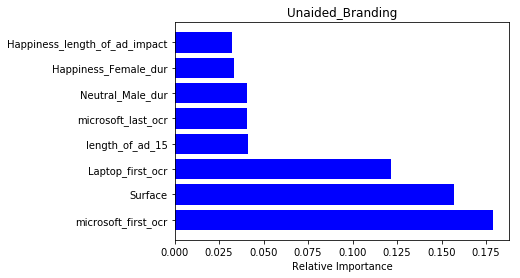

Brand_Cues__Mean
Feature ranking:
microsoft_first_ocr
microsoft_total_ocr
Neutral_dur
African_dur
Age: 25-34_Eastasian_dur
Surface
Laptop_total_ocr
Tablet_total_ocr
Male_dur
Laptop_dur
Tablet_dur
microsoft_dur
Caucasian_dur
Tablet_last_ocr
Laptop_first_ocr
Neutral_Age: 25-34_dur
Age: 25-34_dur
Tablet_first_ocr
microsoft_last_ocr
Laptop_last_ocr
Age: 35-44_dur
Happiness_Eastasian_dur
Age: 25-34_Caucasian_dur
Neutral_Male_dur
Eastasian_dur
Macbook_dur
Happiness_Female_dur
Happiness_dur
Female_dur
Happiness_length_of_ad_impact
Sadness_dur
Age: 35-44_Eastasian_dur
length_of_ad_15
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


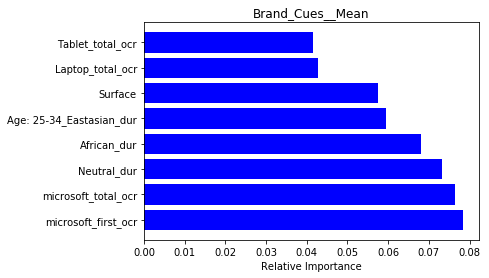

Aided_Branding__Mean
Feature ranking:
Laptop_total_ocr
Surface
microsoft_total_ocr
Tablet_total_ocr
Happiness_Female_dur
Tablet_dur
Male_dur
African_dur
Tablet_last_ocr
Neutral_Male_dur
Laptop_dur
Neutral_dur
Age: 25-34_dur
Laptop_last_ocr
Tablet_first_ocr
Sadness_dur
microsoft_first_ocr
Female_dur
Eastasian_dur
microsoft_last_ocr
Happiness_length_of_ad_impact
Happiness_dur
Laptop_first_ocr
Neutral_Age: 25-34_dur
Age: 25-34_Eastasian_dur
Caucasian_dur
Happiness_Eastasian_dur
microsoft_dur
Macbook_dur
Age: 25-34_Caucasian_dur
Age: 35-44_dur
length_of_ad_15
Age: 35-44_Eastasian_dur
Windows_dur
Surface_total_ocr
Surface_last_ocr
Surface_first_ocr
Yoga_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Surface_dur


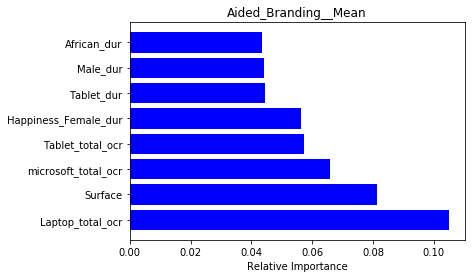

Active_Involvement__Mean
Feature ranking:
Tablet_dur
microsoft_total_ocr
microsoft_first_ocr
microsoft_last_ocr
length_of_ad_15
Tablet_total_ocr
Laptop_last_ocr
Laptop_dur
Tablet_first_ocr
Caucasian_dur
microsoft_dur
Age: 25-34_Eastasian_dur
Laptop_total_ocr
Tablet_last_ocr
Surface
Eastasian_dur
Age: 25-34_dur
Neutral_dur
Happiness_length_of_ad_impact
Male_dur
Laptop_first_ocr
Age: 25-34_Caucasian_dur
Neutral_Male_dur
Happiness_dur
Happiness_Eastasian_dur
Neutral_Age: 25-34_dur
Happiness_Female_dur
Female_dur
Sadness_dur
African_dur
Age: 35-44_Eastasian_dur
Age: 35-44_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


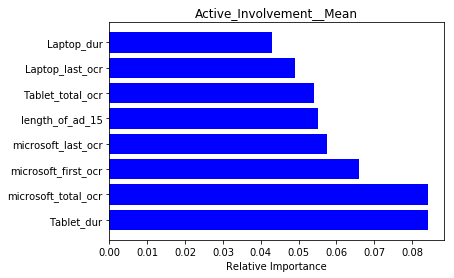

New_Information__Mean
Feature ranking:
Tablet_first_ocr
Tablet_last_ocr
Tablet_total_ocr
Laptop_total_ocr
Age: 25-34_dur
microsoft_last_ocr
African_dur
Laptop_last_ocr
Tablet_dur
Neutral_dur
length_of_ad_15
Happiness_Female_dur
Neutral_Age: 25-34_dur
Caucasian_dur
microsoft_total_ocr
Neutral_Male_dur
Surface
Laptop_dur
Age: 25-34_Caucasian_dur
Male_dur
Happiness_Eastasian_dur
microsoft_first_ocr
Laptop_first_ocr
microsoft_dur
Happiness_dur
Macbook_dur
Happiness_length_of_ad_impact
Female_dur
Age: 25-34_Eastasian_dur
Age: 35-44_Eastasian_dur
Sadness_dur
Eastasian_dur
Age: 35-44_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


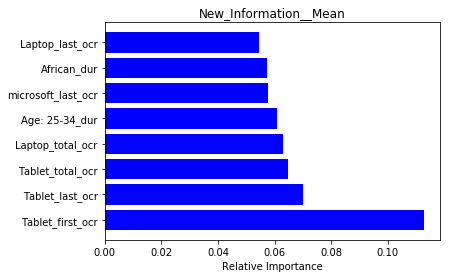

Enjoyment__Mean
Feature ranking:
microsoft_last_ocr
Neutral_dur
length_of_ad_15
Laptop_total_ocr
Neutral_Age: 25-34_dur
Caucasian_dur
Macbook_dur
Laptop_last_ocr
African_dur
microsoft_total_ocr
Surface
microsoft_first_ocr
Age: 25-34_dur
Laptop_dur
Age: 25-34_Caucasian_dur
Sadness_dur
Male_dur
Tablet_first_ocr
Happiness_dur
Tablet_last_ocr
Female_dur
Laptop_first_ocr
Happiness_Female_dur
Neutral_Male_dur
Tablet_dur
microsoft_dur
Happiness_length_of_ad_impact
Happiness_Eastasian_dur
Tablet_total_ocr
Age: 25-34_Eastasian_dur
Age: 35-44_dur
Eastasian_dur
Age: 35-44_Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


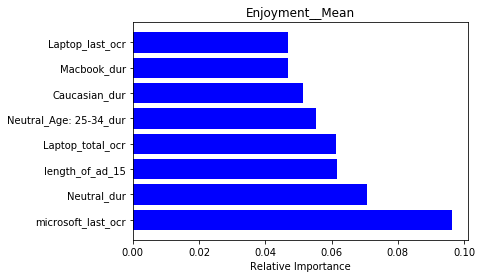

Brand_Appeal__Mean
Feature ranking:
African_dur
Macbook_dur
Laptop_last_ocr
microsoft_last_ocr
Laptop_total_ocr
Neutral_dur
microsoft_first_ocr
Surface
microsoft_total_ocr
Age: 25-34_dur
length_of_ad_15
Tablet_first_ocr
Caucasian_dur
Laptop_dur
Neutral_Age: 25-34_dur
Age: 25-34_Eastasian_dur
Age: 25-34_Caucasian_dur
Neutral_Male_dur
Happiness_Eastasian_dur
Male_dur
Tablet_last_ocr
Happiness_Female_dur
Female_dur
Sadness_dur
Laptop_first_ocr
Tablet_total_ocr
Tablet_dur
Eastasian_dur
Happiness_length_of_ad_impact
microsoft_dur
Happiness_dur
Age: 35-44_dur
Age: 35-44_Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


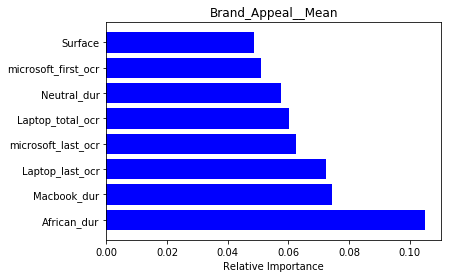

Understanding__Mean
Feature ranking:
African_dur
Surface
Laptop_first_ocr
Male_dur
Tablet_dur
microsoft_first_ocr
Happiness_Female_dur
Age: 25-34_dur
Laptop_dur
Neutral_Male_dur
Happiness_Eastasian_dur
microsoft_total_ocr
Neutral_dur
Caucasian_dur
Macbook_dur
microsoft_dur
Tablet_total_ocr
Laptop_total_ocr
Age: 25-34_Caucasian_dur
Age: 35-44_dur
Age: 35-44_Eastasian_dur
Tablet_first_ocr
Tablet_last_ocr
microsoft_last_ocr
Female_dur
Eastasian_dur
Laptop_last_ocr
Neutral_Age: 25-34_dur
Age: 25-34_Eastasian_dur
Happiness_dur
Happiness_length_of_ad_impact
Sadness_dur
length_of_ad_15
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


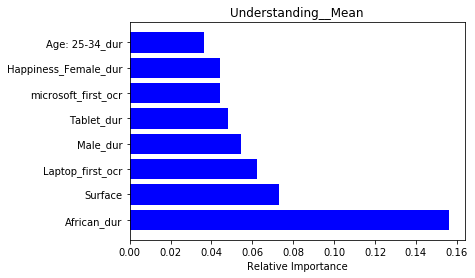

Relevance_of_Information__Mean
Feature ranking:
Male_dur
Laptop_total_ocr
microsoft_total_ocr
microsoft_last_ocr
Age: 25-34_dur
Laptop_first_ocr
Surface
Tablet_last_ocr
Laptop_dur
Neutral_Male_dur
Neutral_dur
Tablet_total_ocr
Age: 25-34_Eastasian_dur
Tablet_first_ocr
Caucasian_dur
Tablet_dur
Laptop_last_ocr
African_dur
Neutral_Age: 25-34_dur
microsoft_first_ocr
Female_dur
Happiness_dur
length_of_ad_15
Macbook_dur
microsoft_dur
Age: 25-34_Caucasian_dur
Happiness_Eastasian_dur
Happiness_Female_dur
Happiness_length_of_ad_impact
Eastasian_dur
Age: 35-44_dur
Sadness_dur
Age: 35-44_Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


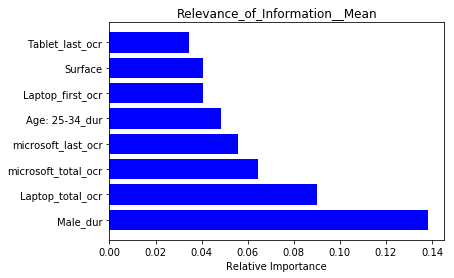

Credibility_of_Information__Mean
Feature ranking:
Macbook_dur
Male_dur
Surface
microsoft_total_ocr
Neutral_Male_dur
Neutral_dur
Laptop_dur
Tablet_total_ocr
Tablet_dur
Neutral_Age: 25-34_dur
Laptop_total_ocr
Caucasian_dur
microsoft_first_ocr
Age: 25-34_Eastasian_dur
Laptop_first_ocr
Tablet_last_ocr
Tablet_first_ocr
microsoft_last_ocr
Laptop_last_ocr
Happiness_Eastasian_dur
microsoft_dur
Happiness_Female_dur
Age: 25-34_dur
African_dur
Happiness_dur
Happiness_length_of_ad_impact
Age: 25-34_Caucasian_dur
Female_dur
Eastasian_dur
Sadness_dur
Age: 35-44_dur
Age: 35-44_Eastasian_dur
length_of_ad_15
ASUS T102_dur
Surface_total_ocr
Surface_last_ocr
Dell_dur
Surface_first_ocr
Yoga_dur
Windows_dur
Lenovo_dur
HP_dur
Surface_dur


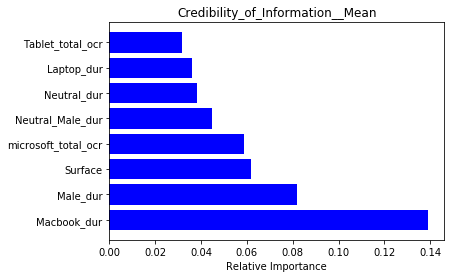

Brand_Difference__Mean
Feature ranking:
microsoft_last_ocr
length_of_ad_15
Laptop_last_ocr
Tablet_first_ocr
Age: 25-34_dur
African_dur
Laptop_total_ocr
Tablet_last_ocr
Happiness_length_of_ad_impact
Macbook_dur
microsoft_total_ocr
Neutral_Male_dur
Tablet_total_ocr
Tablet_dur
Laptop_dur
microsoft_first_ocr
microsoft_dur
Surface
Neutral_dur
Happiness_dur
Caucasian_dur
Neutral_Age: 25-34_dur
Laptop_first_ocr
Eastasian_dur
Happiness_Female_dur
Happiness_Eastasian_dur
Age: 25-34_Caucasian_dur
Female_dur
Age: 25-34_Eastasian_dur
Sadness_dur
Male_dur
Age: 35-44_Eastasian_dur
Age: 35-44_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


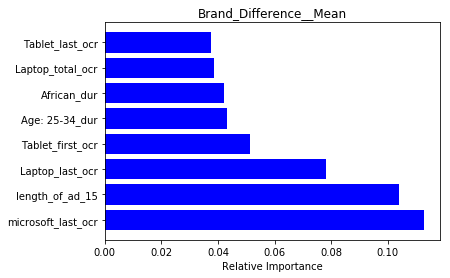

Interest_peak
Feature ranking:
Surface
Neutral_dur
Laptop_total_ocr
microsoft_first_ocr
Laptop_dur
Tablet_last_ocr
microsoft_total_ocr
Age: 25-34_dur
Laptop_first_ocr
Sadness_dur
Female_dur
microsoft_last_ocr
Male_dur
microsoft_dur
Happiness_dur
Laptop_last_ocr
Neutral_Age: 25-34_dur
Eastasian_dur
Neutral_Male_dur
Tablet_total_ocr
Age: 25-34_Eastasian_dur
Happiness_Female_dur
Tablet_dur
Happiness_Eastasian_dur
Tablet_first_ocr
Caucasian_dur
Happiness_length_of_ad_impact
Age: 25-34_Caucasian_dur
African_dur
Age: 35-44_dur
Macbook_dur
Age: 35-44_Eastasian_dur
length_of_ad_15
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


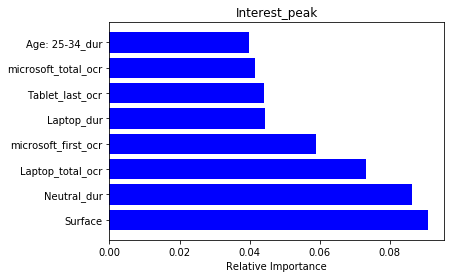

Interest_mean_score
Feature ranking:
microsoft_last_ocr
Laptop_dur
microsoft_first_ocr
Neutral_Male_dur
Age: 25-34_dur
length_of_ad_15
Neutral_Age: 25-34_dur
Laptop_last_ocr
Tablet_last_ocr
microsoft_dur
microsoft_total_ocr
Age: 25-34_Caucasian_dur
Happiness_dur
Caucasian_dur
Neutral_dur
Sadness_dur
Surface
Laptop_first_ocr
Tablet_dur
Happiness_Female_dur
Female_dur
Happiness_length_of_ad_impact
Male_dur
Laptop_total_ocr
Tablet_first_ocr
Happiness_Eastasian_dur
Eastasian_dur
Tablet_total_ocr
African_dur
Macbook_dur
Age: 25-34_Eastasian_dur
Age: 35-44_dur
Age: 35-44_Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


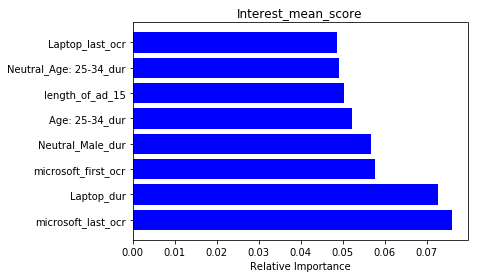

Purchase_intent
Feature ranking:
microsoft_first_ocr
microsoft_total_ocr
Laptop_total_ocr
Tablet_dur
Tablet_total_ocr
Neutral_dur
Surface
microsoft_dur
Tablet_last_ocr
Laptop_last_ocr
Laptop_dur
microsoft_last_ocr
Happiness_length_of_ad_impact
Tablet_first_ocr
Laptop_first_ocr
Age: 25-34_Eastasian_dur
Happiness_dur
Caucasian_dur
Neutral_Male_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Age: 25-34_dur
Happiness_Female_dur
Age: 35-44_dur
Female_dur
Male_dur
Age: 35-44_Eastasian_dur
African_dur
Age: 25-34_Caucasian_dur
Happiness_Eastasian_dur
length_of_ad_15
Sadness_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


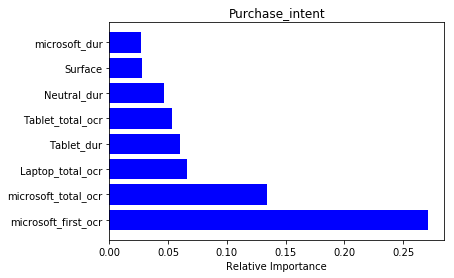

Persuasion_mean
Feature ranking:
microsoft_first_ocr
microsoft_total_ocr
Age: 25-34_Eastasian_dur
Laptop_dur
Caucasian_dur
Neutral_dur
microsoft_dur
Age: 25-34_dur
Age: 25-34_Caucasian_dur
Tablet_total_ocr
Laptop_last_ocr
Neutral_Age: 25-34_dur
Laptop_first_ocr
Tablet_dur
Tablet_first_ocr
Surface
Laptop_total_ocr
microsoft_last_ocr
Eastasian_dur
length_of_ad_15
Happiness_length_of_ad_impact
Male_dur
Tablet_last_ocr
Female_dur
Age: 35-44_Eastasian_dur
Happiness_dur
Happiness_Eastasian_dur
Happiness_Female_dur
Neutral_Male_dur
Age: 35-44_dur
African_dur
Sadness_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


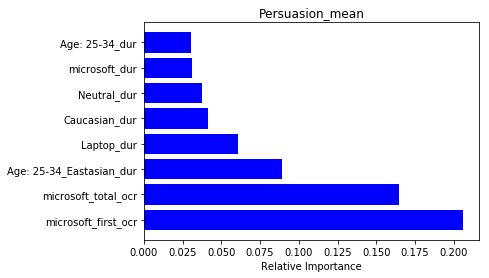

Persuasion_very_likely
Feature ranking:
microsoft_first_ocr
Age: 25-34_Eastasian_dur
microsoft_total_ocr
Laptop_dur
Surface
Neutral_dur
Age: 25-34_dur
Tablet_dur
Laptop_last_ocr
Caucasian_dur
Laptop_first_ocr
microsoft_dur
Age: 25-34_Caucasian_dur
Tablet_total_ocr
Neutral_Age: 25-34_dur
Tablet_first_ocr
Laptop_total_ocr
microsoft_last_ocr
Eastasian_dur
Female_dur
Happiness_dur
Male_dur
Tablet_last_ocr
length_of_ad_15
Happiness_length_of_ad_impact
Neutral_Male_dur
Happiness_Female_dur
Age: 35-44_Eastasian_dur
African_dur
Sadness_dur
Age: 35-44_dur
Happiness_Eastasian_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


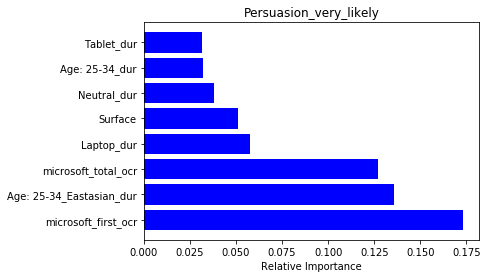

Interest_peak_frames
Feature ranking:
Neutral_dur
Surface
Laptop_total_ocr
microsoft_first_ocr
microsoft_total_ocr
Age: 25-34_dur
Tablet_last_ocr
Laptop_dur
Laptop_first_ocr
Sadness_dur
microsoft_dur
microsoft_last_ocr
Happiness_dur
Laptop_last_ocr
Female_dur
Neutral_Age: 25-34_dur
Male_dur
Neutral_Male_dur
Eastasian_dur
Tablet_dur
Age: 25-34_Eastasian_dur
Tablet_total_ocr
Happiness_Female_dur
Happiness_Eastasian_dur
Tablet_first_ocr
Caucasian_dur
Happiness_length_of_ad_impact
Age: 25-34_Caucasian_dur
African_dur
Age: 35-44_dur
Macbook_dur
Age: 35-44_Eastasian_dur
length_of_ad_15
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


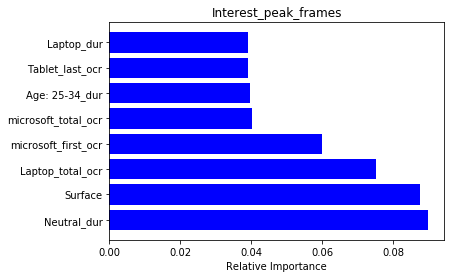

In [21]:
model.plot_feature_importance(models_17,10,y_train_17.columns,X_train_17.columns,savefig=False)

In [70]:
len(y_train_17.columns)

17

Unaided_Branding
Feature ranking:
microsoft_first_ocr
Laptop_first_ocr
microsoft_dur
Happiness_dur
Laptop_total_ocr
Age: 25-34_Eastasian_dur
Age: 25-34_dur
Surface_total_ocr
Surface_dur
Tablet_last_ocr
Tablet_dur
Happiness_length_of_ad_impact
African_dur
Surface Book_dur
Caucasian_dur
Laptop_dur
microsoft_last_ocr
Age: 25-34_Caucasian_dur
Male_dur
Sadness_dur
Female_dur
Laptop_last_ocr
microsoft_total_ocr
Surface_first_ocr
Happiness_Eastasian_dur
Neutral_Male_dur
Age: 35-44_Eastasian_dur
Surface_last_ocr
Happiness_Female_dur
Eastasian_dur
Neutral_dur
Tablet_total_ocr
Tablet_first_ocr
length_of_ad_15
Neutral_Age: 25-34_dur
Age: 35-44_dur
Surface Pen_dur
MacBook Air_dur
Macbook Air_dur
ad_type_tv
MacBook Pro_dur
Microsoft Surface_dur
The surface Laptop_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
Surface Laptop_dur
Surface laptop_dur
Suface Laptop_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur

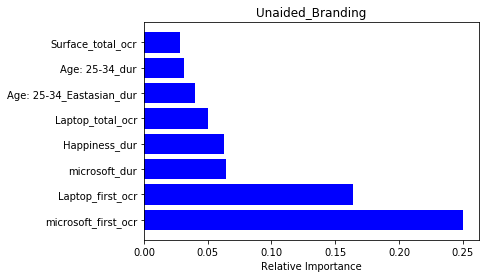

Interest_peak
Feature ranking:
Macbook Air_dur
Neutral_Male_dur
Neutral_Age: 25-34_dur
Happiness_Female_dur
Female_dur
Happiness_dur
Surface_first_ocr
Age: 25-34_dur
Surface_last_ocr
Laptop_last_ocr
Laptop_dur
Age: 25-34_Caucasian_dur
Laptop_total_ocr
Caucasian_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Surface_dur
microsoft_last_ocr
Tablet_first_ocr
Male_dur
Tablet_total_ocr
African_dur
Neutral_dur
Age: 35-44_dur
microsoft_total_ocr
Age: 25-34_Eastasian_dur
Surface_total_ocr
microsoft_dur
Laptop_first_ocr
Age: 35-44_Eastasian_dur
Happiness_length_of_ad_impact
Happiness_Eastasian_dur
Surface Book_dur
Sadness_dur
Eastasian_dur
length_of_ad_15
Surface Pen_dur
ad_type_tv
MacBook Pro_dur
MacBook Air_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Lenovo Yoga 910_dur
Suface Laptop_dur
Microsoft Surface_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_du

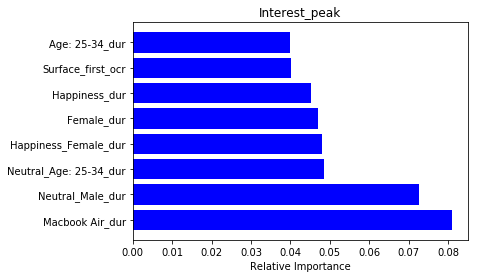

Interest_mean_score
Feature ranking:
Surface_dur
microsoft_first_ocr
Surface_total_ocr
Age: 25-34_dur
Sadness_dur
Neutral_Male_dur
microsoft_last_ocr
Laptop_first_ocr
microsoft_dur
Surface_first_ocr
Laptop_total_ocr
Caucasian_dur
Happiness_dur
Surface Book_dur
Laptop_last_ocr
Surface_last_ocr
Neutral_dur
Laptop_dur
Tablet_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Female_dur
Male_dur
Tablet_first_ocr
Tablet_total_ocr
microsoft_total_ocr
African_dur
length_of_ad_15
Surface Pen_dur
Tablet_last_ocr
Macbook Air_dur
Happiness_length_of_ad_impact
Age: 25-34_Caucasian_dur
Age: 25-34_Eastasian_dur
Age: 35-44_Eastasian_dur
Age: 35-44_dur
Happiness_Eastasian_dur
MacBook Air_dur
Happiness_Female_dur
ad_type_tv
MacBook Pro_dur
Surface Laptop_dur
Windows 10_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
The surface Laptop_dur
Windows_dur
Suface Laptop_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, 

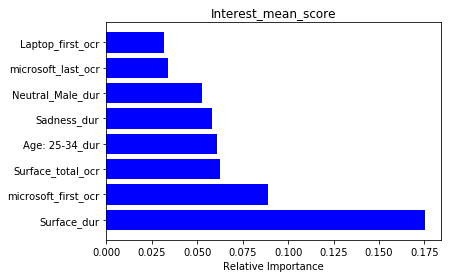

Interest_peak_frames
Feature ranking:
Macbook Air_dur
Neutral_Male_dur
Happiness_Female_dur
Neutral_Age: 25-34_dur
Female_dur
Surface_first_ocr
Age: 25-34_dur
Surface_last_ocr
Happiness_dur
Laptop_last_ocr
Laptop_dur
Laptop_total_ocr
Age: 25-34_Caucasian_dur
Caucasian_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Tablet_first_ocr
Surface_dur
microsoft_last_ocr
Male_dur
Tablet_total_ocr
Neutral_dur
African_dur
microsoft_total_ocr
Age: 35-44_dur
Age: 25-34_Eastasian_dur
microsoft_dur
Laptop_first_ocr
Surface_total_ocr
Happiness_Eastasian_dur
Surface Book_dur
Happiness_length_of_ad_impact
Age: 35-44_Eastasian_dur
Eastasian_dur
Sadness_dur
length_of_ad_15
Surface Pen_dur
MacBook Pro_dur
ad_type_tv
MacBook Air_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Lenovo Yoga 910_dur
Suface Laptop_dur
Microsoft Surface_dur
ASUS T102_dur
Dell PCs_dur
Dell

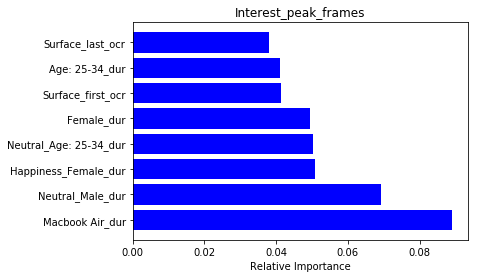

In [28]:
model.plot_feature_importance(models_4,10,y_train_4.columns,X_train_4.columns,savefig=False)

In [22]:
from tqdm import tqdm 
shap.initjs()

In [ ]:
explainer=[]
shap_values=[]
for i in tqdm(range(17)):
    explainer.append(shap.TreeExplainer(models_17[i]))
    shap_values.append(explainer[-1].shap_values(X_train_17))
    print(i)

  6%|▌         | 1/17 [00:04<01:04,  4.05s/it]

In [1]:
explainer[0]

NameError: name 'explainer' is not defined

In [25]:
import matplotlib.pyplot as plt

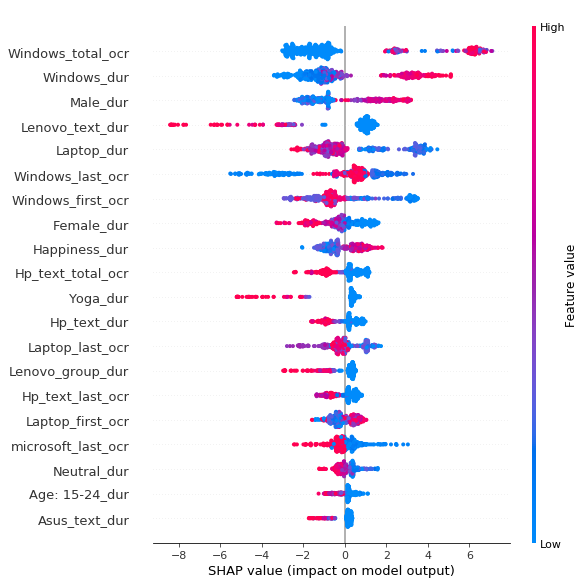

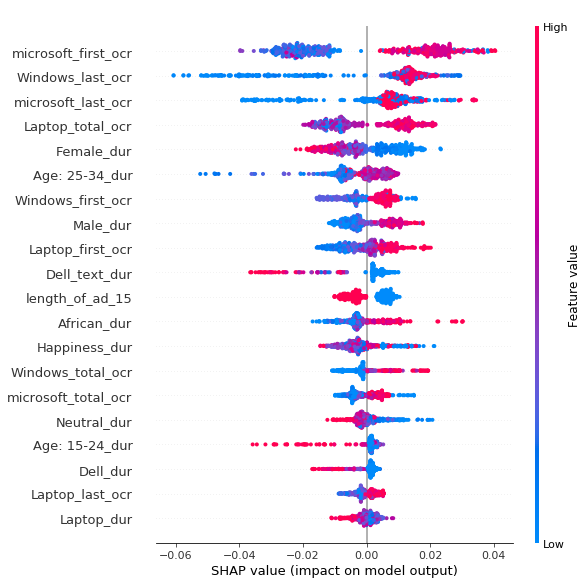

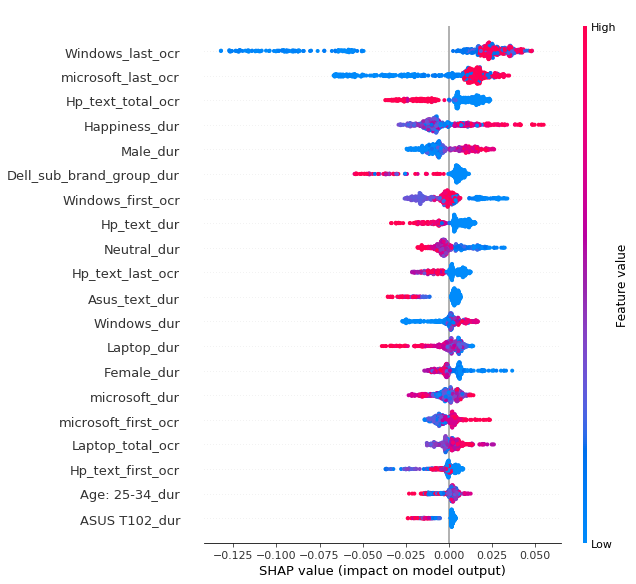

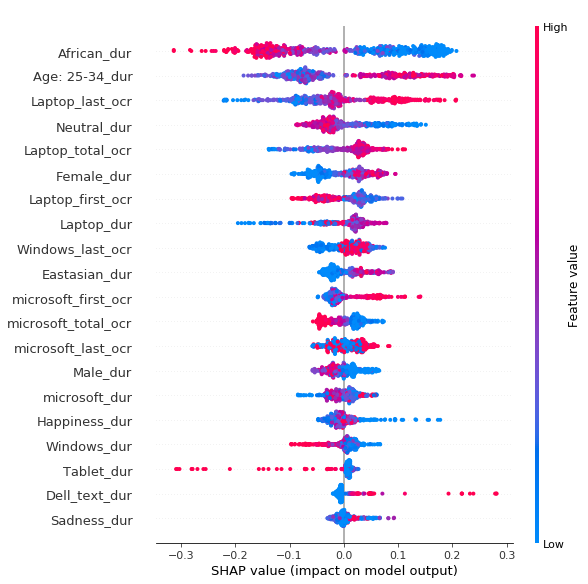

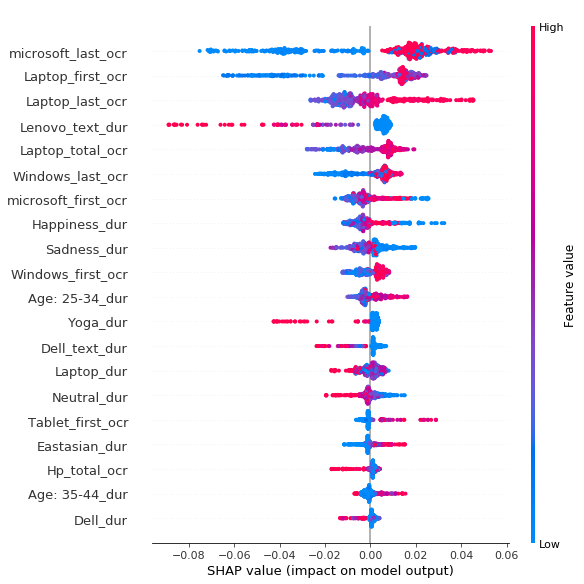

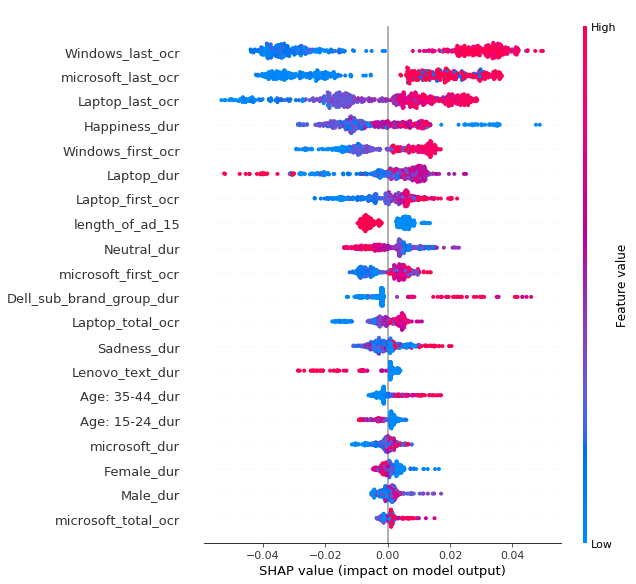

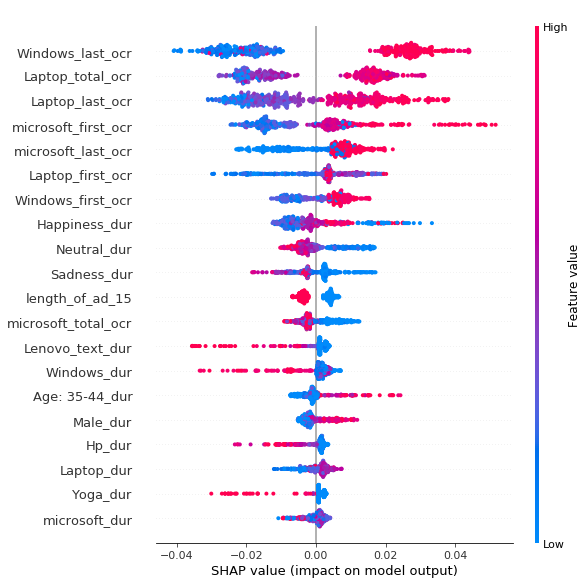

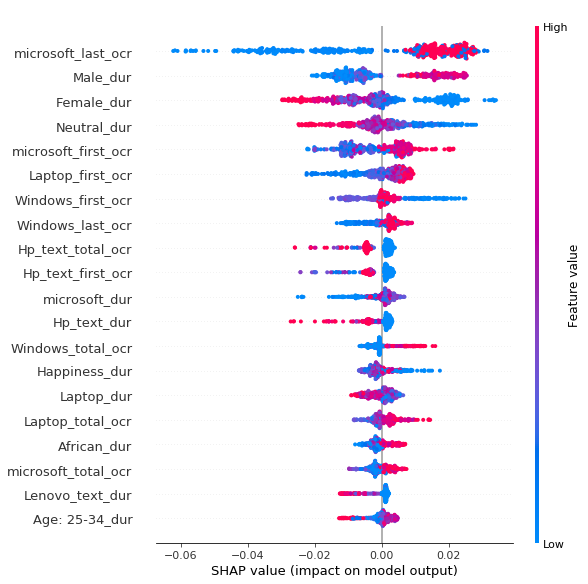

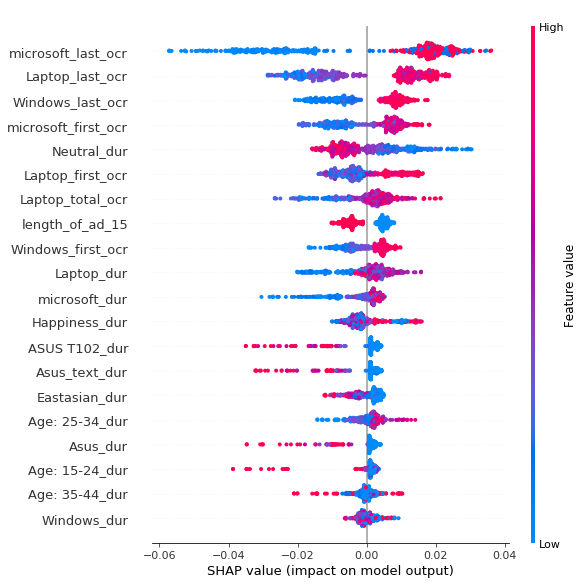

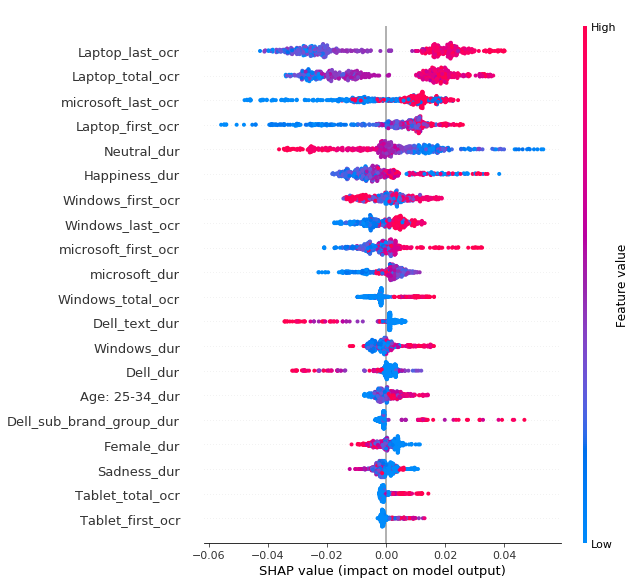

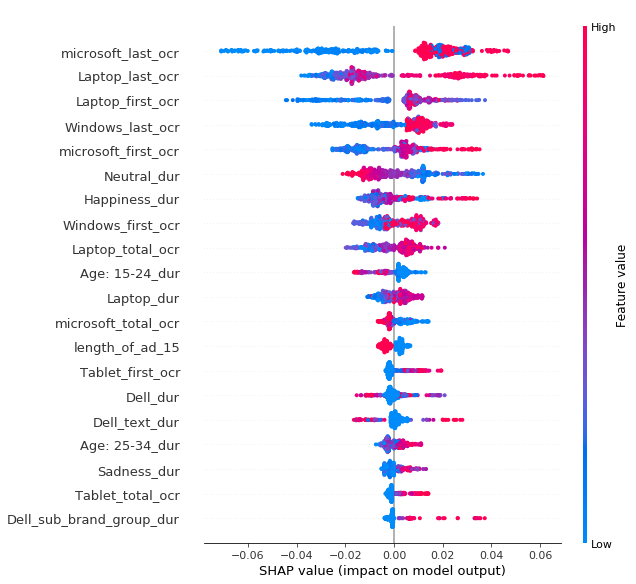

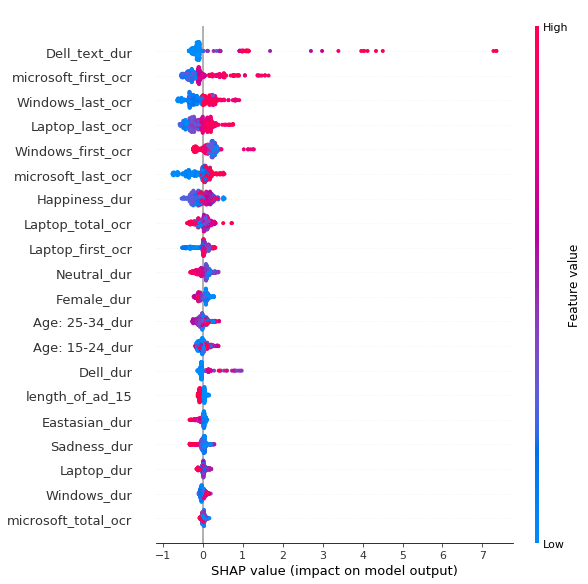

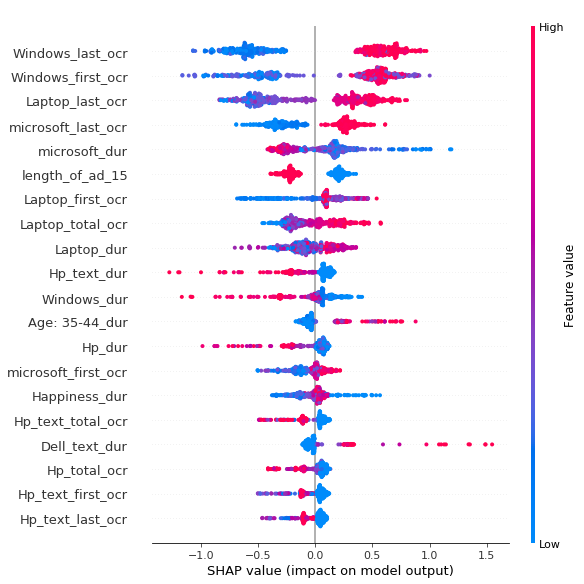

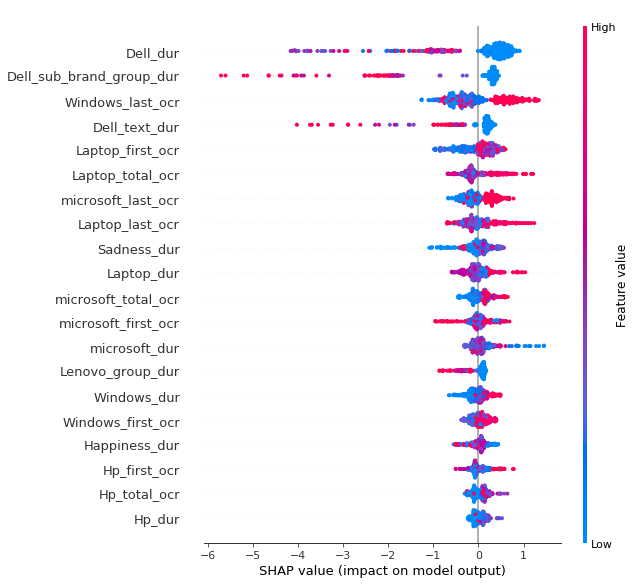

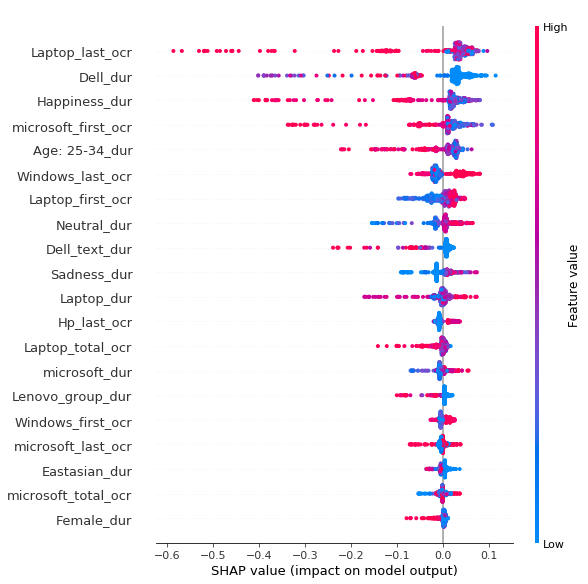

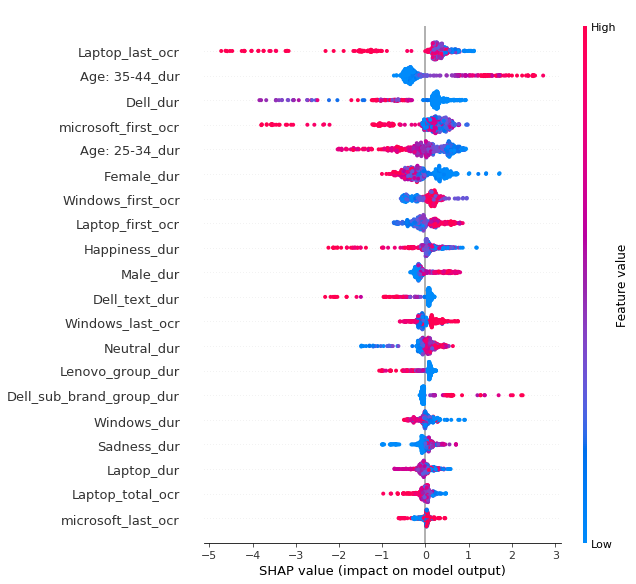

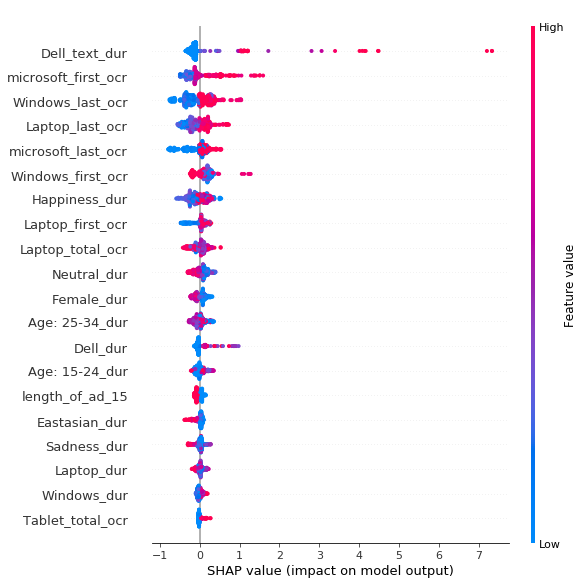

In [48]:
for i in range(17):
    plt.figure()
    shap.summary_plot(shap_values[i],X_train_17,show=False)
    plt.savefig('./shap_software/'+y_train_17.columns[i]+'.png',bbox_inches='tight')

In [44]:
model_xgb = Model('xgb')
print("------------------------ 17 XGB Models Training ----------------------------\n")
models_xgb_17 = model_xgb.train(X_train_17,y_train_17,X_test_17,y_test_17,metrics='r2',plot_error=False)

------------------------ 17 XGB Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


For training set
r2_score: 0.946415
For test set
r2_score: 0.948176


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


For training set
r2_score: 0.855320
For test set
r2_score: 0.918069


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


For training set
r2_score: 0.893356
For test set
r2_score: 0.921205


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


For training set
r2_score: 0.919479
For test set
r2_score: 0.932853


New_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


For training set
r2_score: 0.929189
For test set
r2_score: 0.949352


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


For training set
r2_score: 0.901437
For test set
r2_score: 0.893448


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


For training set
r2_score: 0.937702
For test set
r2_score: 0.942833


Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


For training set
r2_score: 0.913093
For test set
r2_score: 0.930662


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


For training set
r2_score: 0.930033
For test set
r2_score: 0.927373


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


For training set
r2_score: 0.917815
For test set
r2_score: 0.920372


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


For training set
r2_score: 0.913248
For test set
r2_score: 0.925676


Interest_peak


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


For training set
r2_score: 0.844074
For test set
r2_score: 0.853546


Interest_mean_score


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


For training set
r2_score: 0.894221
For test set
r2_score: 0.913090


Purchase_intent


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


For training set
r2_score: 0.923689
For test set
r2_score: 0.920680


Persuasion_mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


For training set
r2_score: 0.923351
For test set
r2_score: 0.929475


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.921774
For test set
r2_score: 0.924660


Interest_peak_frames


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


For training set
r2_score: 0.877261
For test set
r2_score: 0.896287




Unaided_Branding
length_of_ad_15
microsoft_first_ocr
Laptop_first_ocr
Neutral_Male_dur
Surface
microsoft_last_ocr
Age: 35-44_Eastasian_dur
Laptop_last_ocr
Happiness_Female_dur
Happiness_length_of_ad_impact
Age: 35-44_dur
Happiness_dur
Laptop_total_ocr
Neutral_Age: 25-34_dur
Tablet_last_ocr
Age: 25-34_Eastasian_dur
Tablet_total_ocr
Caucasian_dur
African_dur
microsoft_dur
Eastasian_dur
Tablet_first_ocr
Tablet_dur
Happiness_Eastasian_dur
Female_dur
Laptop_dur
Neutral_dur
microsoft_total_ocr
Age: 25-34_Caucasian_dur
Male_dur
Age: 25-34_dur
Sadness_dur
Macbook_dur
Yoga_dur
Windows_dur
Surface_total_ocr
Surface_last_ocr
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Surface_first_ocr
Surface_dur


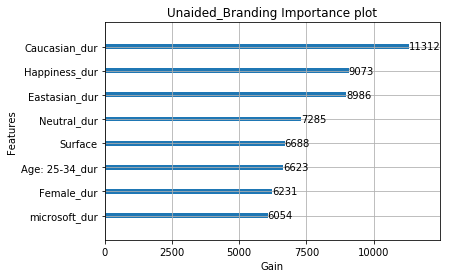

Brand_Cues__Mean
Age: 25-34_Eastasian_dur
African_dur
Macbook_dur
microsoft_total_ocr
Surface
microsoft_first_ocr
Male_dur
Tablet_total_ocr
Tablet_first_ocr
Tablet_last_ocr
Age: 35-44_dur
Neutral_dur
Tablet_dur
length_of_ad_15
microsoft_last_ocr
Happiness_length_of_ad_impact
Happiness_Female_dur
Laptop_last_ocr
Laptop_first_ocr
Caucasian_dur
Age: 25-34_Caucasian_dur
microsoft_dur
Laptop_total_ocr
Happiness_Eastasian_dur
Age: 35-44_Eastasian_dur
Age: 25-34_dur
Neutral_Age: 25-34_dur
Neutral_Male_dur
Laptop_dur
Happiness_dur
Eastasian_dur
Female_dur
Sadness_dur
Surface_total_ocr
Surface_last_ocr
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_dur


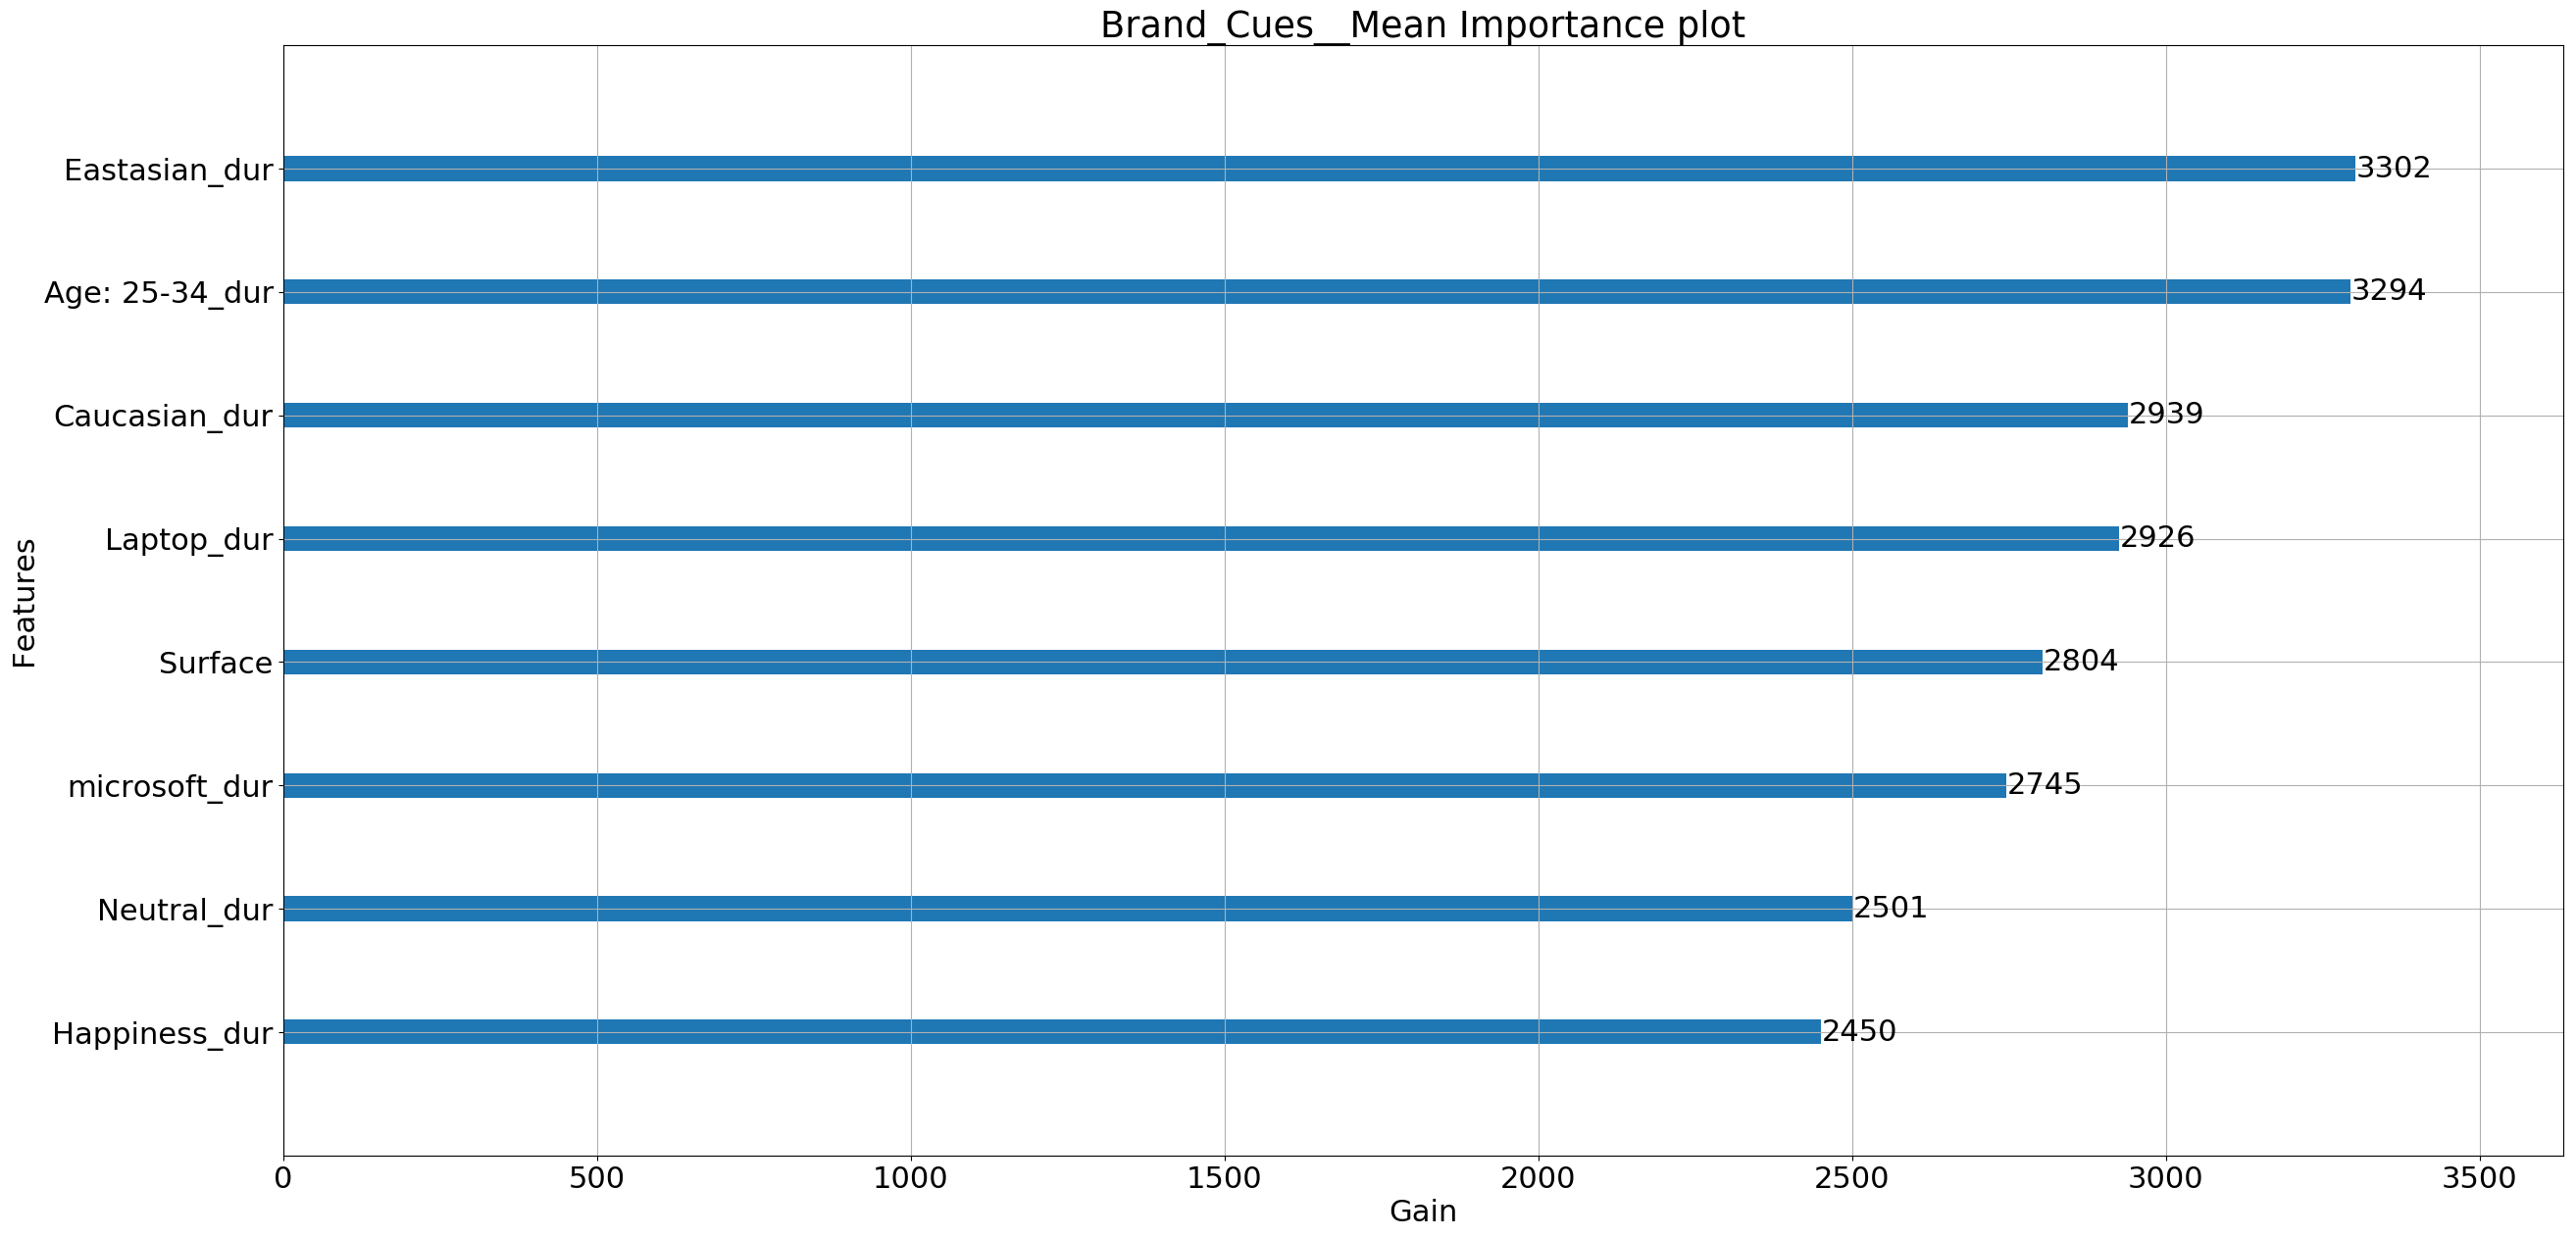

Aided_Branding__Mean
Tablet_total_ocr
Happiness_length_of_ad_impact
length_of_ad_15
Surface
Macbook_dur
Tablet_last_ocr
Happiness_Female_dur
African_dur
microsoft_total_ocr
Laptop_total_ocr
Tablet_dur
Neutral_Male_dur
microsoft_last_ocr
Tablet_first_ocr
Laptop_last_ocr
Male_dur
Happiness_Eastasian_dur
Neutral_dur
Happiness_dur
microsoft_first_ocr
Age: 25-34_Eastasian_dur
microsoft_dur
Age: 25-34_dur
Female_dur
Laptop_first_ocr
Laptop_dur
Neutral_Age: 25-34_dur
Caucasian_dur
Age: 35-44_Eastasian_dur
Age: 25-34_Caucasian_dur
Eastasian_dur
Sadness_dur
Age: 35-44_dur
Dell_dur
ASUS T102_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


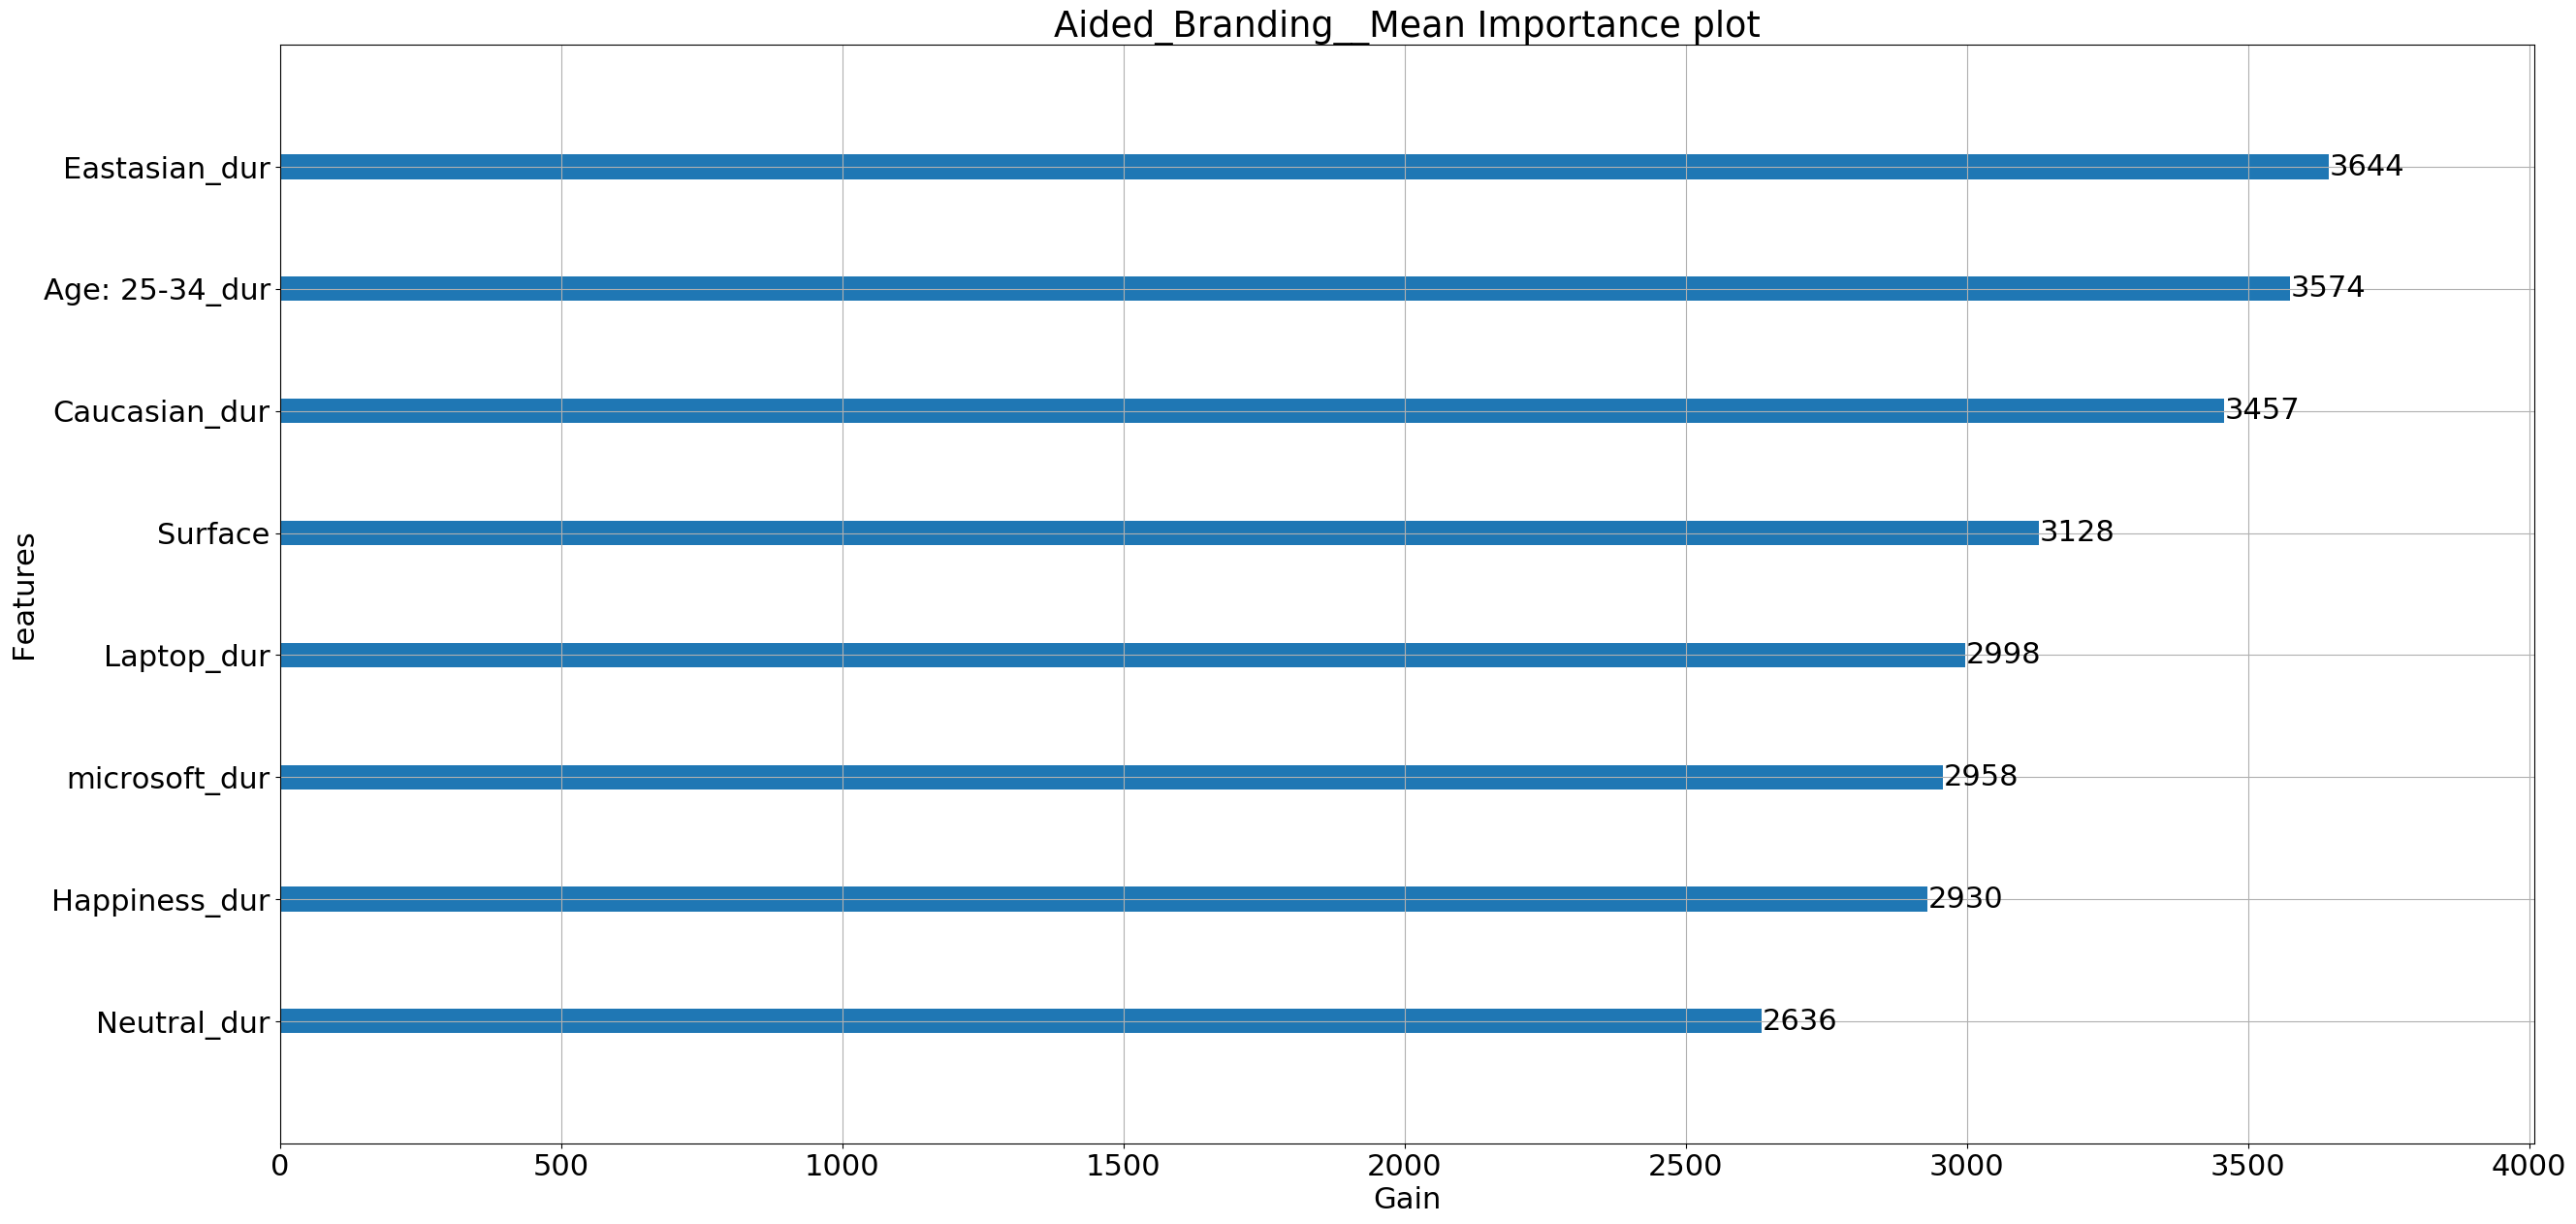

Active_Involvement__Mean
length_of_ad_15
Age: 25-34_Eastasian_dur
Tablet_dur
microsoft_first_ocr
Tablet_total_ocr
microsoft_total_ocr
microsoft_last_ocr
Tablet_first_ocr
Laptop_dur
Happiness_length_of_ad_impact
microsoft_dur
Tablet_last_ocr
Laptop_last_ocr
Age: 25-34_dur
Age: 25-34_Caucasian_dur
Surface
Neutral_Male_dur
Laptop_total_ocr
Laptop_first_ocr
Caucasian_dur
Neutral_dur
Male_dur
Age: 35-44_Eastasian_dur
Age: 35-44_dur
Neutral_Age: 25-34_dur
Happiness_dur
Happiness_Female_dur
Female_dur
Happiness_Eastasian_dur
Sadness_dur
African_dur
Eastasian_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


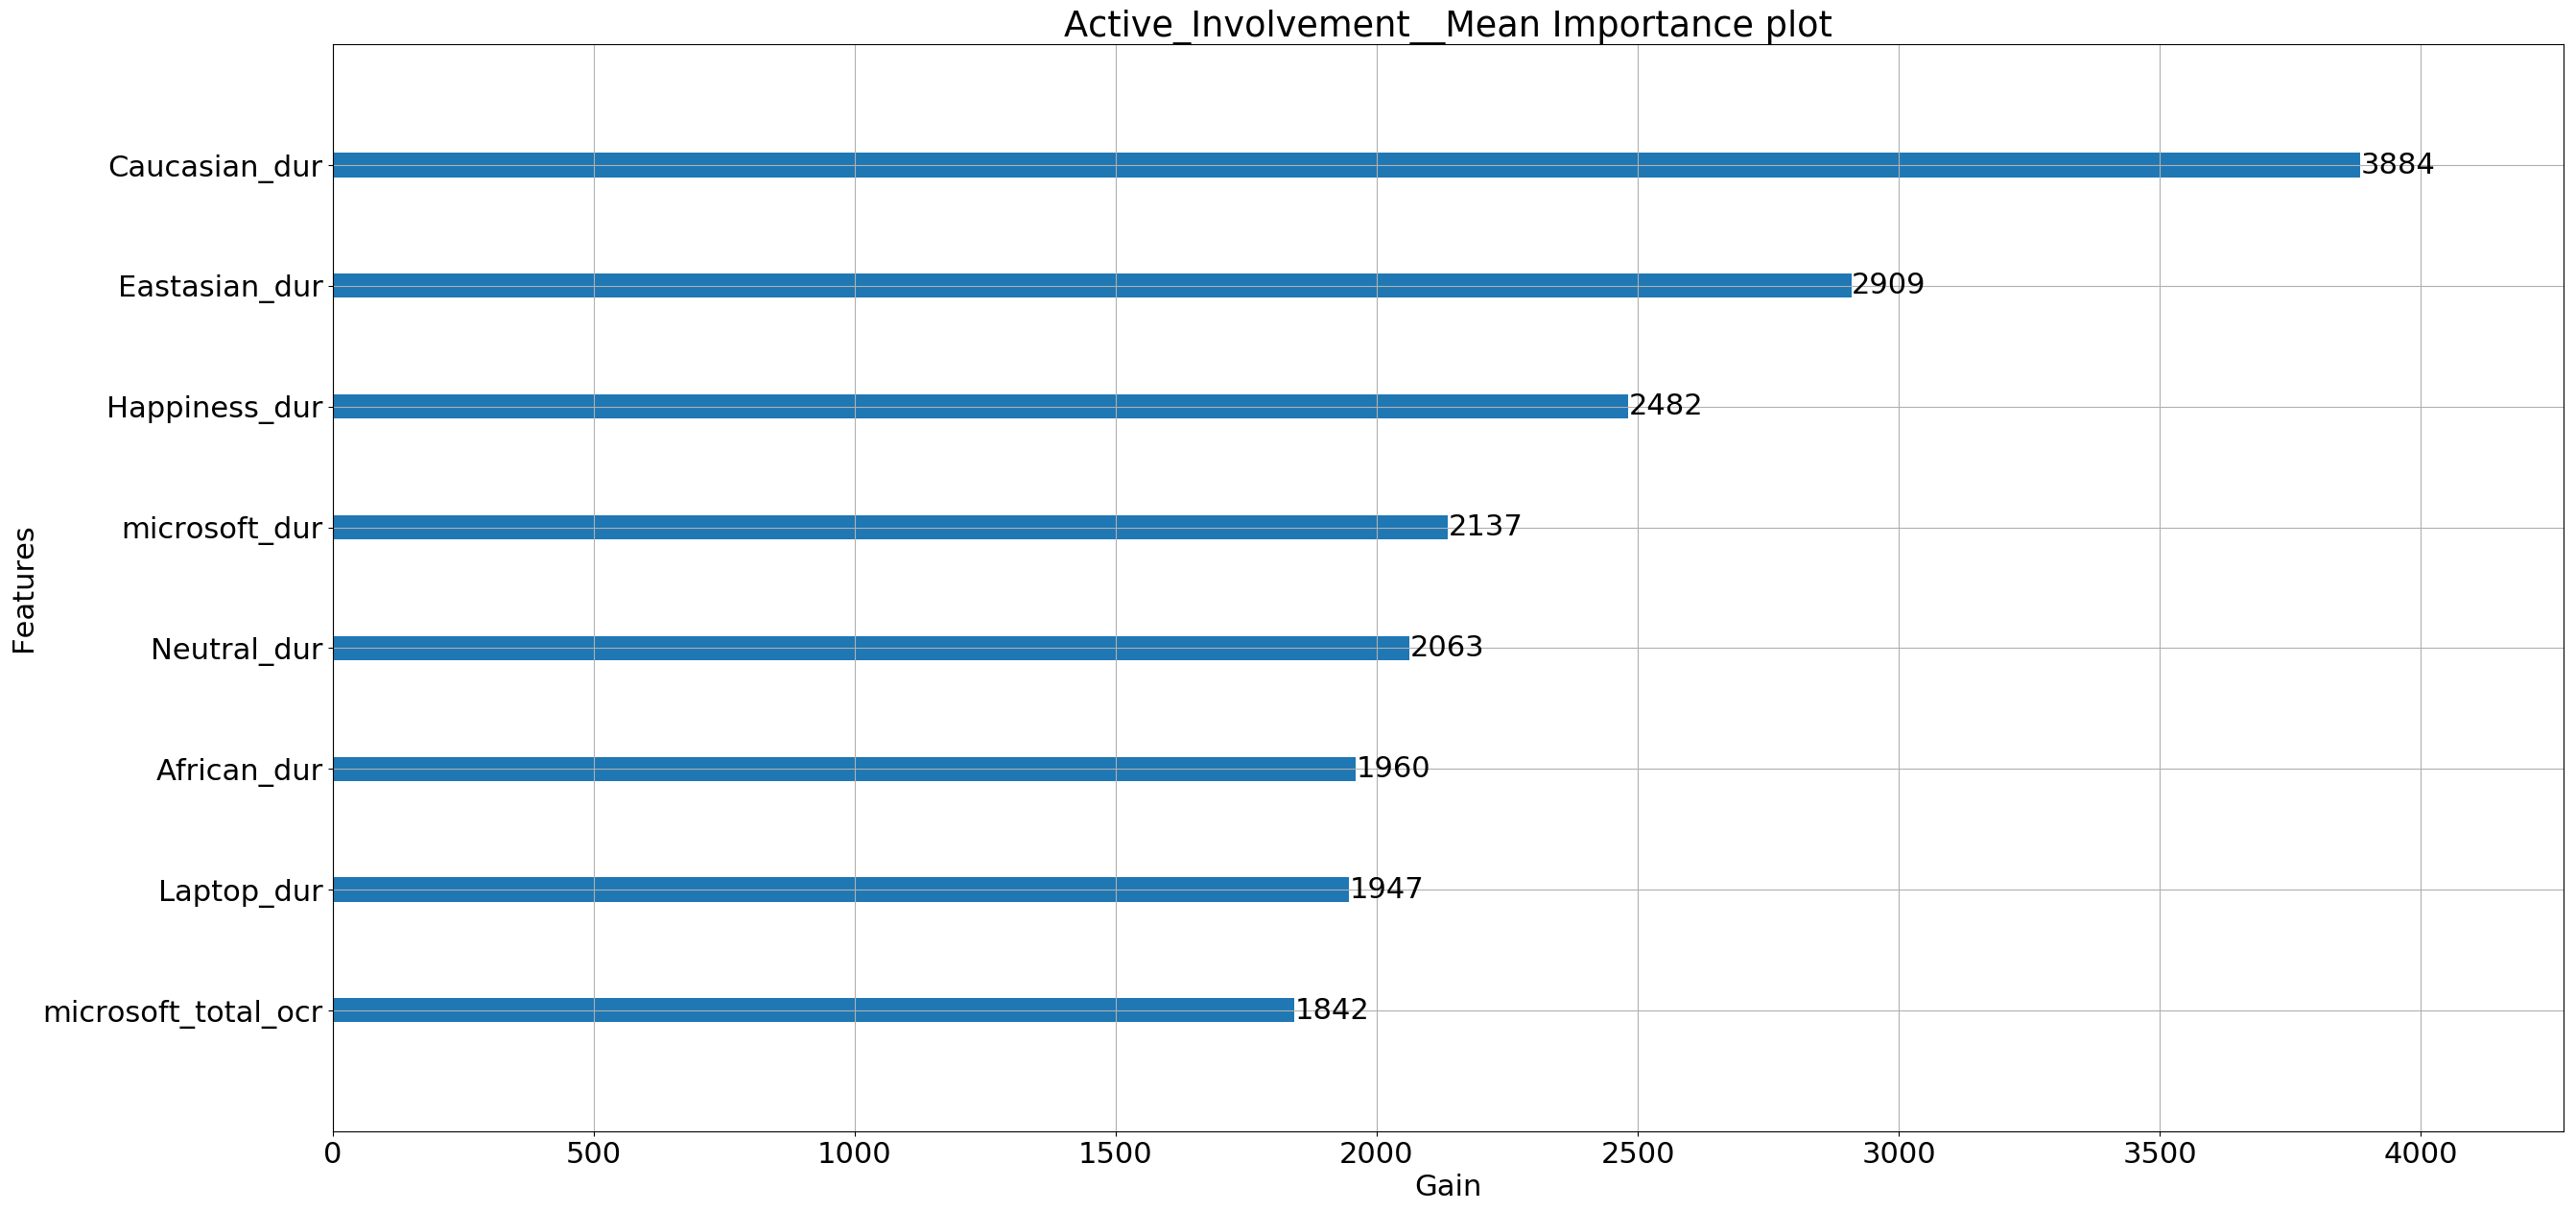

New_Information__Mean
length_of_ad_15
Tablet_last_ocr
microsoft_last_ocr
African_dur
Tablet_first_ocr
Tablet_total_ocr
Laptop_last_ocr
Neutral_Male_dur
Happiness_Female_dur
Age: 25-34_dur
Tablet_dur
Macbook_dur
Laptop_total_ocr
Age: 35-44_Eastasian_dur
Happiness_Eastasian_dur
Age: 25-34_Caucasian_dur
microsoft_total_ocr
Neutral_Age: 25-34_dur
Surface
Male_dur
Caucasian_dur
Neutral_dur
Laptop_dur
microsoft_first_ocr
Laptop_first_ocr
Age: 25-34_Eastasian_dur
Happiness_length_of_ad_impact
microsoft_dur
Age: 35-44_dur
Female_dur
Sadness_dur
Happiness_dur
Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


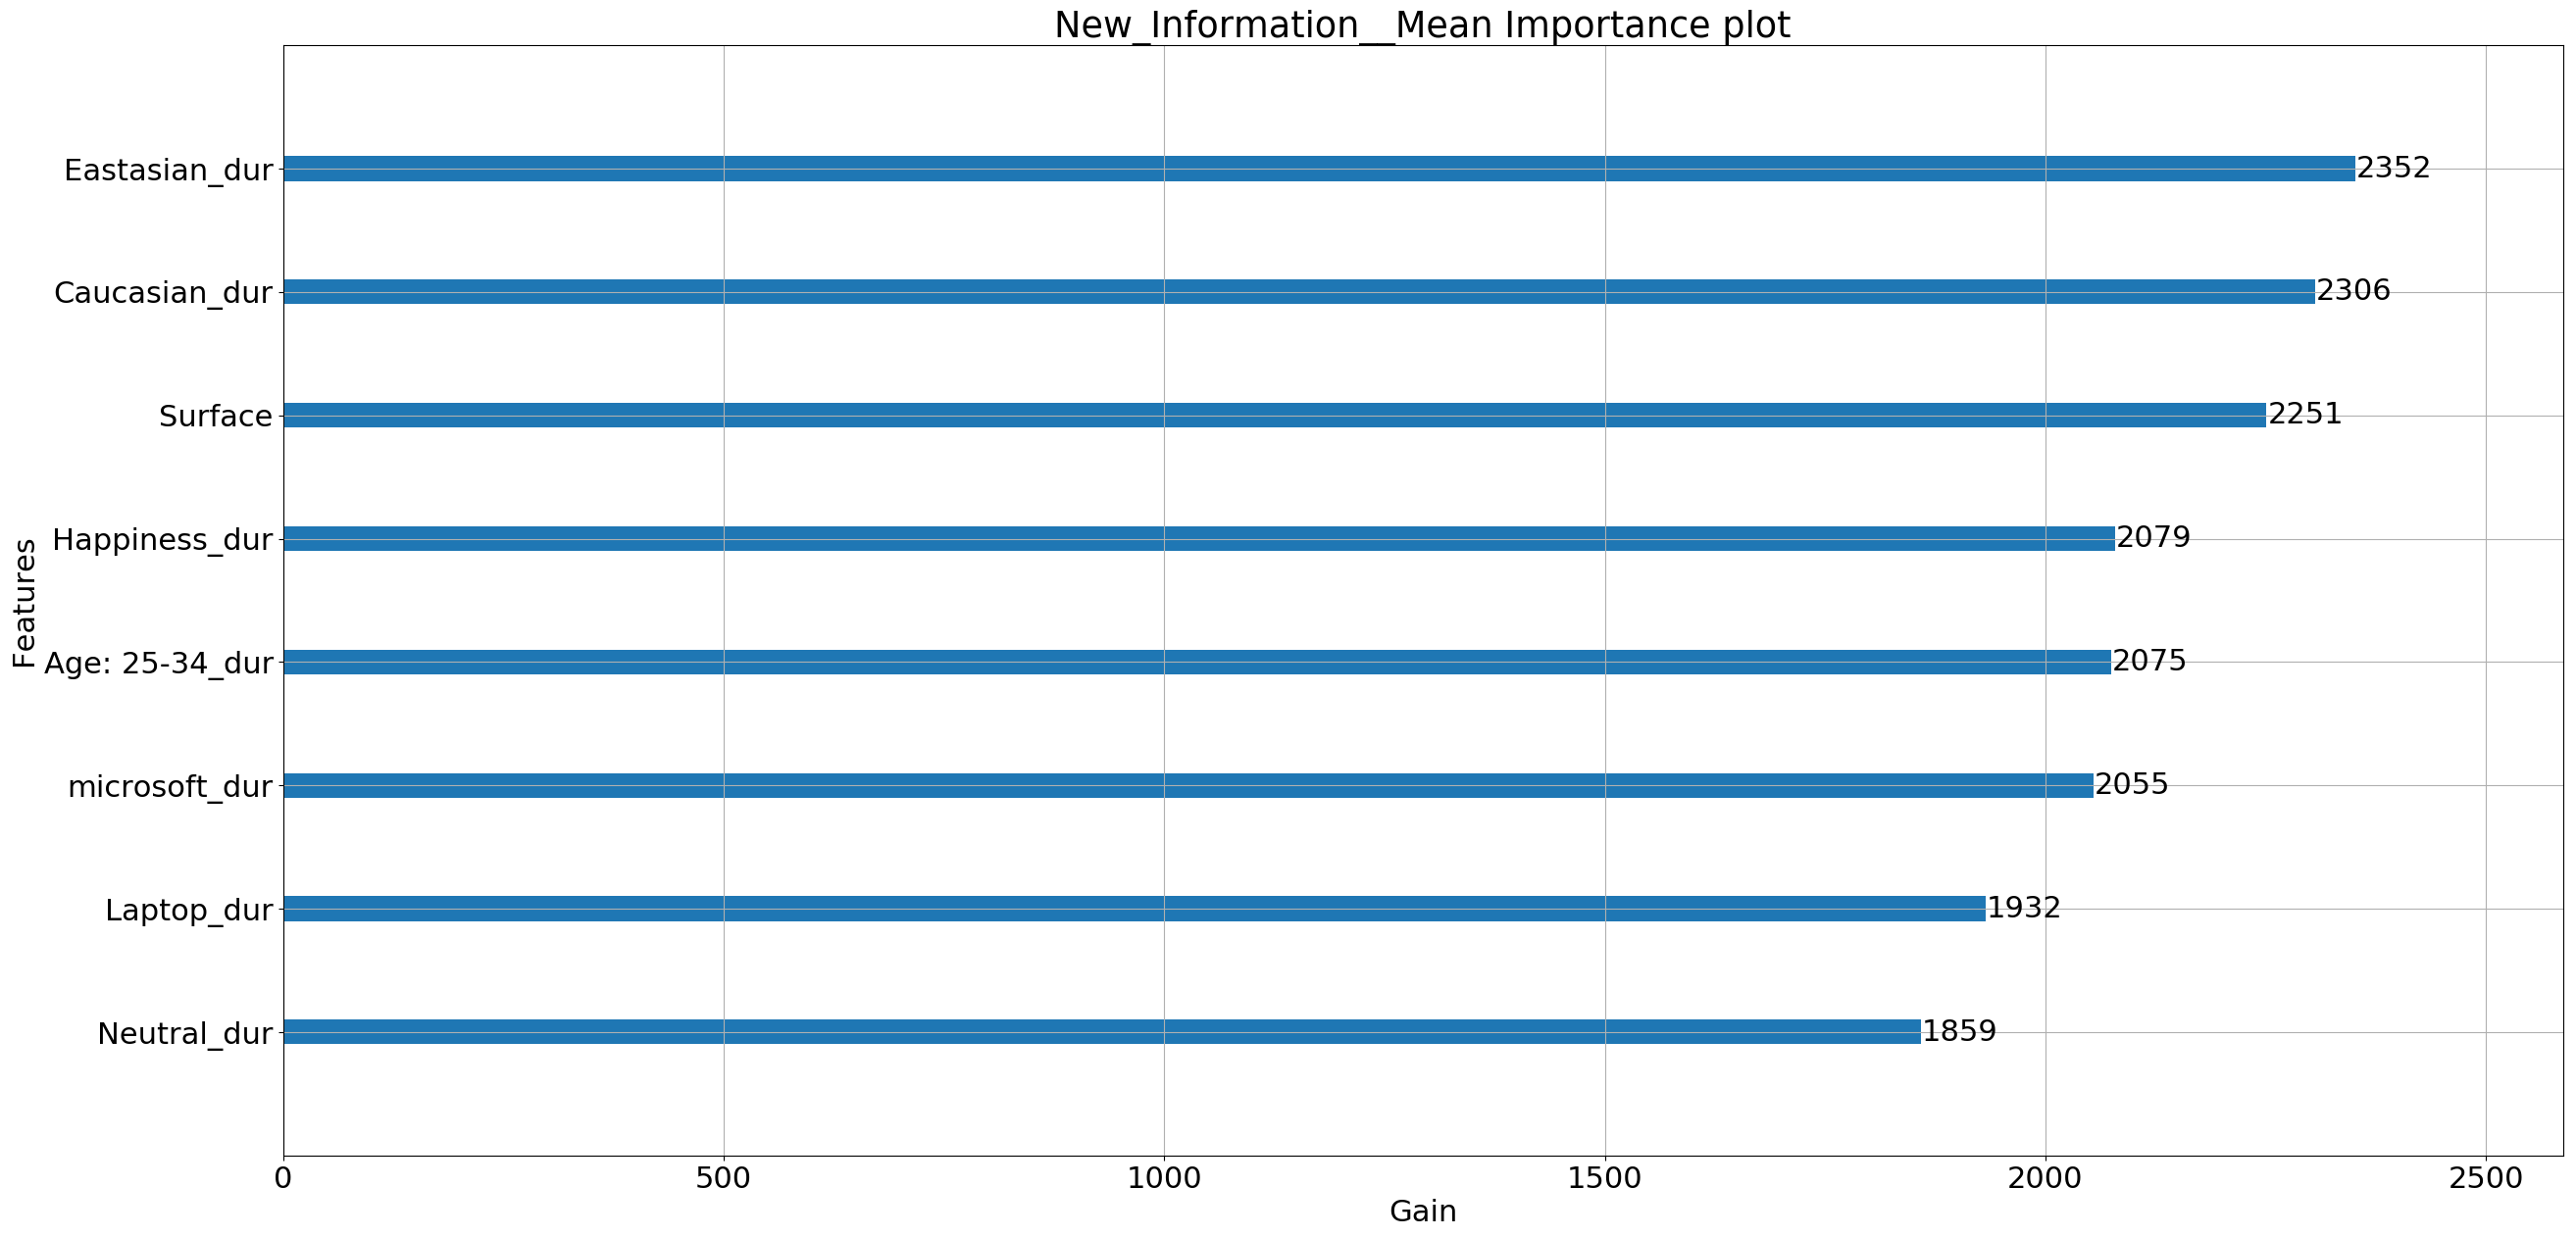

Enjoyment__Mean
length_of_ad_15
Macbook_dur
Neutral_dur
Neutral_Age: 25-34_dur
Laptop_total_ocr
microsoft_last_ocr
Tablet_first_ocr
Surface
Happiness_Female_dur
microsoft_total_ocr
Caucasian_dur
Happiness_Eastasian_dur
Tablet_last_ocr
Age: 35-44_dur
African_dur
Sadness_dur
Tablet_dur
Age: 25-34_dur
Laptop_first_ocr
Neutral_Male_dur
Laptop_dur
microsoft_dur
Age: 35-44_Eastasian_dur
microsoft_first_ocr
Laptop_last_ocr
Age: 25-34_Eastasian_dur
Male_dur
Female_dur
Tablet_total_ocr
Age: 25-34_Caucasian_dur
Happiness_dur
Happiness_length_of_ad_impact
Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


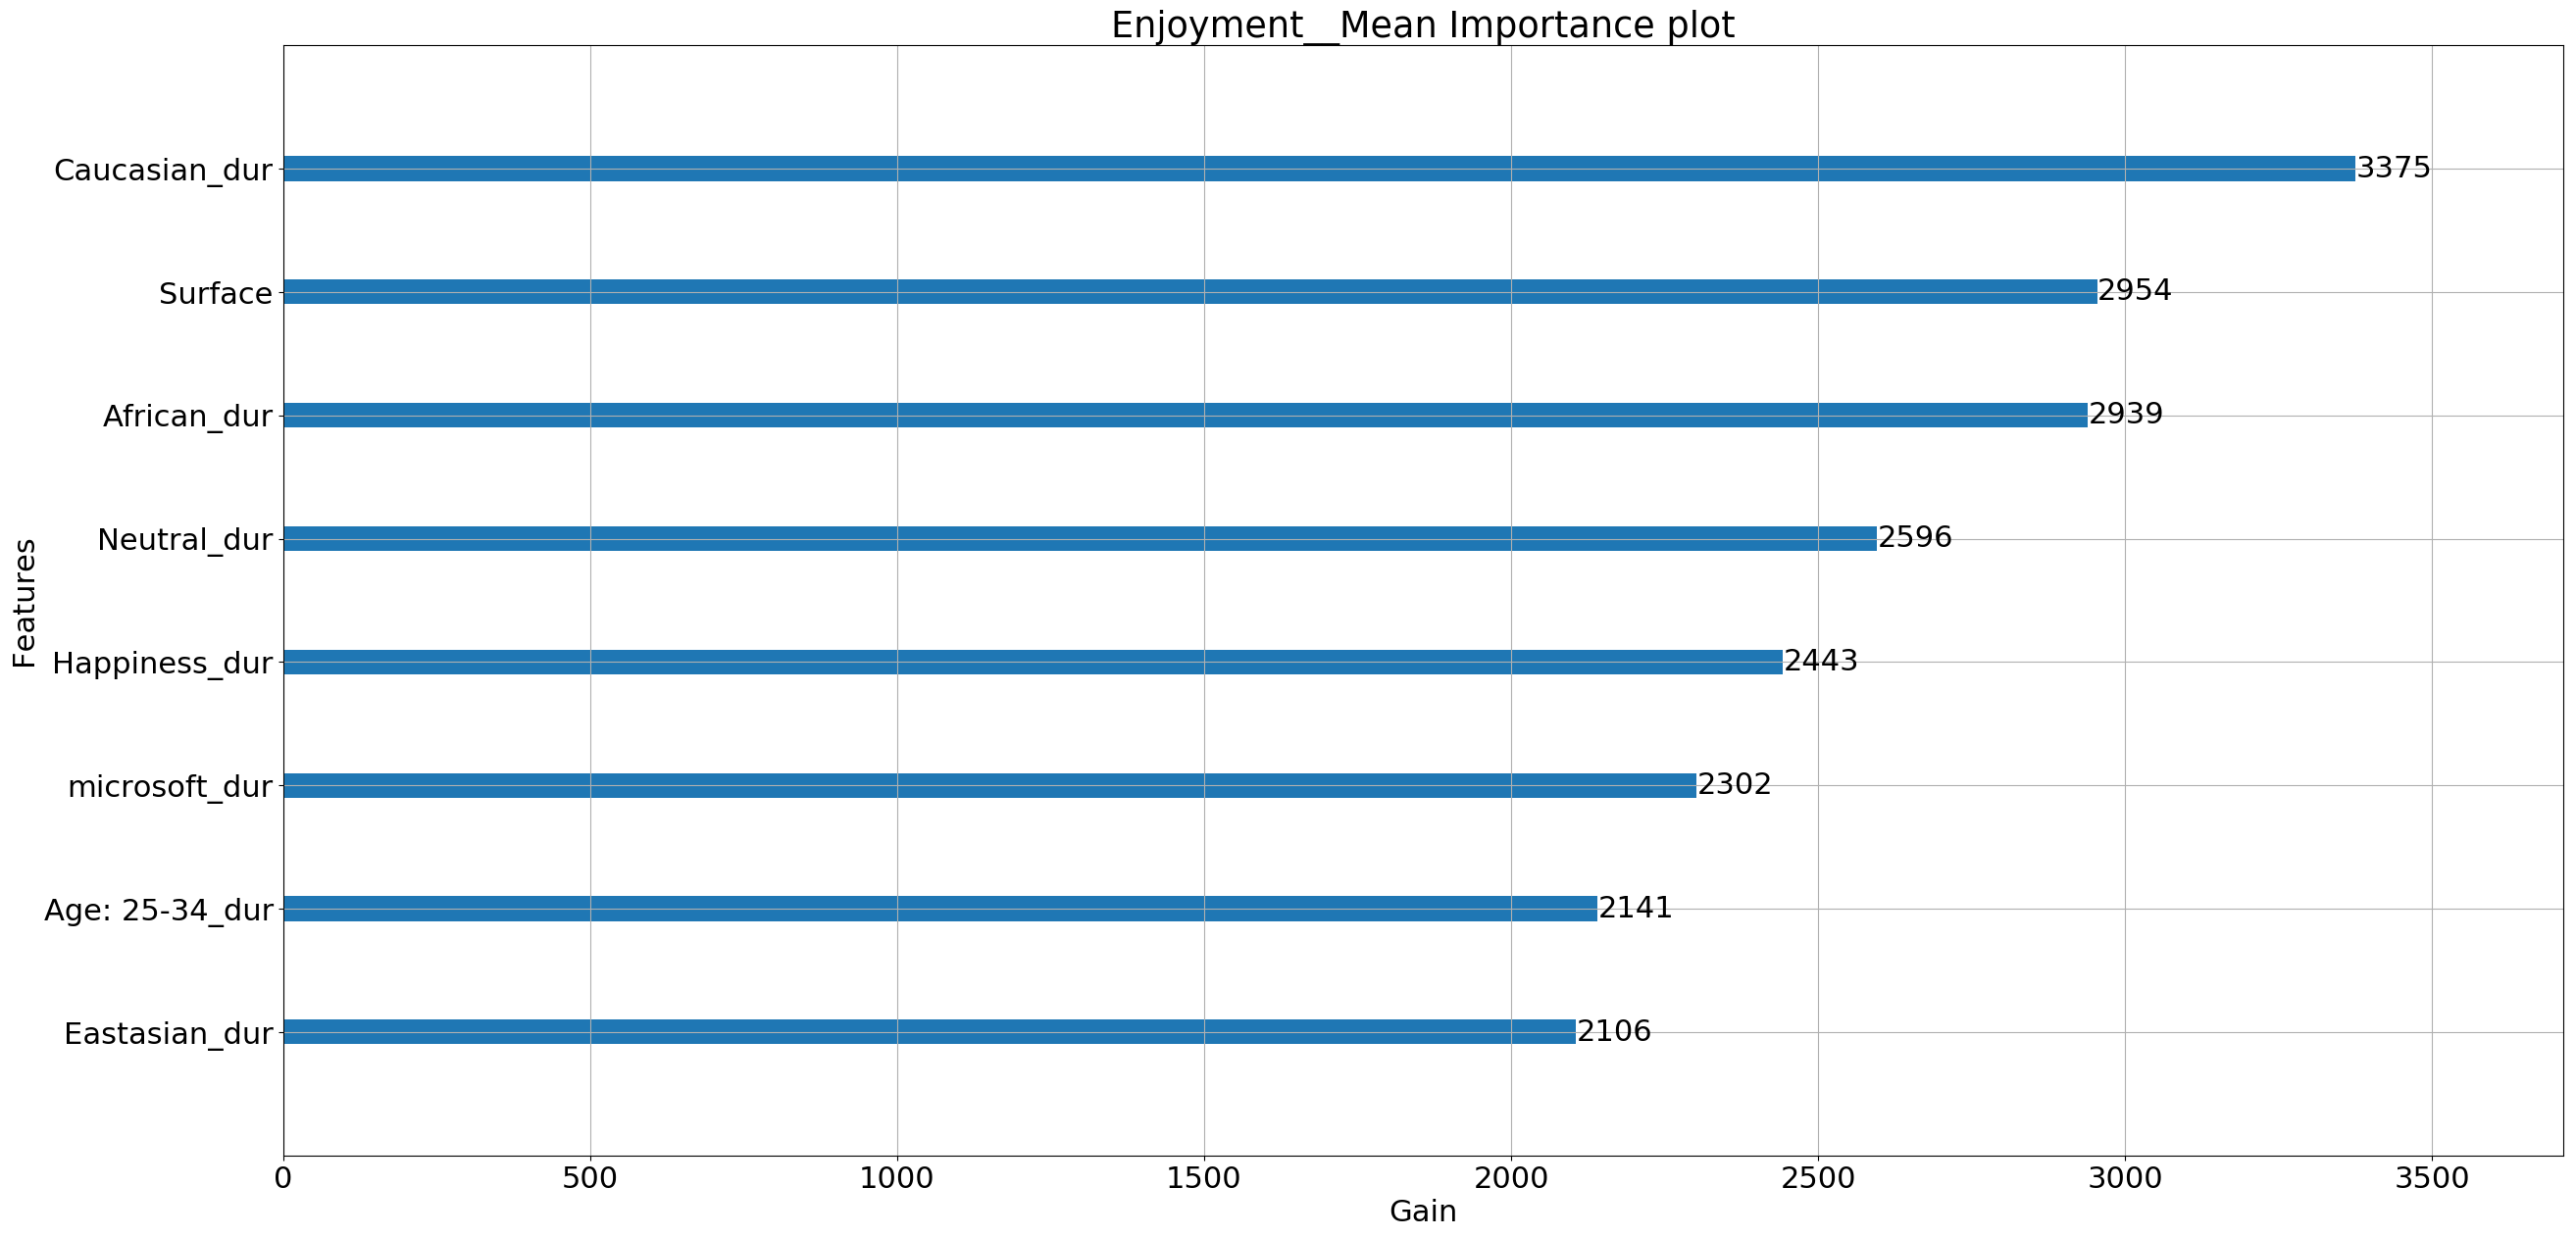

Brand_Appeal__Mean
length_of_ad_15
microsoft_last_ocr
Macbook_dur
Neutral_dur
African_dur
Laptop_total_ocr
Tablet_first_ocr
Age: 25-34_Eastasian_dur
Surface
microsoft_total_ocr
Age: 25-34_dur
microsoft_first_ocr
Tablet_last_ocr
Age: 25-34_Caucasian_dur
Laptop_last_ocr
Happiness_Female_dur
Sadness_dur
Caucasian_dur
Happiness_length_of_ad_impact
Happiness_Eastasian_dur
Laptop_first_ocr
Female_dur
Neutral_Male_dur
Age: 35-44_Eastasian_dur
Neutral_Age: 25-34_dur
Laptop_dur
Tablet_total_ocr
Tablet_dur
Age: 35-44_dur
Male_dur
microsoft_dur
Happiness_dur
Eastasian_dur
Yoga_dur
Windows_dur
Surface_total_ocr
Surface_last_ocr
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Surface_first_ocr
Surface_dur


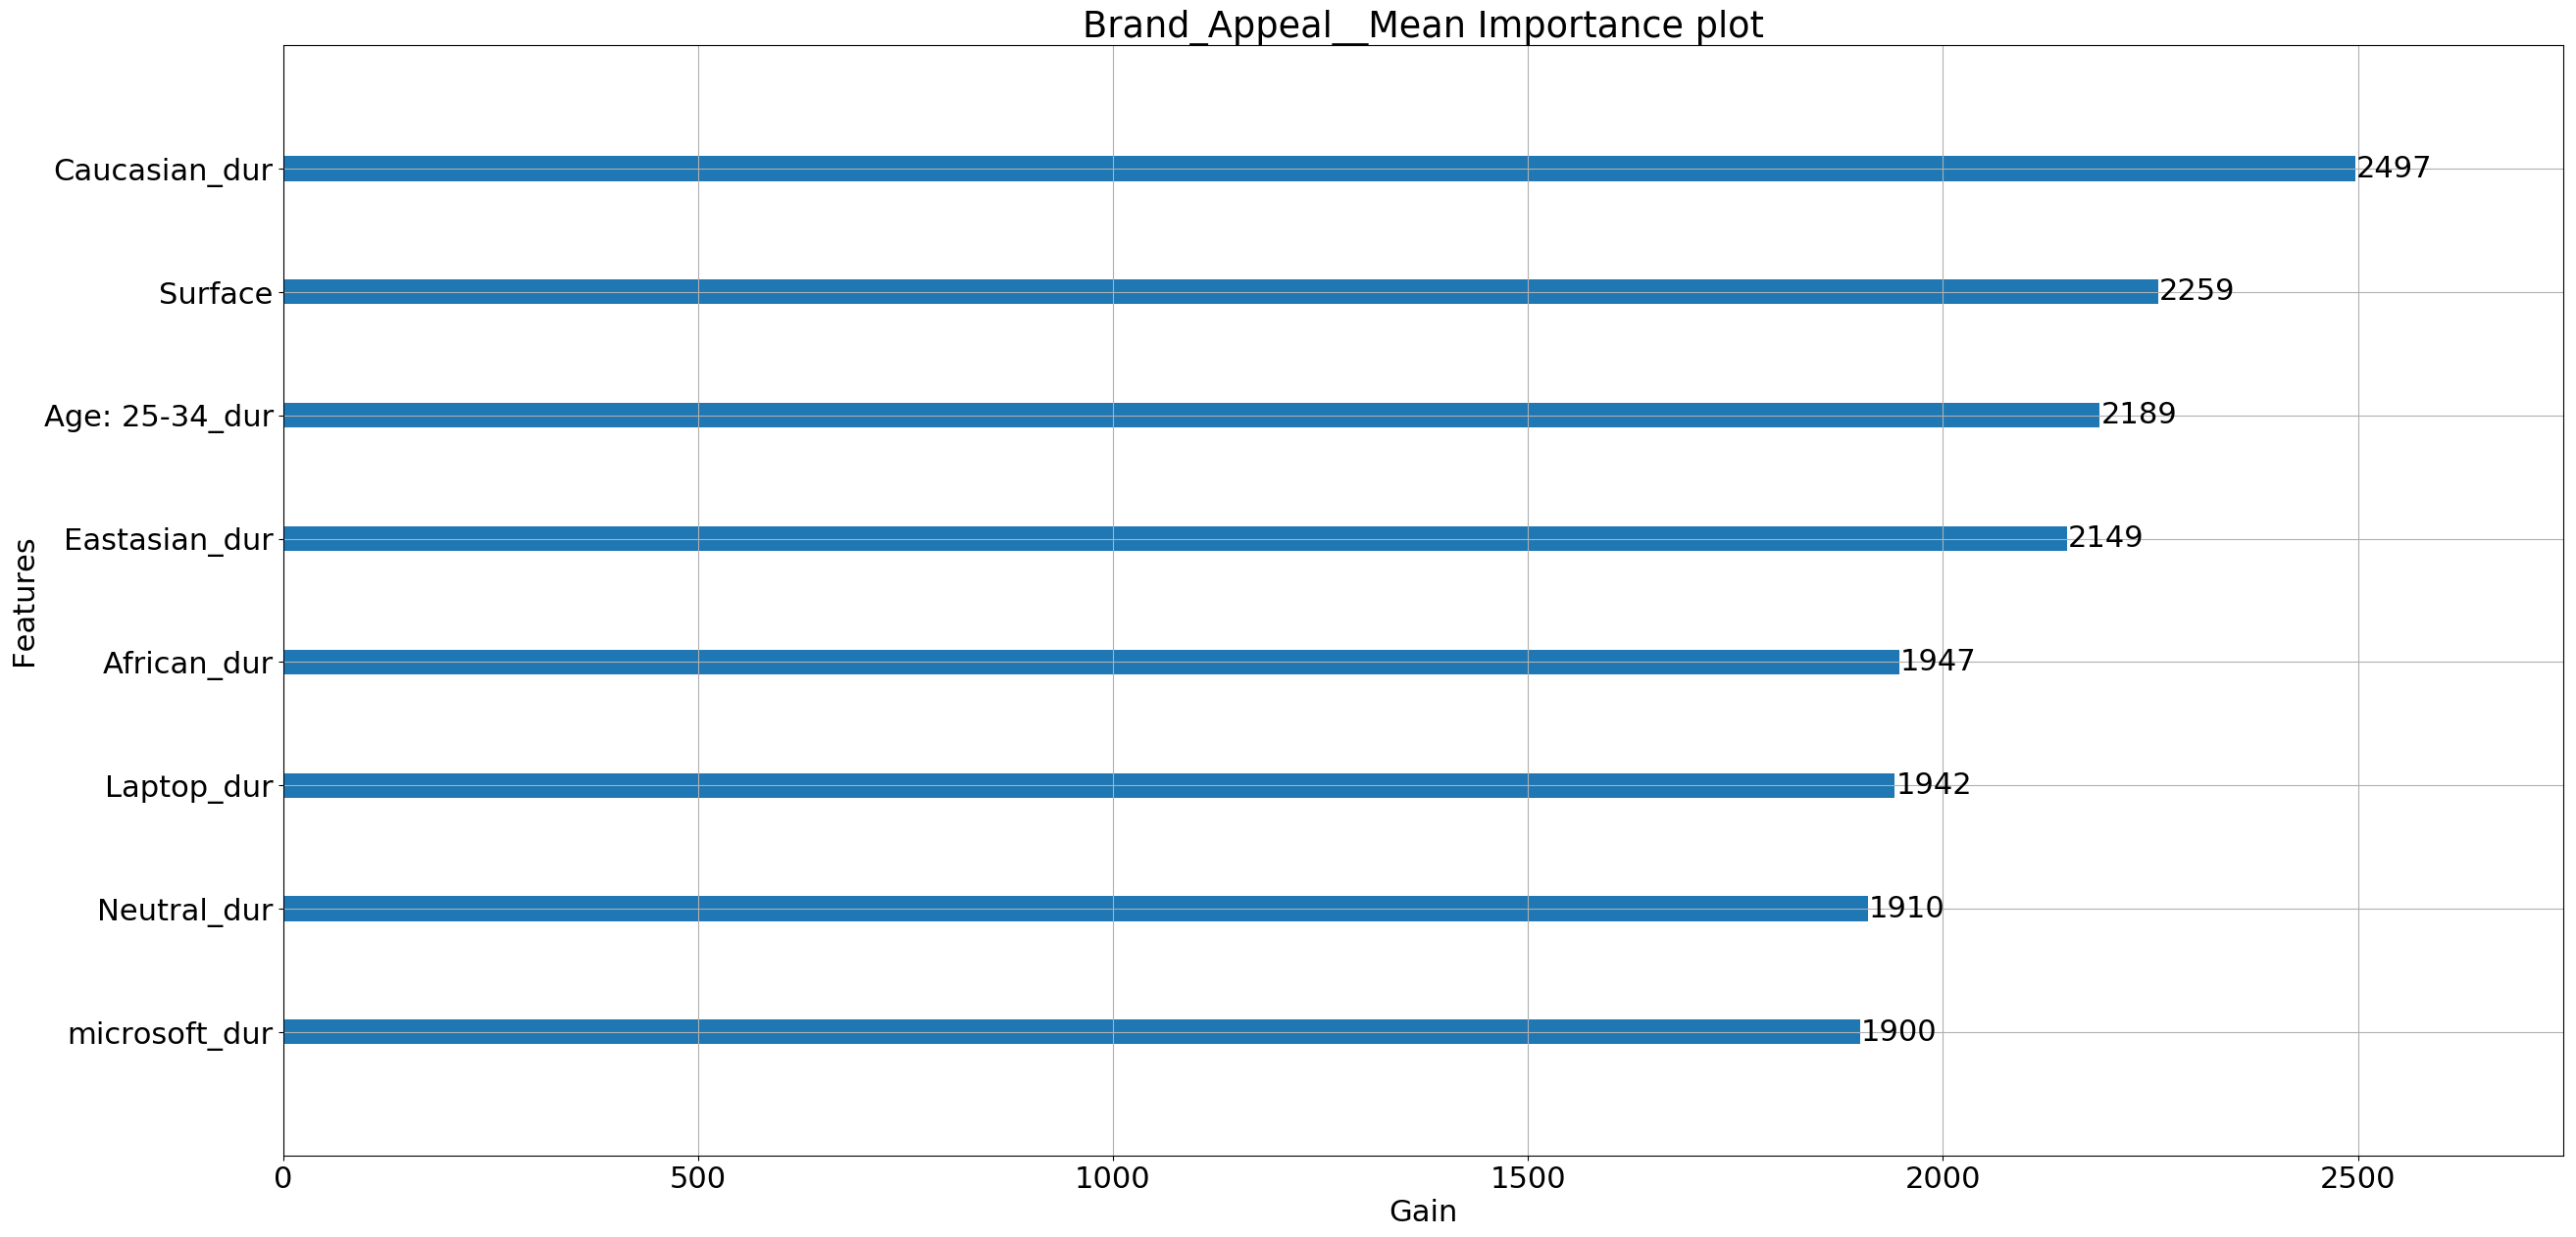

Understanding__Mean
Macbook_dur
African_dur
Laptop_first_ocr
Neutral_Male_dur
Surface
microsoft_last_ocr
Age: 35-44_dur
Tablet_dur
Happiness_Female_dur
Age: 35-44_Eastasian_dur
Neutral_dur
Age: 25-34_Caucasian_dur
Male_dur
microsoft_first_ocr
microsoft_dur
Tablet_total_ocr
Tablet_first_ocr
length_of_ad_15
Age: 25-34_dur
microsoft_total_ocr
Tablet_last_ocr
Sadness_dur
Laptop_dur
Happiness_Eastasian_dur
Caucasian_dur
Happiness_length_of_ad_impact
Female_dur
Laptop_last_ocr
Laptop_total_ocr
Age: 25-34_Eastasian_dur
Happiness_dur
Eastasian_dur
Neutral_Age: 25-34_dur
ASUS T102_dur
Surface_total_ocr
Dell_dur
Surface_last_ocr
Surface_first_ocr
Yoga_dur
Windows_dur
Lenovo_dur
HP_dur
Surface_dur


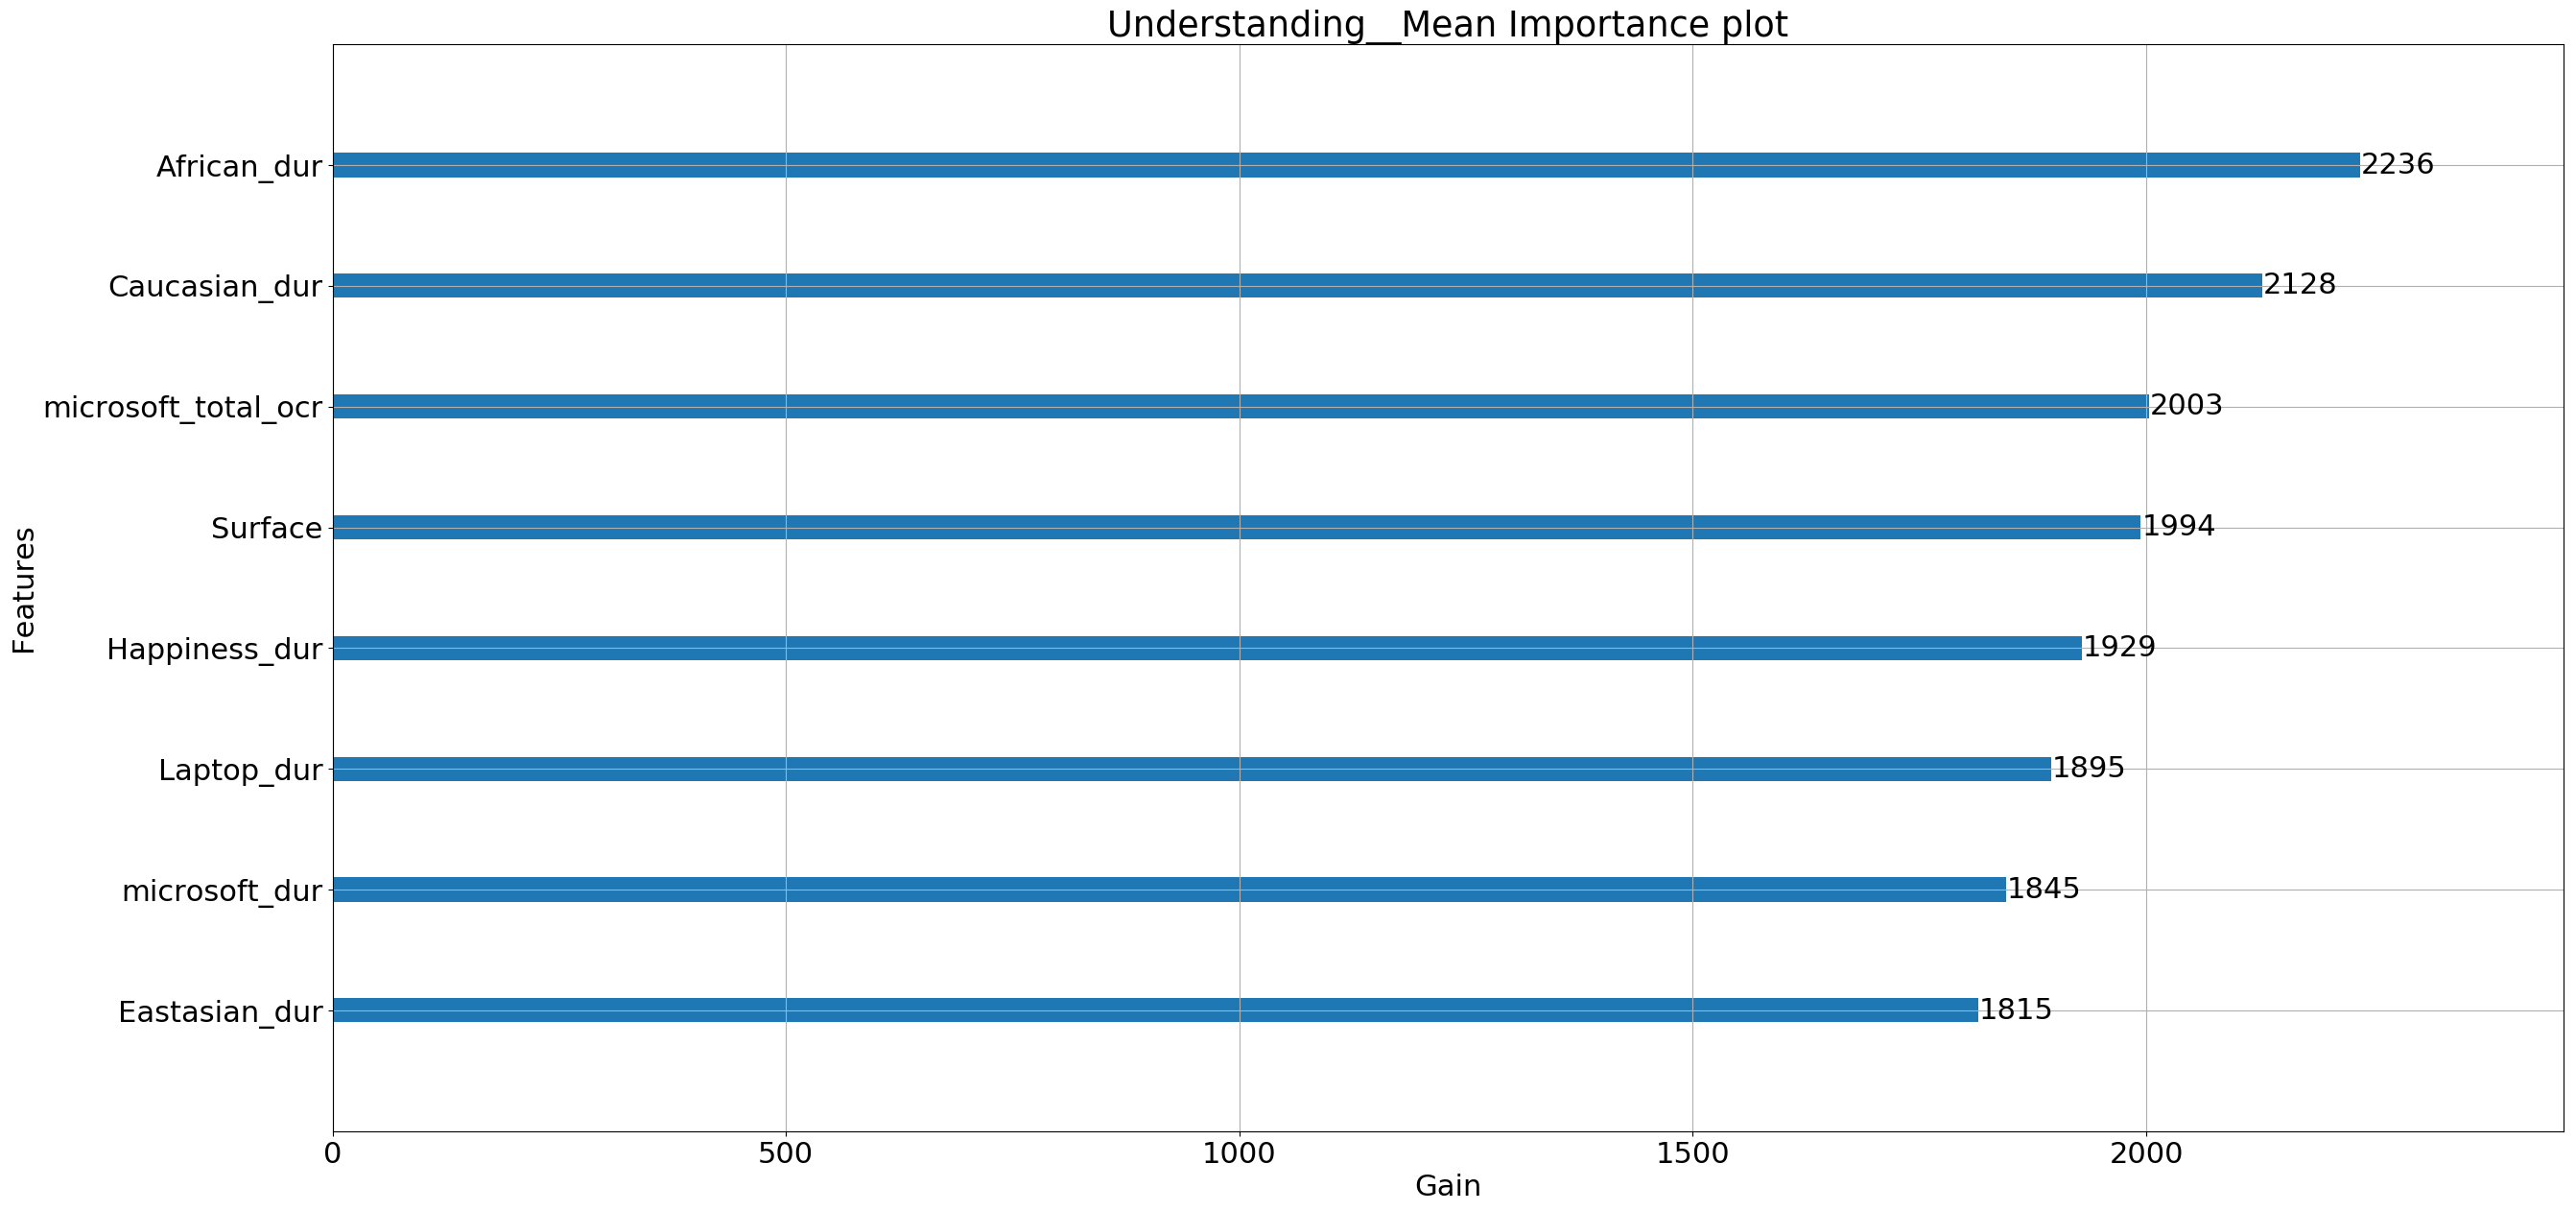

Relevance_of_Information__Mean
length_of_ad_15
Male_dur
Laptop_total_ocr
microsoft_total_ocr
microsoft_last_ocr
Tablet_last_ocr
Tablet_dur
Macbook_dur
Laptop_first_ocr
Happiness_length_of_ad_impact
African_dur
Tablet_total_ocr
Tablet_first_ocr
Surface
Age: 25-34_dur
Laptop_last_ocr
Neutral_Male_dur
Caucasian_dur
Age: 25-34_Eastasian_dur
Neutral_dur
Age: 35-44_dur
Happiness_Female_dur
microsoft_first_ocr
Happiness_dur
Laptop_dur
Happiness_Eastasian_dur
Neutral_Age: 25-34_dur
Age: 25-34_Caucasian_dur
Age: 35-44_Eastasian_dur
microsoft_dur
Female_dur
Eastasian_dur
Sadness_dur
Surface_total_ocr
Surface_first_ocr
Surface_last_ocr
Lenovo_dur
Yoga_dur
Windows_dur
ASUS T102_dur
Dell_dur
HP_dur
Surface_dur


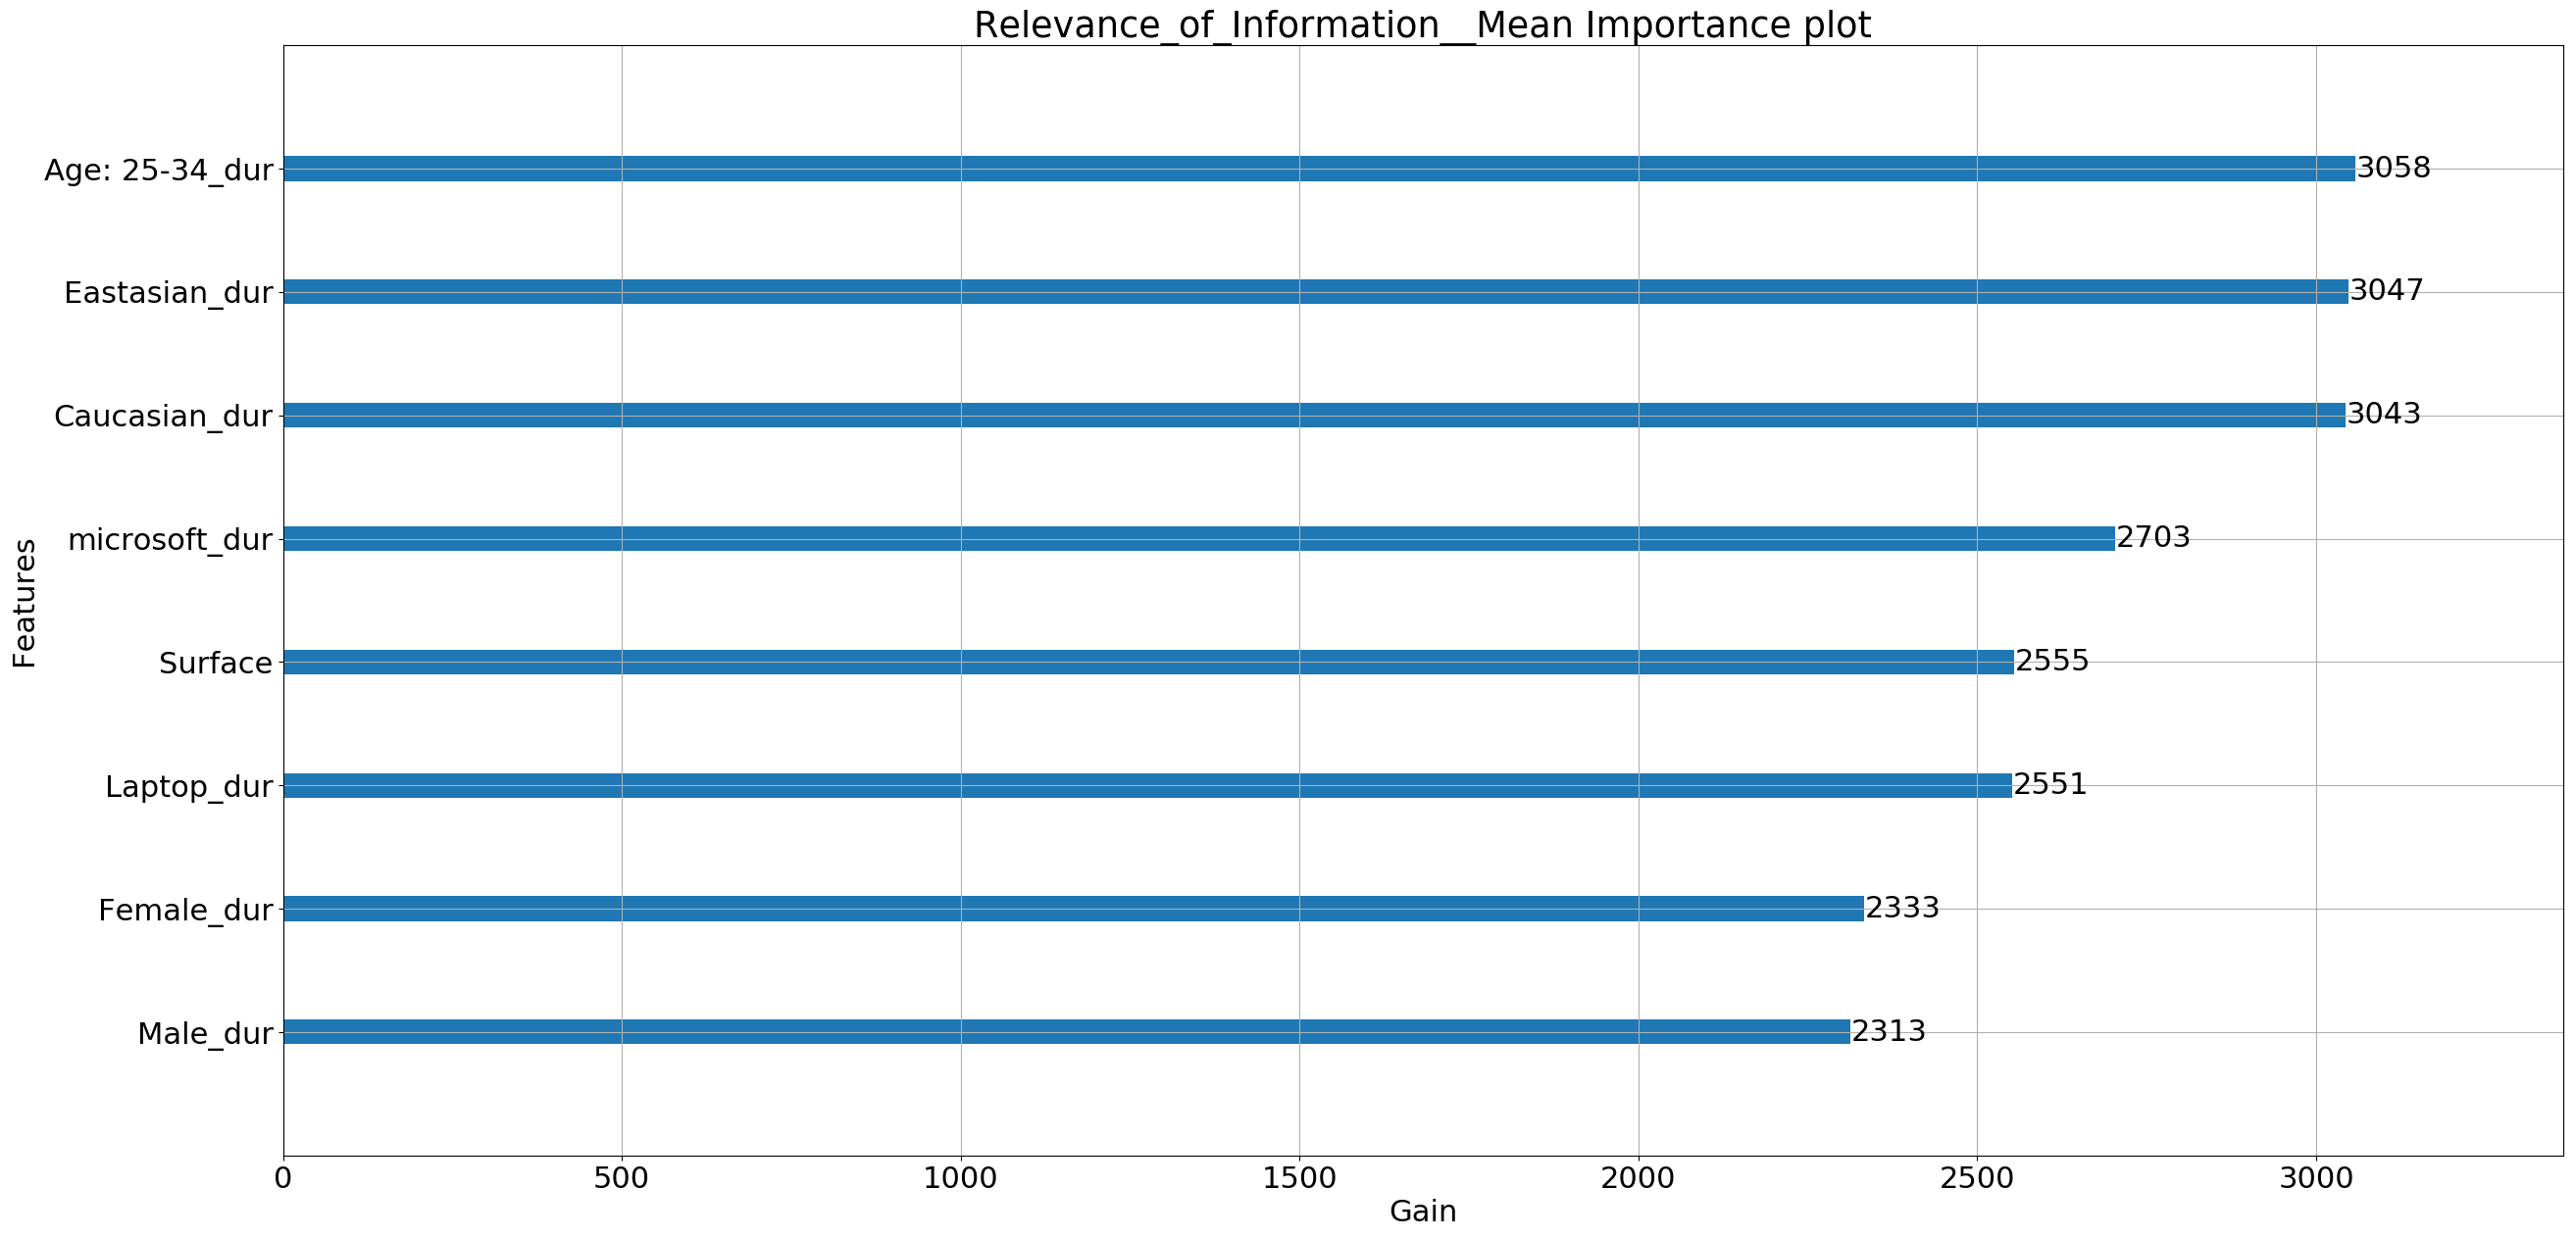

Credibility_of_Information__Mean
Macbook_dur
Male_dur
microsoft_total_ocr
length_of_ad_15
Age: 25-34_Eastasian_dur
Tablet_last_ocr
Tablet_total_ocr
Tablet_dur
Tablet_first_ocr
Laptop_first_ocr
Surface
Happiness_Female_dur
Happiness_length_of_ad_impact
microsoft_first_ocr
Happiness_Eastasian_dur
Laptop_last_ocr
Age: 25-34_Caucasian_dur
Neutral_dur
microsoft_last_ocr
African_dur
Laptop_dur
Neutral_Male_dur
Neutral_Age: 25-34_dur
Caucasian_dur
Laptop_total_ocr
Age: 35-44_Eastasian_dur
microsoft_dur
Age: 25-34_dur
Female_dur
Happiness_dur
Age: 35-44_dur
Eastasian_dur
Sadness_dur
Windows_dur
Yoga_dur
Surface_total_ocr
Surface_last_ocr
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Surface_first_ocr
Surface_dur


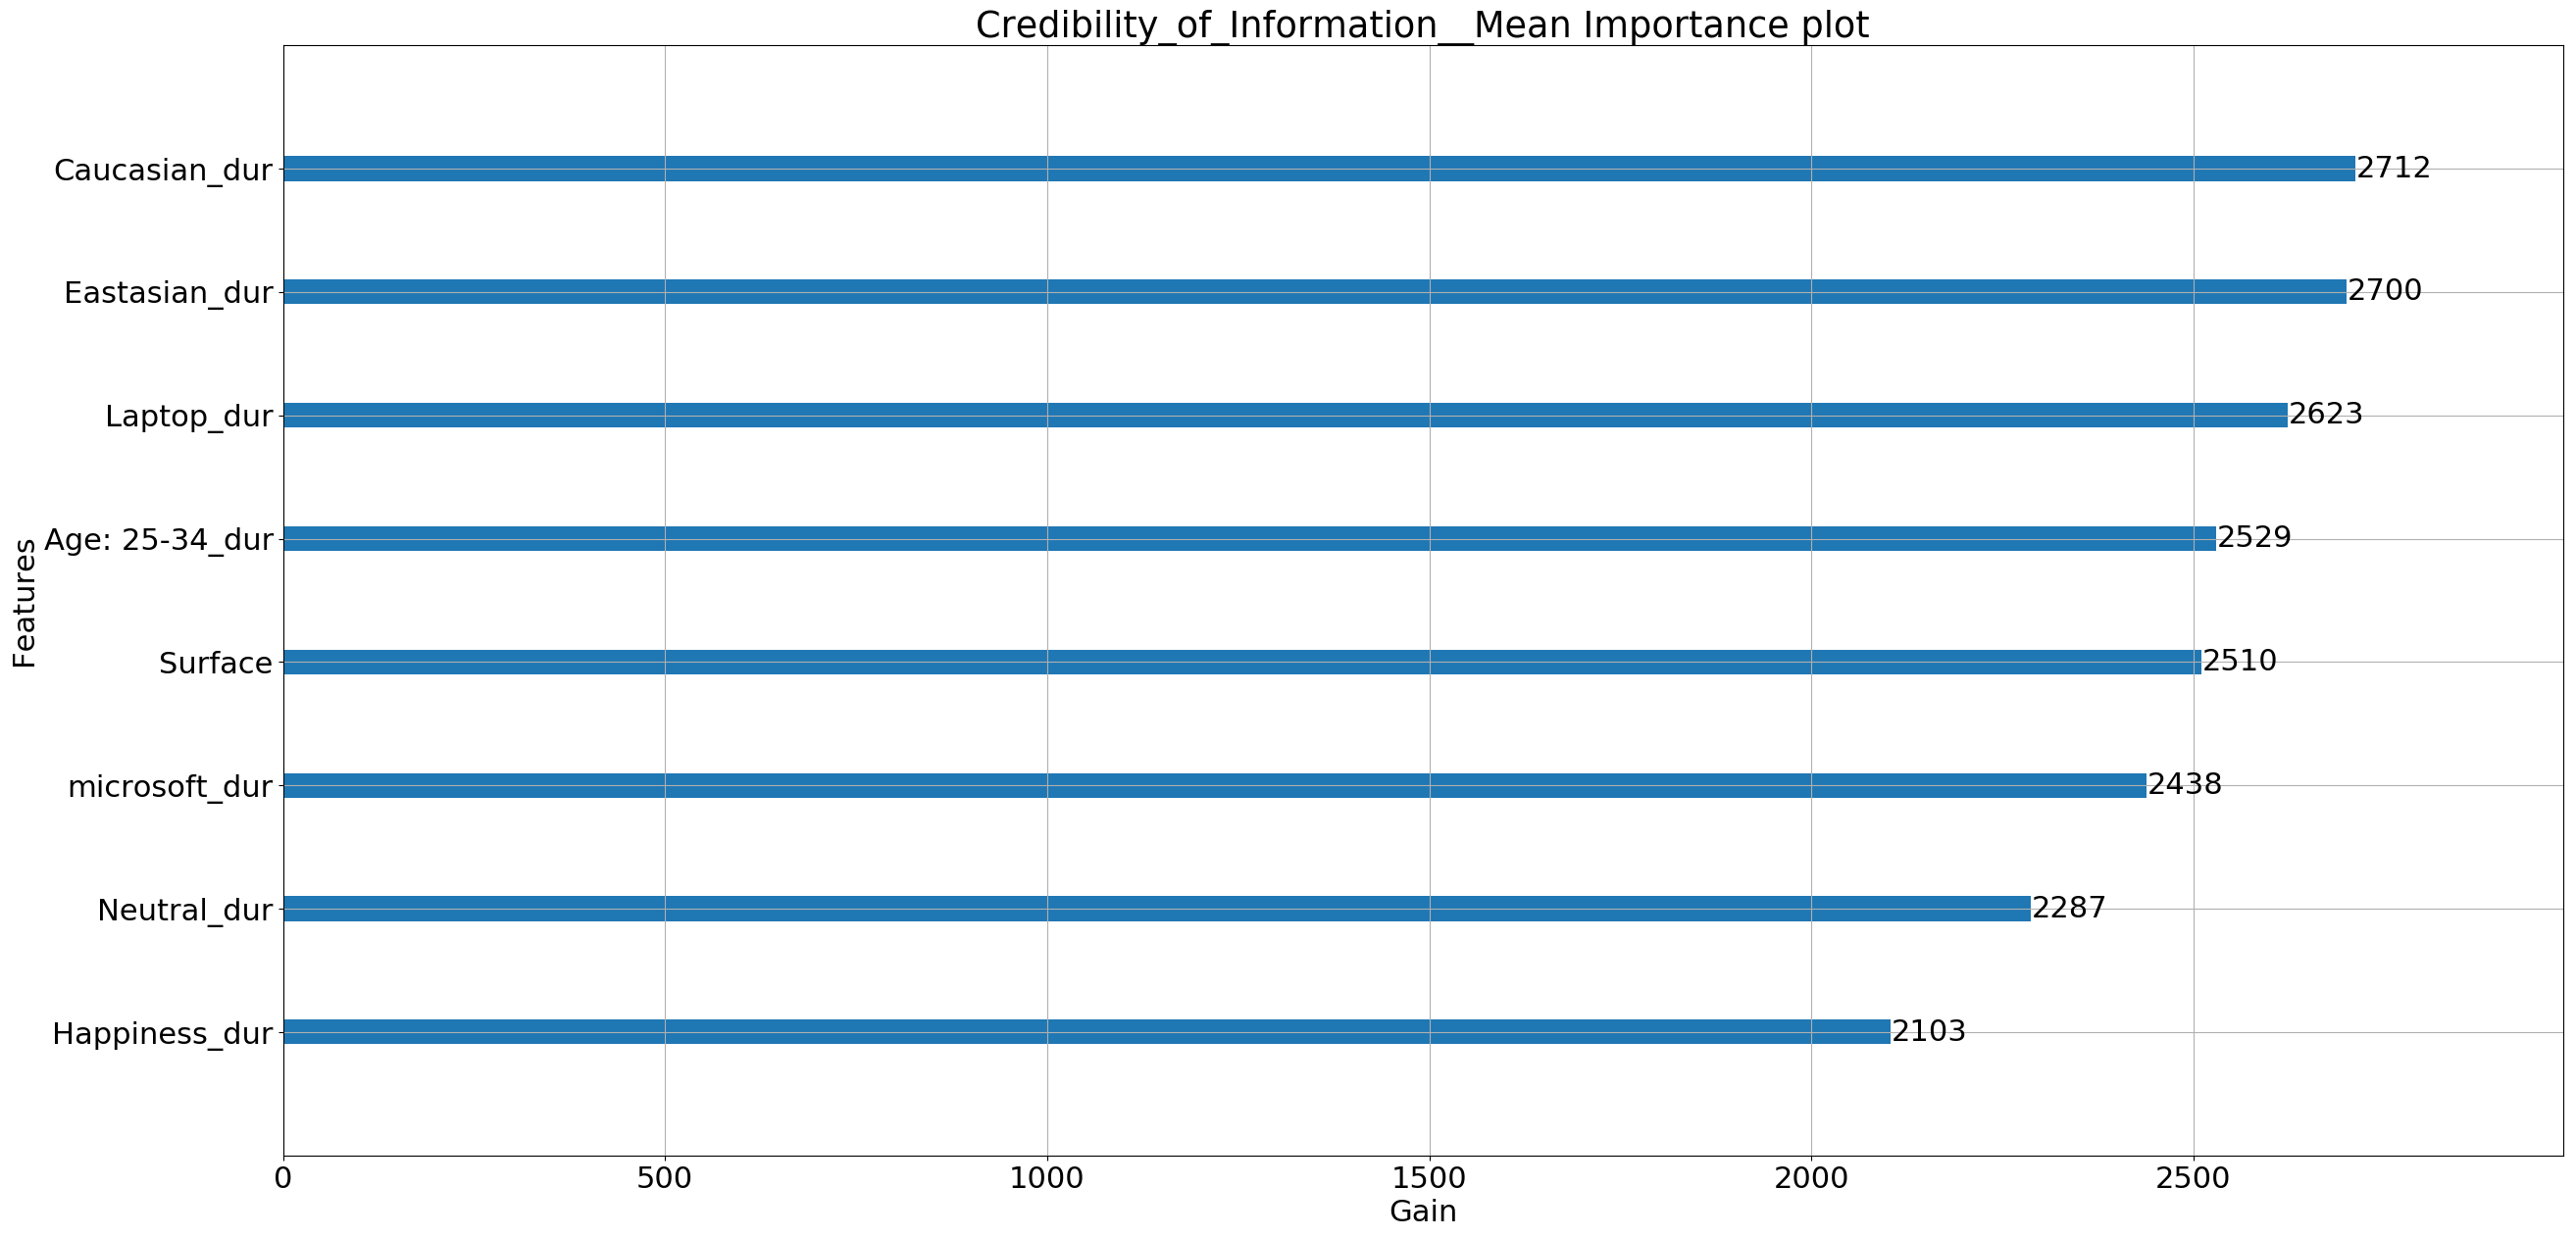

Brand_Difference__Mean
length_of_ad_15
Macbook_dur
microsoft_last_ocr
Tablet_first_ocr
Laptop_last_ocr
Tablet_last_ocr
Age: 25-34_dur
African_dur
Tablet_total_ocr
Happiness_length_of_ad_impact
Age: 35-44_Eastasian_dur
Happiness_Female_dur
microsoft_total_ocr
Laptop_total_ocr
Neutral_dur
Tablet_dur
Neutral_Male_dur
microsoft_first_ocr
Age: 25-34_Eastasian_dur
Laptop_first_ocr
microsoft_dur
Surface
Laptop_dur
Happiness_Eastasian_dur
Age: 25-34_Caucasian_dur
Age: 35-44_dur
Caucasian_dur
Male_dur
Happiness_dur
Neutral_Age: 25-34_dur
Female_dur
Eastasian_dur
Sadness_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


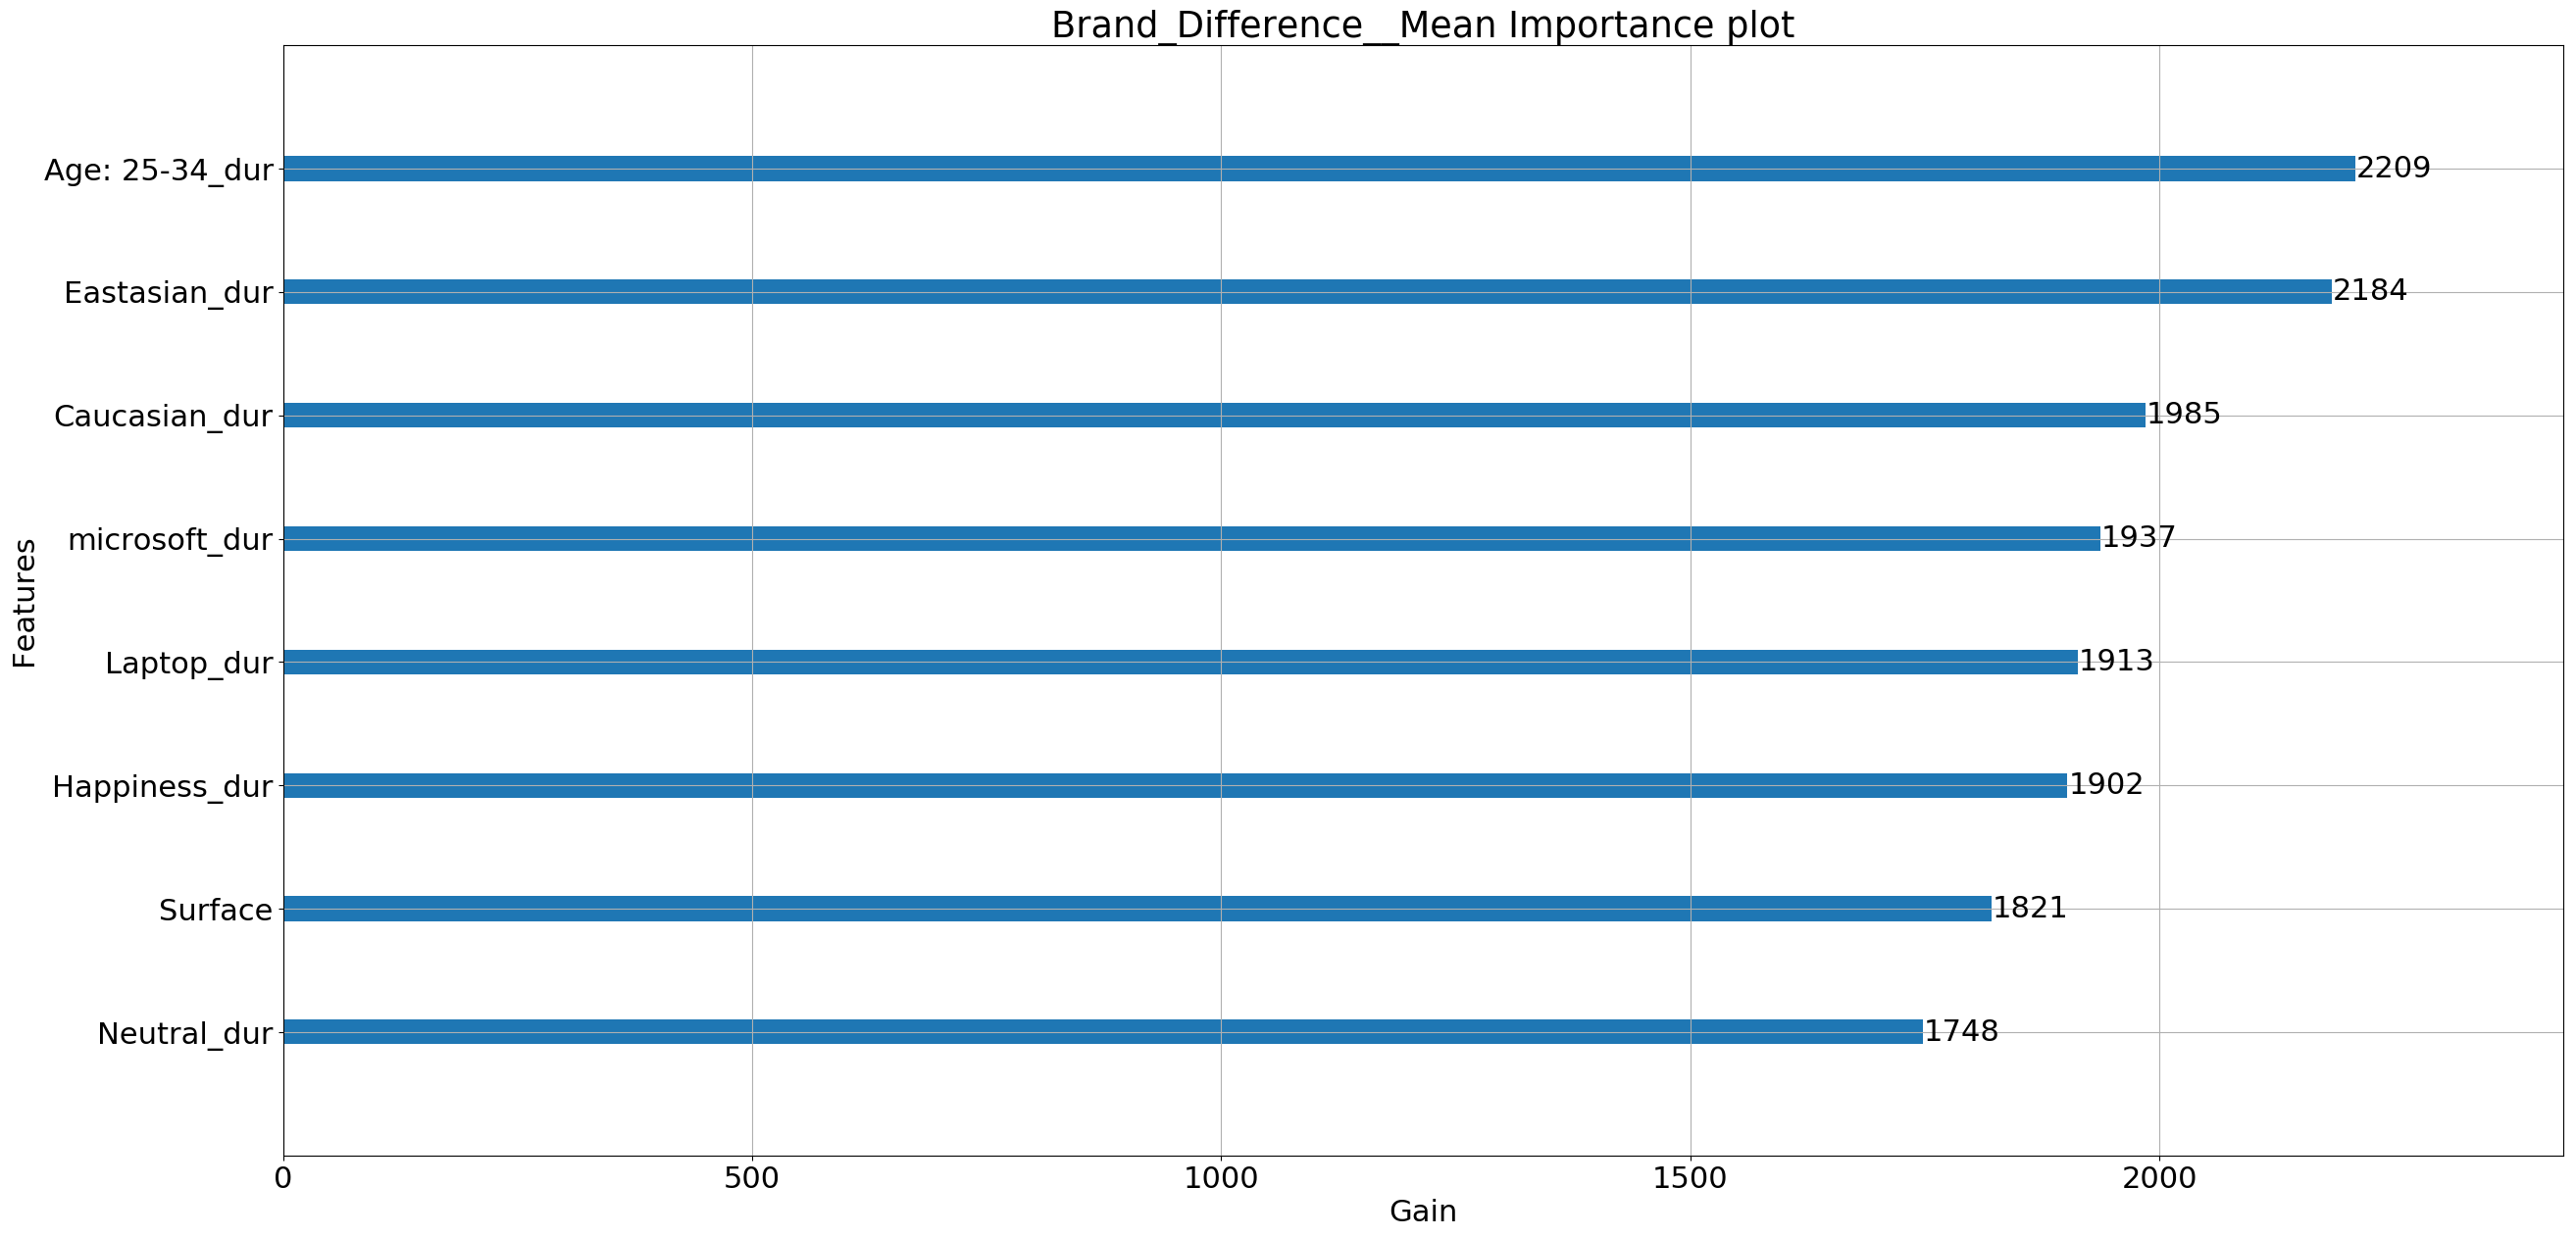

Interest_peak
Tablet_last_ocr
length_of_ad_15
Laptop_total_ocr
Surface
Tablet_total_ocr
microsoft_first_ocr
Happiness_length_of_ad_impact
microsoft_last_ocr
Happiness_Female_dur
Laptop_last_ocr
Age: 25-34_Eastasian_dur
Tablet_dur
Laptop_first_ocr
Sadness_dur
Laptop_dur
Tablet_first_ocr
Female_dur
microsoft_total_ocr
Neutral_dur
Age: 25-34_dur
Happiness_dur
Male_dur
Macbook_dur
Happiness_Eastasian_dur
African_dur
microsoft_dur
Age: 35-44_Eastasian_dur
Neutral_Age: 25-34_dur
Age: 25-34_Caucasian_dur
Neutral_Male_dur
Age: 35-44_dur
Eastasian_dur
Caucasian_dur
Dell_dur
Surface_total_ocr
Surface_last_ocr
ASUS T102_dur
Surface_first_ocr
Yoga_dur
Windows_dur
Lenovo_dur
HP_dur
Surface_dur


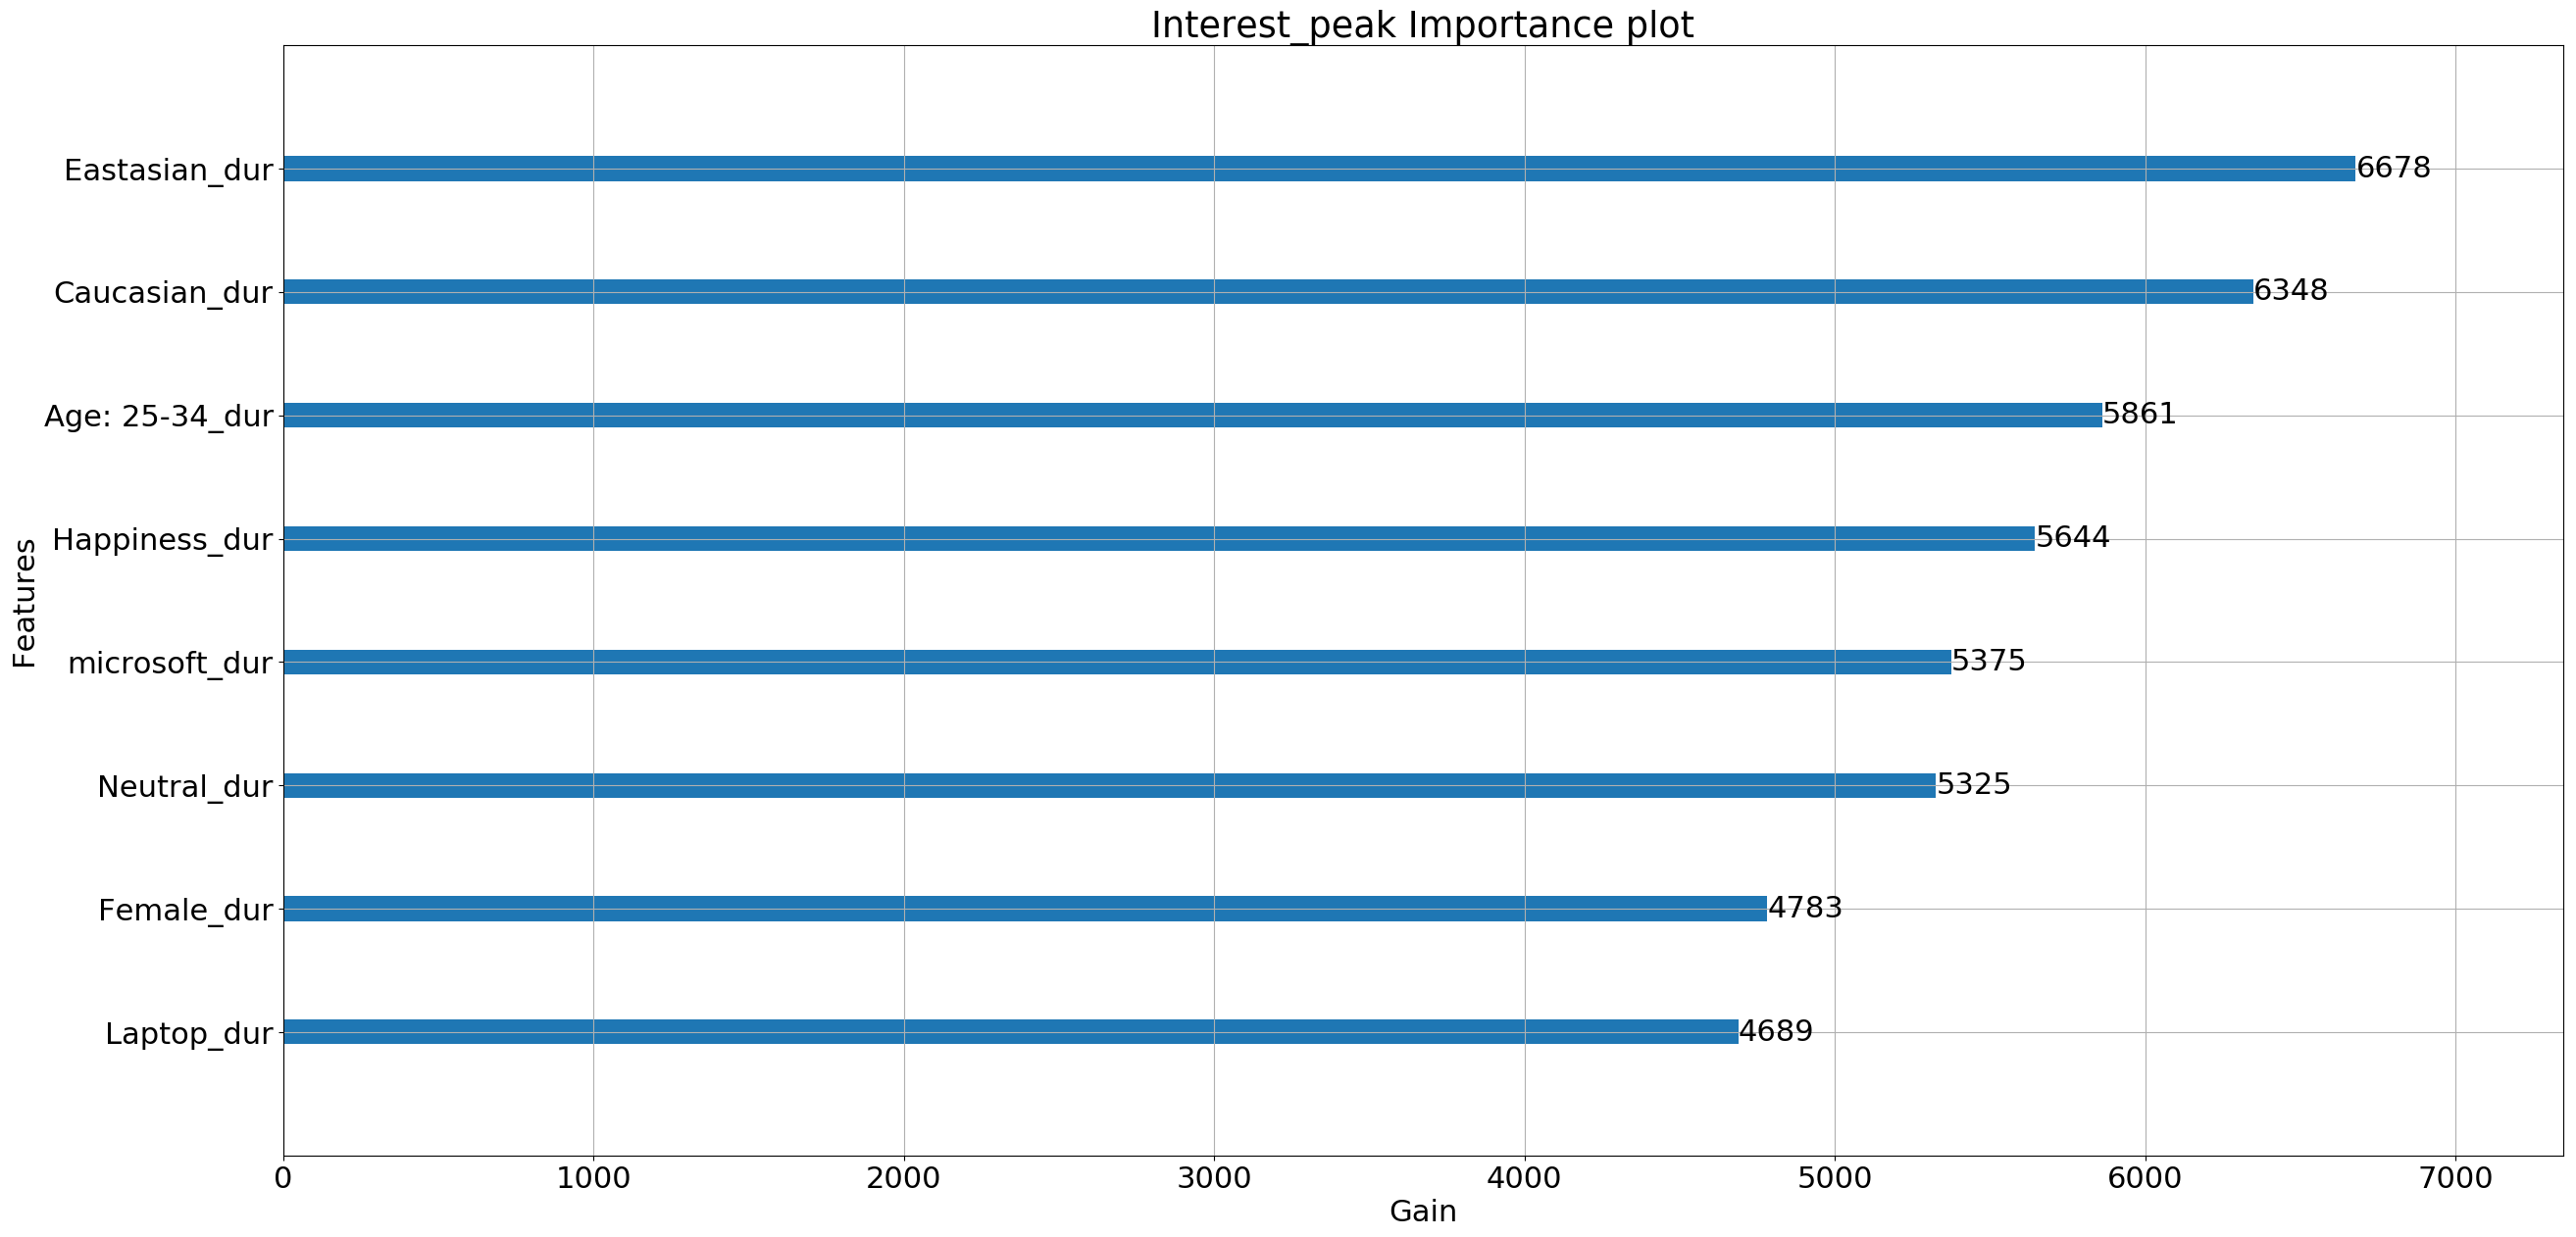

Interest_mean_score
length_of_ad_15
microsoft_last_ocr
Tablet_last_ocr
Laptop_last_ocr
microsoft_first_ocr
Age: 25-34_Caucasian_dur
Neutral_Age: 25-34_dur
Tablet_dur
Neutral_Male_dur
Laptop_dur
Age: 25-34_dur
Happiness_Female_dur
microsoft_dur
Macbook_dur
Happiness_length_of_ad_impact
microsoft_total_ocr
Tablet_first_ocr
Happiness_dur
Surface
Male_dur
Neutral_dur
Laptop_total_ocr
Tablet_total_ocr
Caucasian_dur
Laptop_first_ocr
Happiness_Eastasian_dur
Age: 25-34_Eastasian_dur
Sadness_dur
Female_dur
Age: 35-44_Eastasian_dur
African_dur
Eastasian_dur
Age: 35-44_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


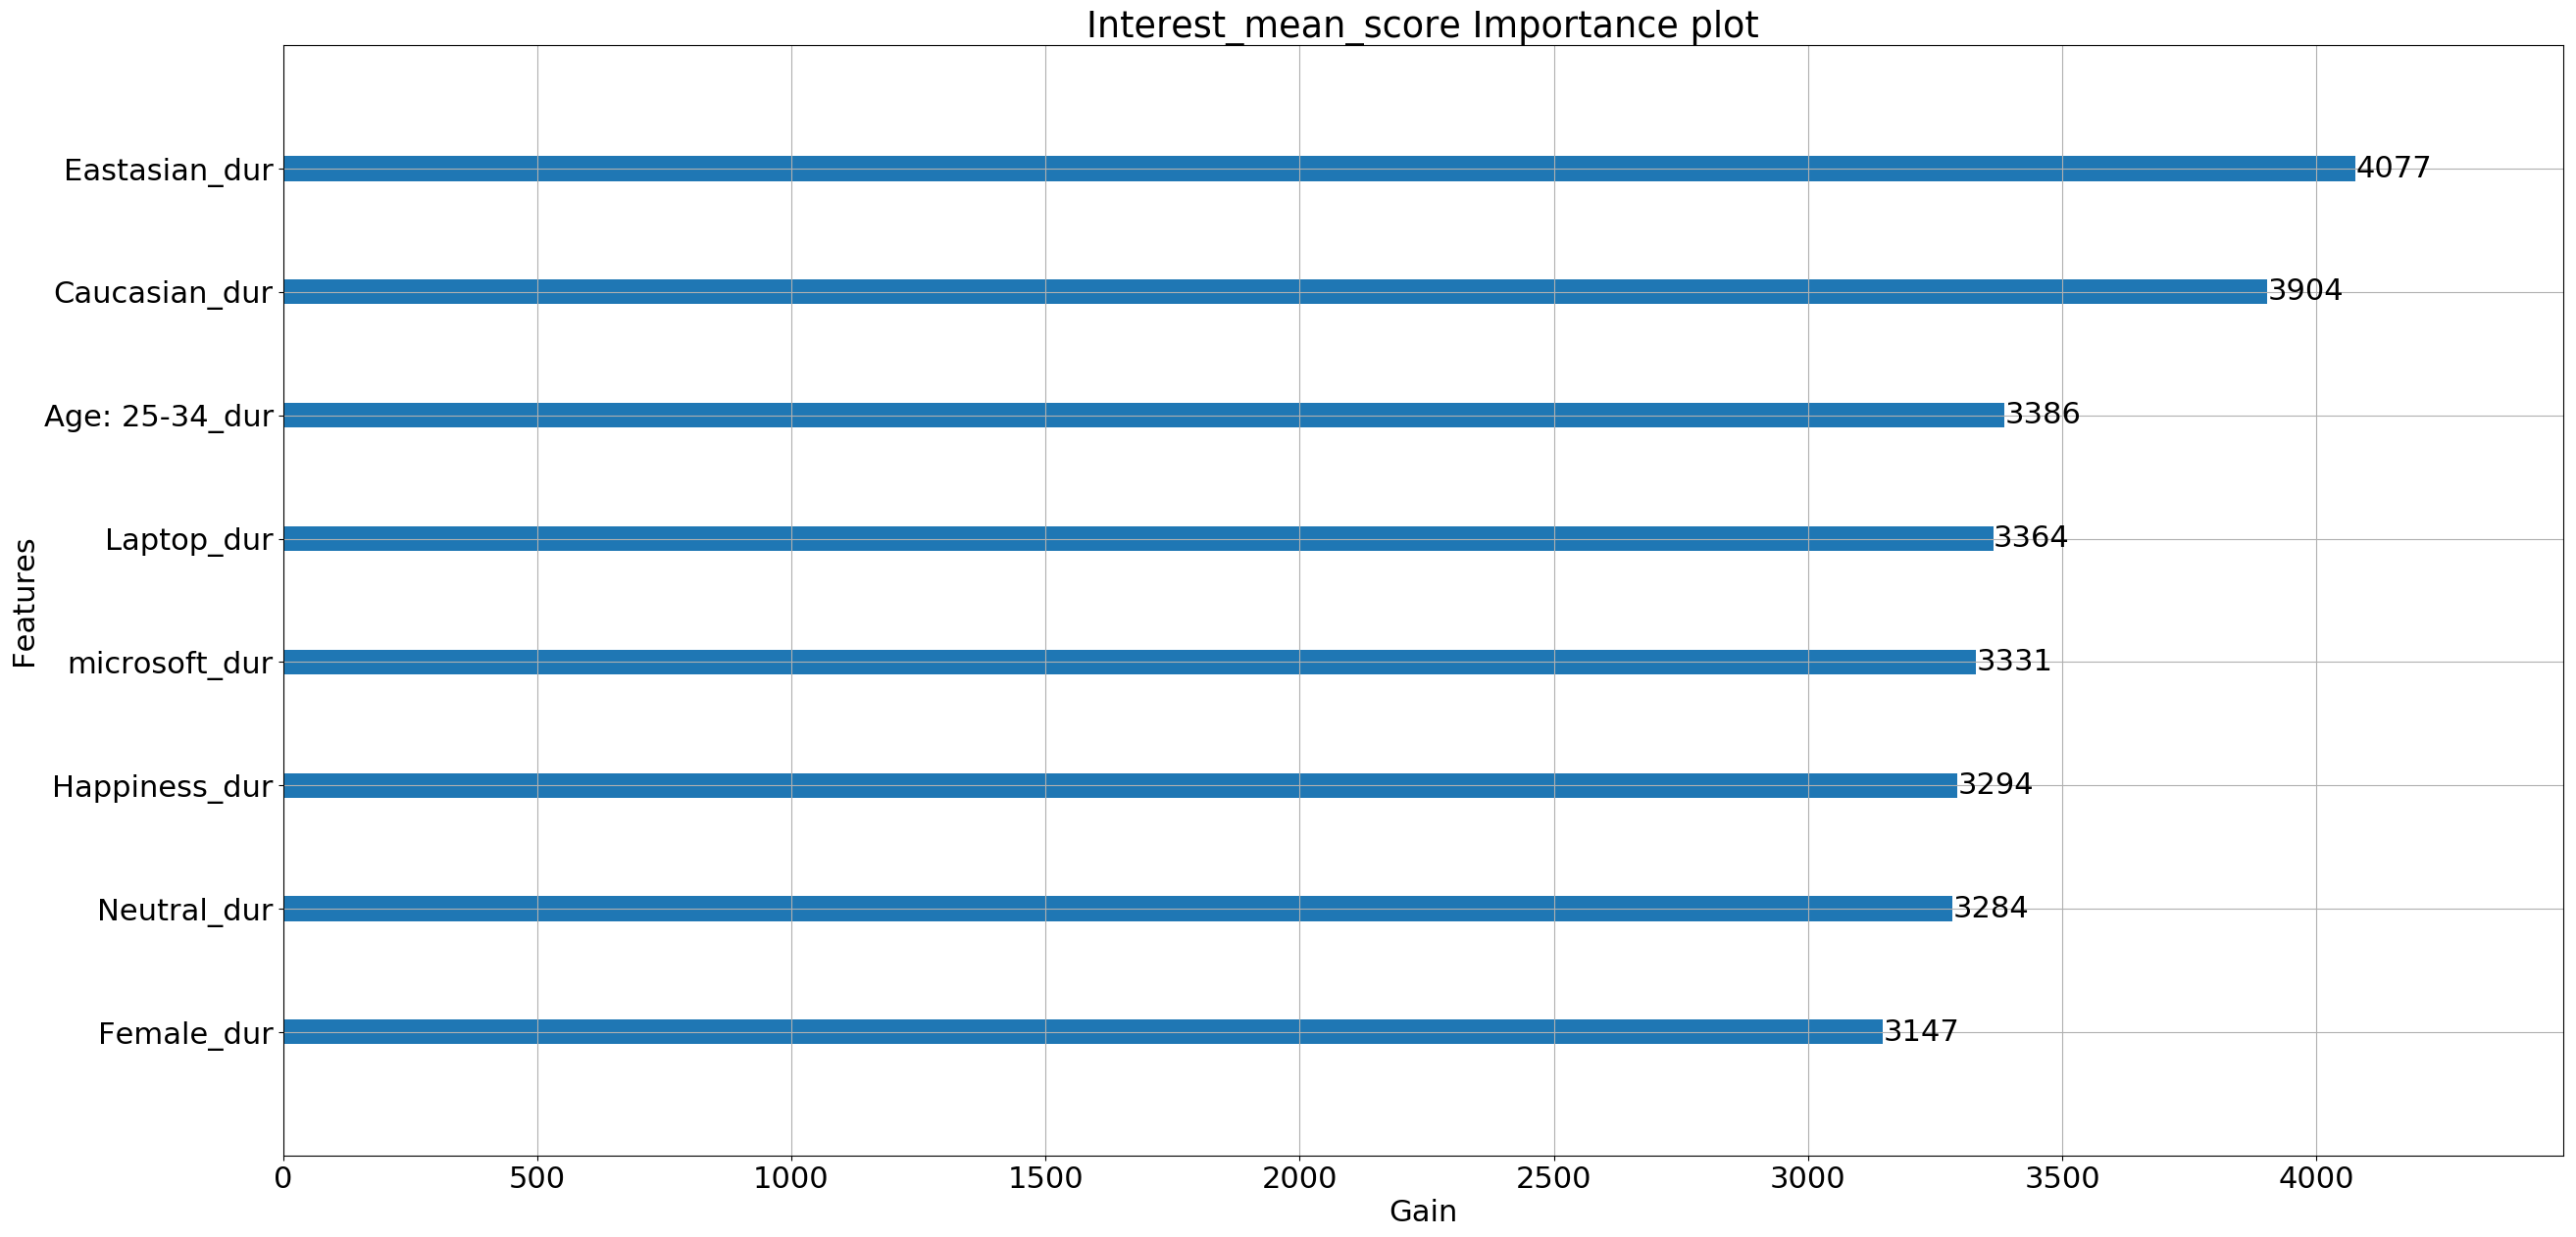

Purchase_intent
microsoft_first_ocr
Tablet_total_ocr
length_of_ad_15
Happiness_length_of_ad_impact
Tablet_dur
microsoft_total_ocr
Laptop_total_ocr
Tablet_last_ocr
microsoft_last_ocr
Tablet_first_ocr
Laptop_last_ocr
Laptop_dur
Laptop_first_ocr
Surface
Age: 35-44_Eastasian_dur
Age: 25-34_Eastasian_dur
Neutral_dur
Happiness_Female_dur
Age: 35-44_dur
microsoft_dur
Neutral_Male_dur
Happiness_dur
Male_dur
Female_dur
Age: 25-34_dur
Age: 25-34_Caucasian_dur
African_dur
Sadness_dur
Caucasian_dur
Happiness_Eastasian_dur
Macbook_dur
Neutral_Age: 25-34_dur
Eastasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


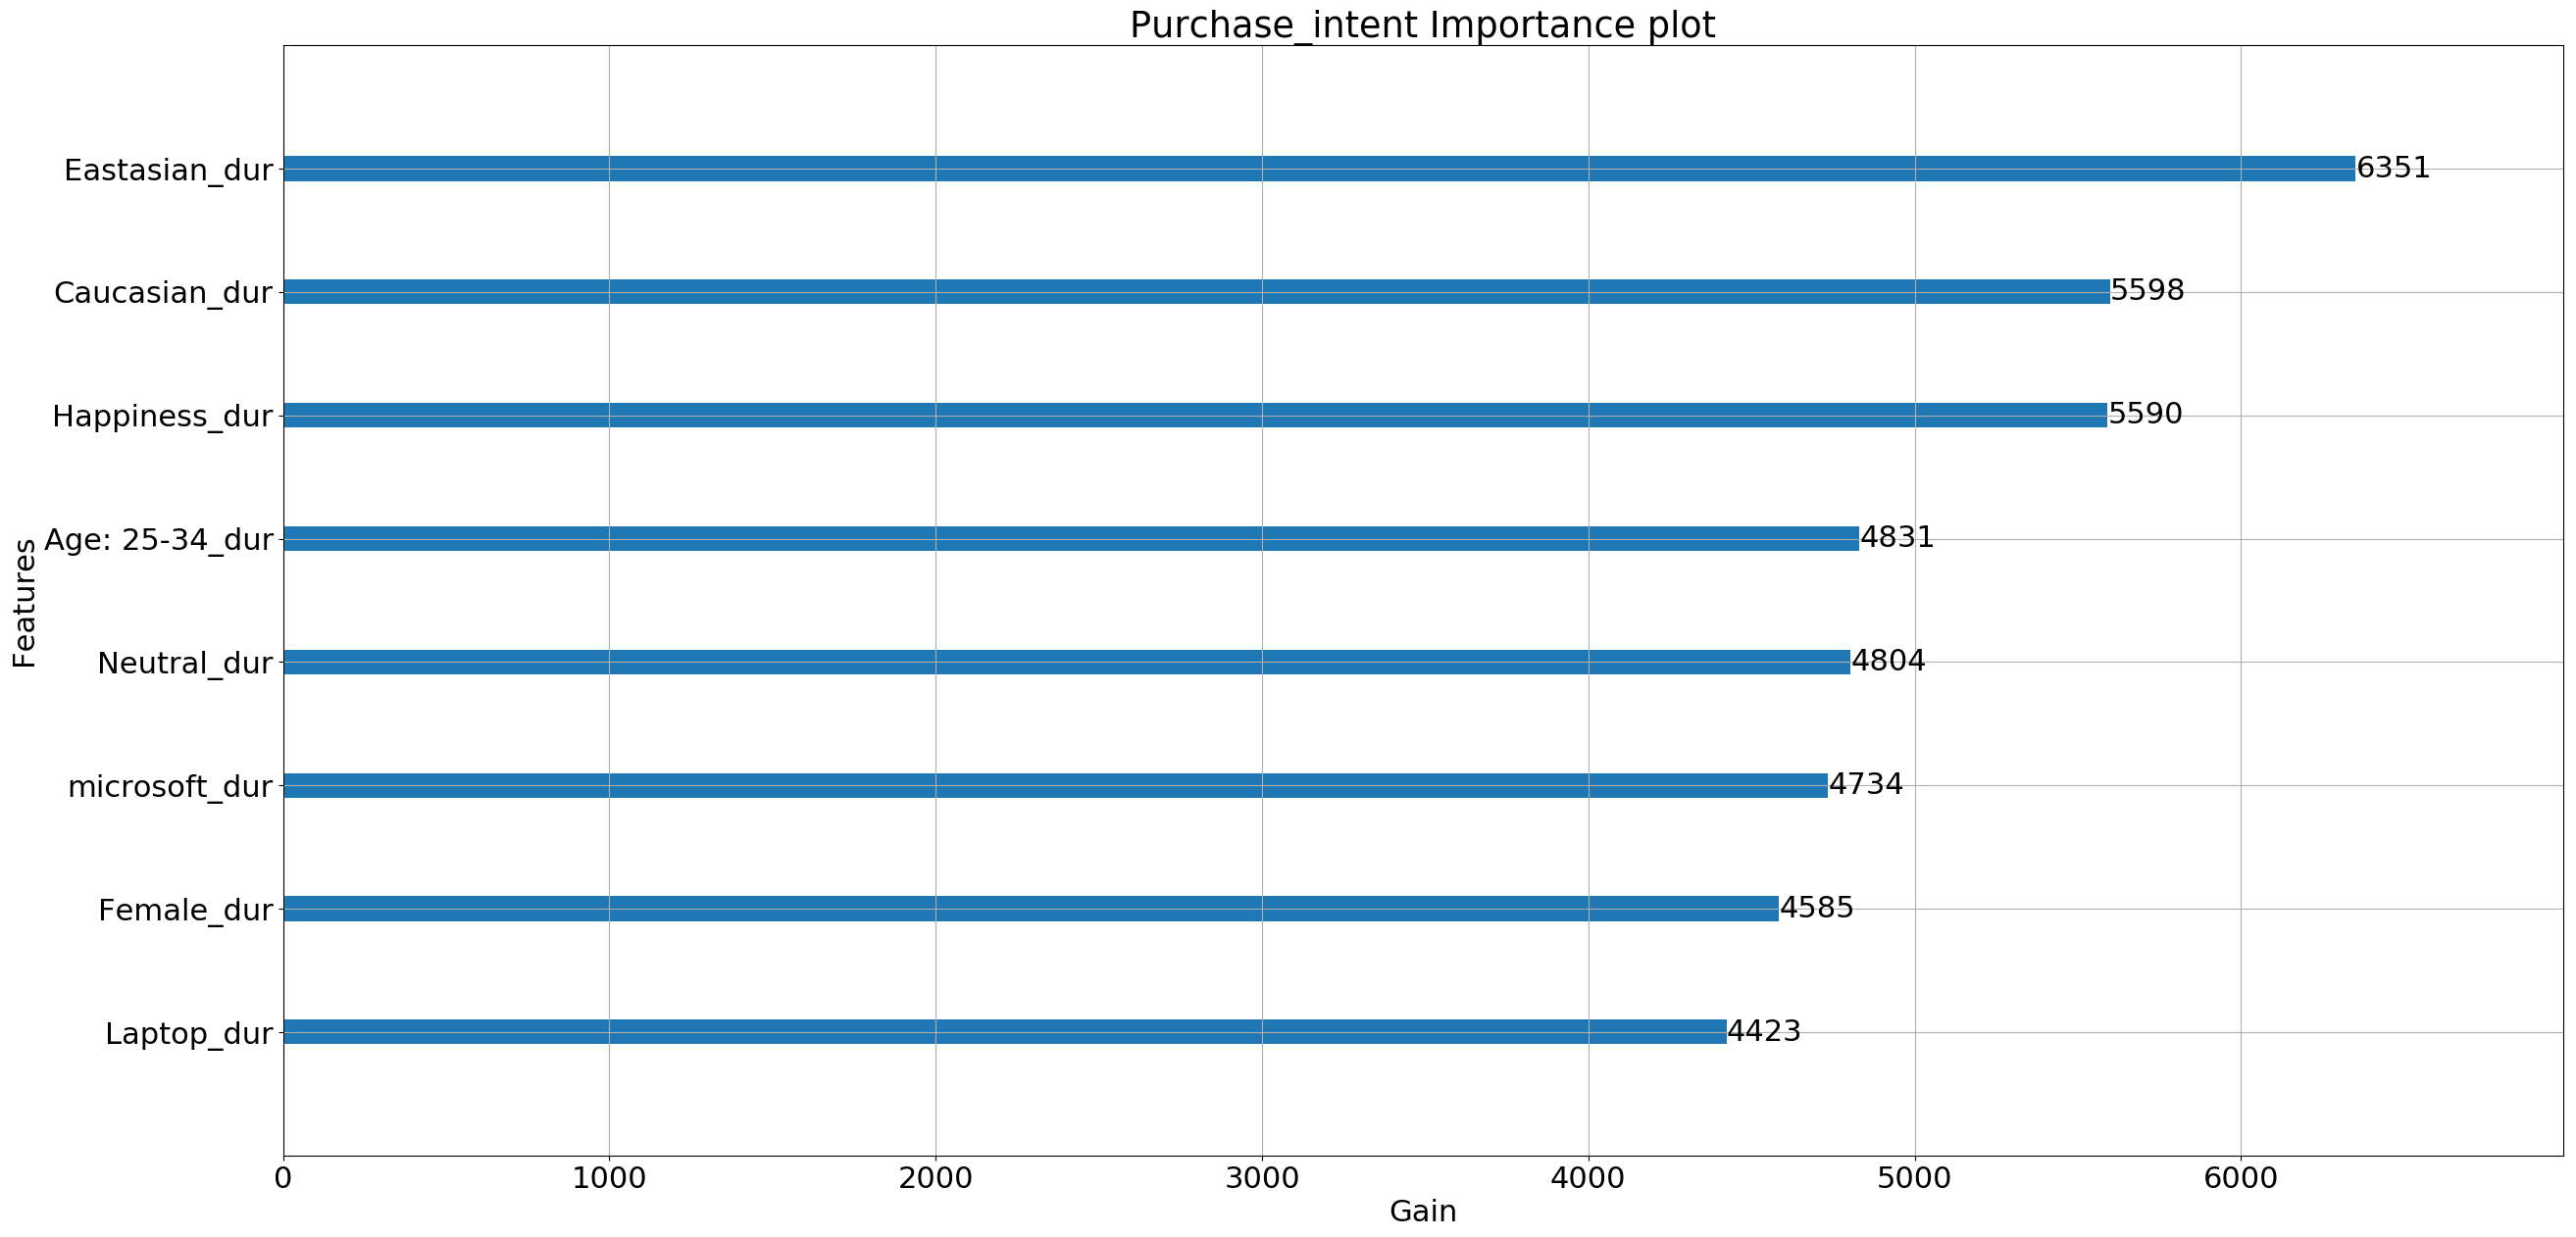

Persuasion_mean
Age: 25-34_Eastasian_dur
microsoft_first_ocr
length_of_ad_15
microsoft_total_ocr
Tablet_dur
Laptop_last_ocr
Laptop_first_ocr
Tablet_total_ocr
Laptop_dur
Tablet_first_ocr
Surface
Happiness_length_of_ad_impact
Laptop_total_ocr
Caucasian_dur
microsoft_dur
Age: 25-34_Caucasian_dur
Age: 25-34_dur
Tablet_last_ocr
Neutral_dur
Female_dur
Neutral_Age: 25-34_dur
Male_dur
Age: 35-44_Eastasian_dur
microsoft_last_ocr
Eastasian_dur
Happiness_dur
Age: 35-44_dur
Sadness_dur
African_dur
Happiness_Eastasian_dur
Neutral_Male_dur
Happiness_Female_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


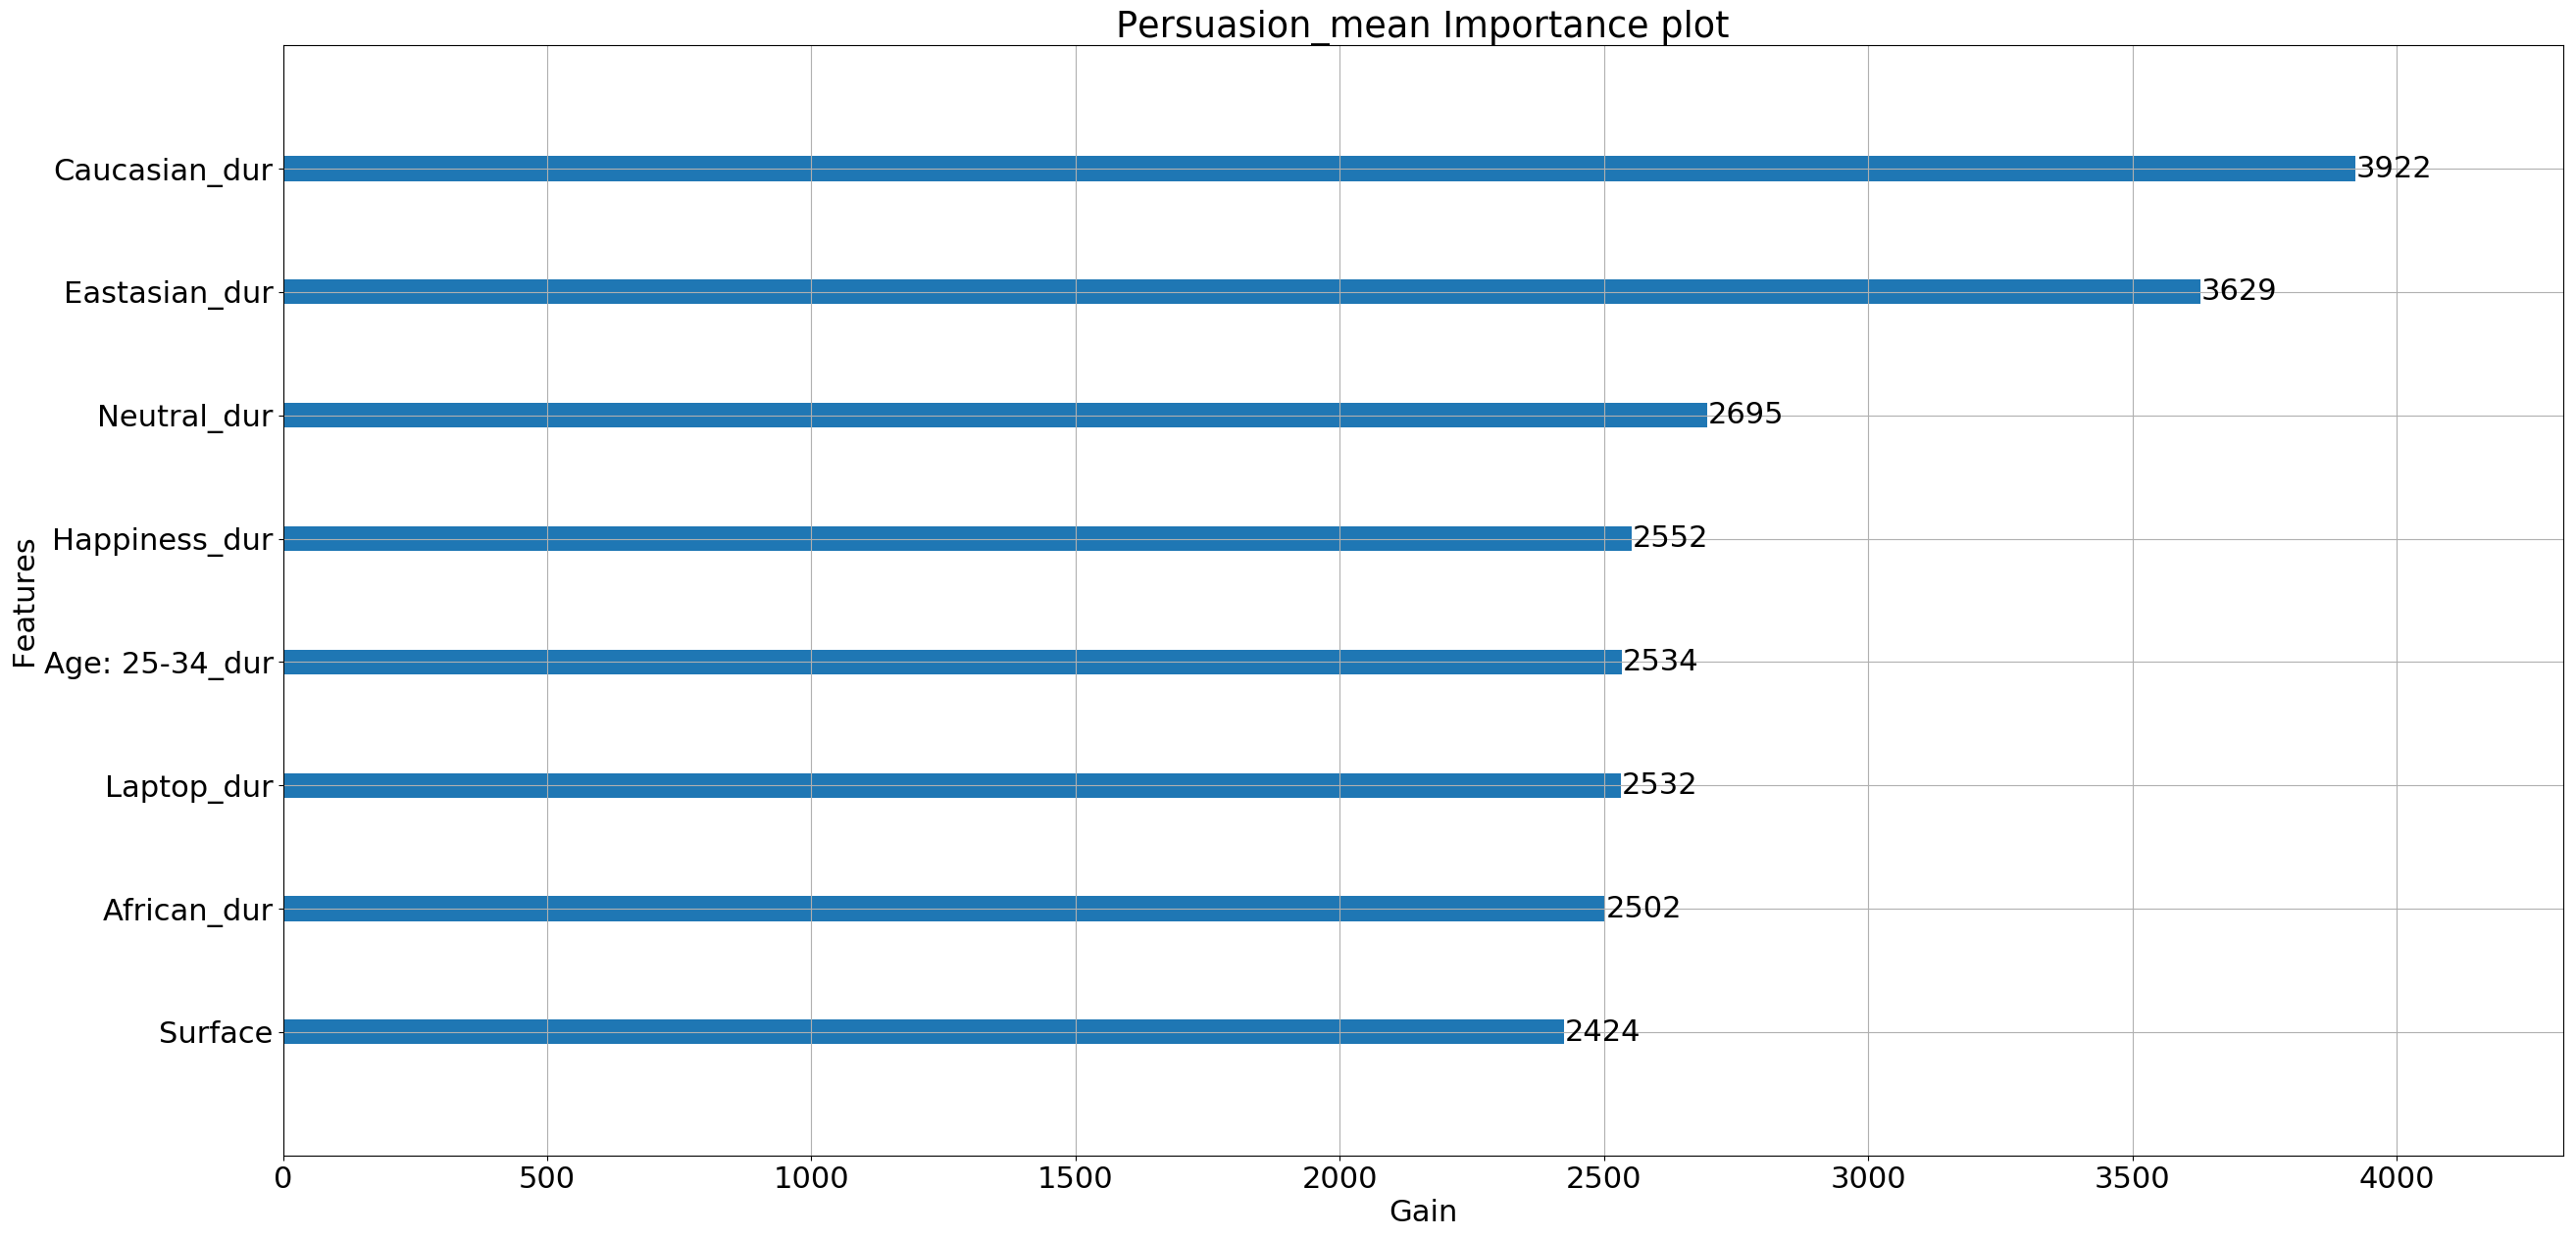

Persuasion_very_likely
Age: 25-34_Eastasian_dur
length_of_ad_15
microsoft_first_ocr
microsoft_total_ocr
Tablet_dur
Tablet_total_ocr
Laptop_last_ocr
Laptop_dur
Laptop_first_ocr
Age: 25-34_Caucasian_dur
Tablet_first_ocr
Surface
Happiness_length_of_ad_impact
Laptop_total_ocr
Age: 25-34_dur
Age: 35-44_Eastasian_dur
Neutral_dur
Caucasian_dur
microsoft_dur
Tablet_last_ocr
microsoft_last_ocr
Male_dur
Female_dur
Eastasian_dur
Happiness_dur
Neutral_Age: 25-34_dur
African_dur
Sadness_dur
Age: 35-44_dur
Neutral_Male_dur
Happiness_Female_dur
Happiness_Eastasian_dur
Macbook_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


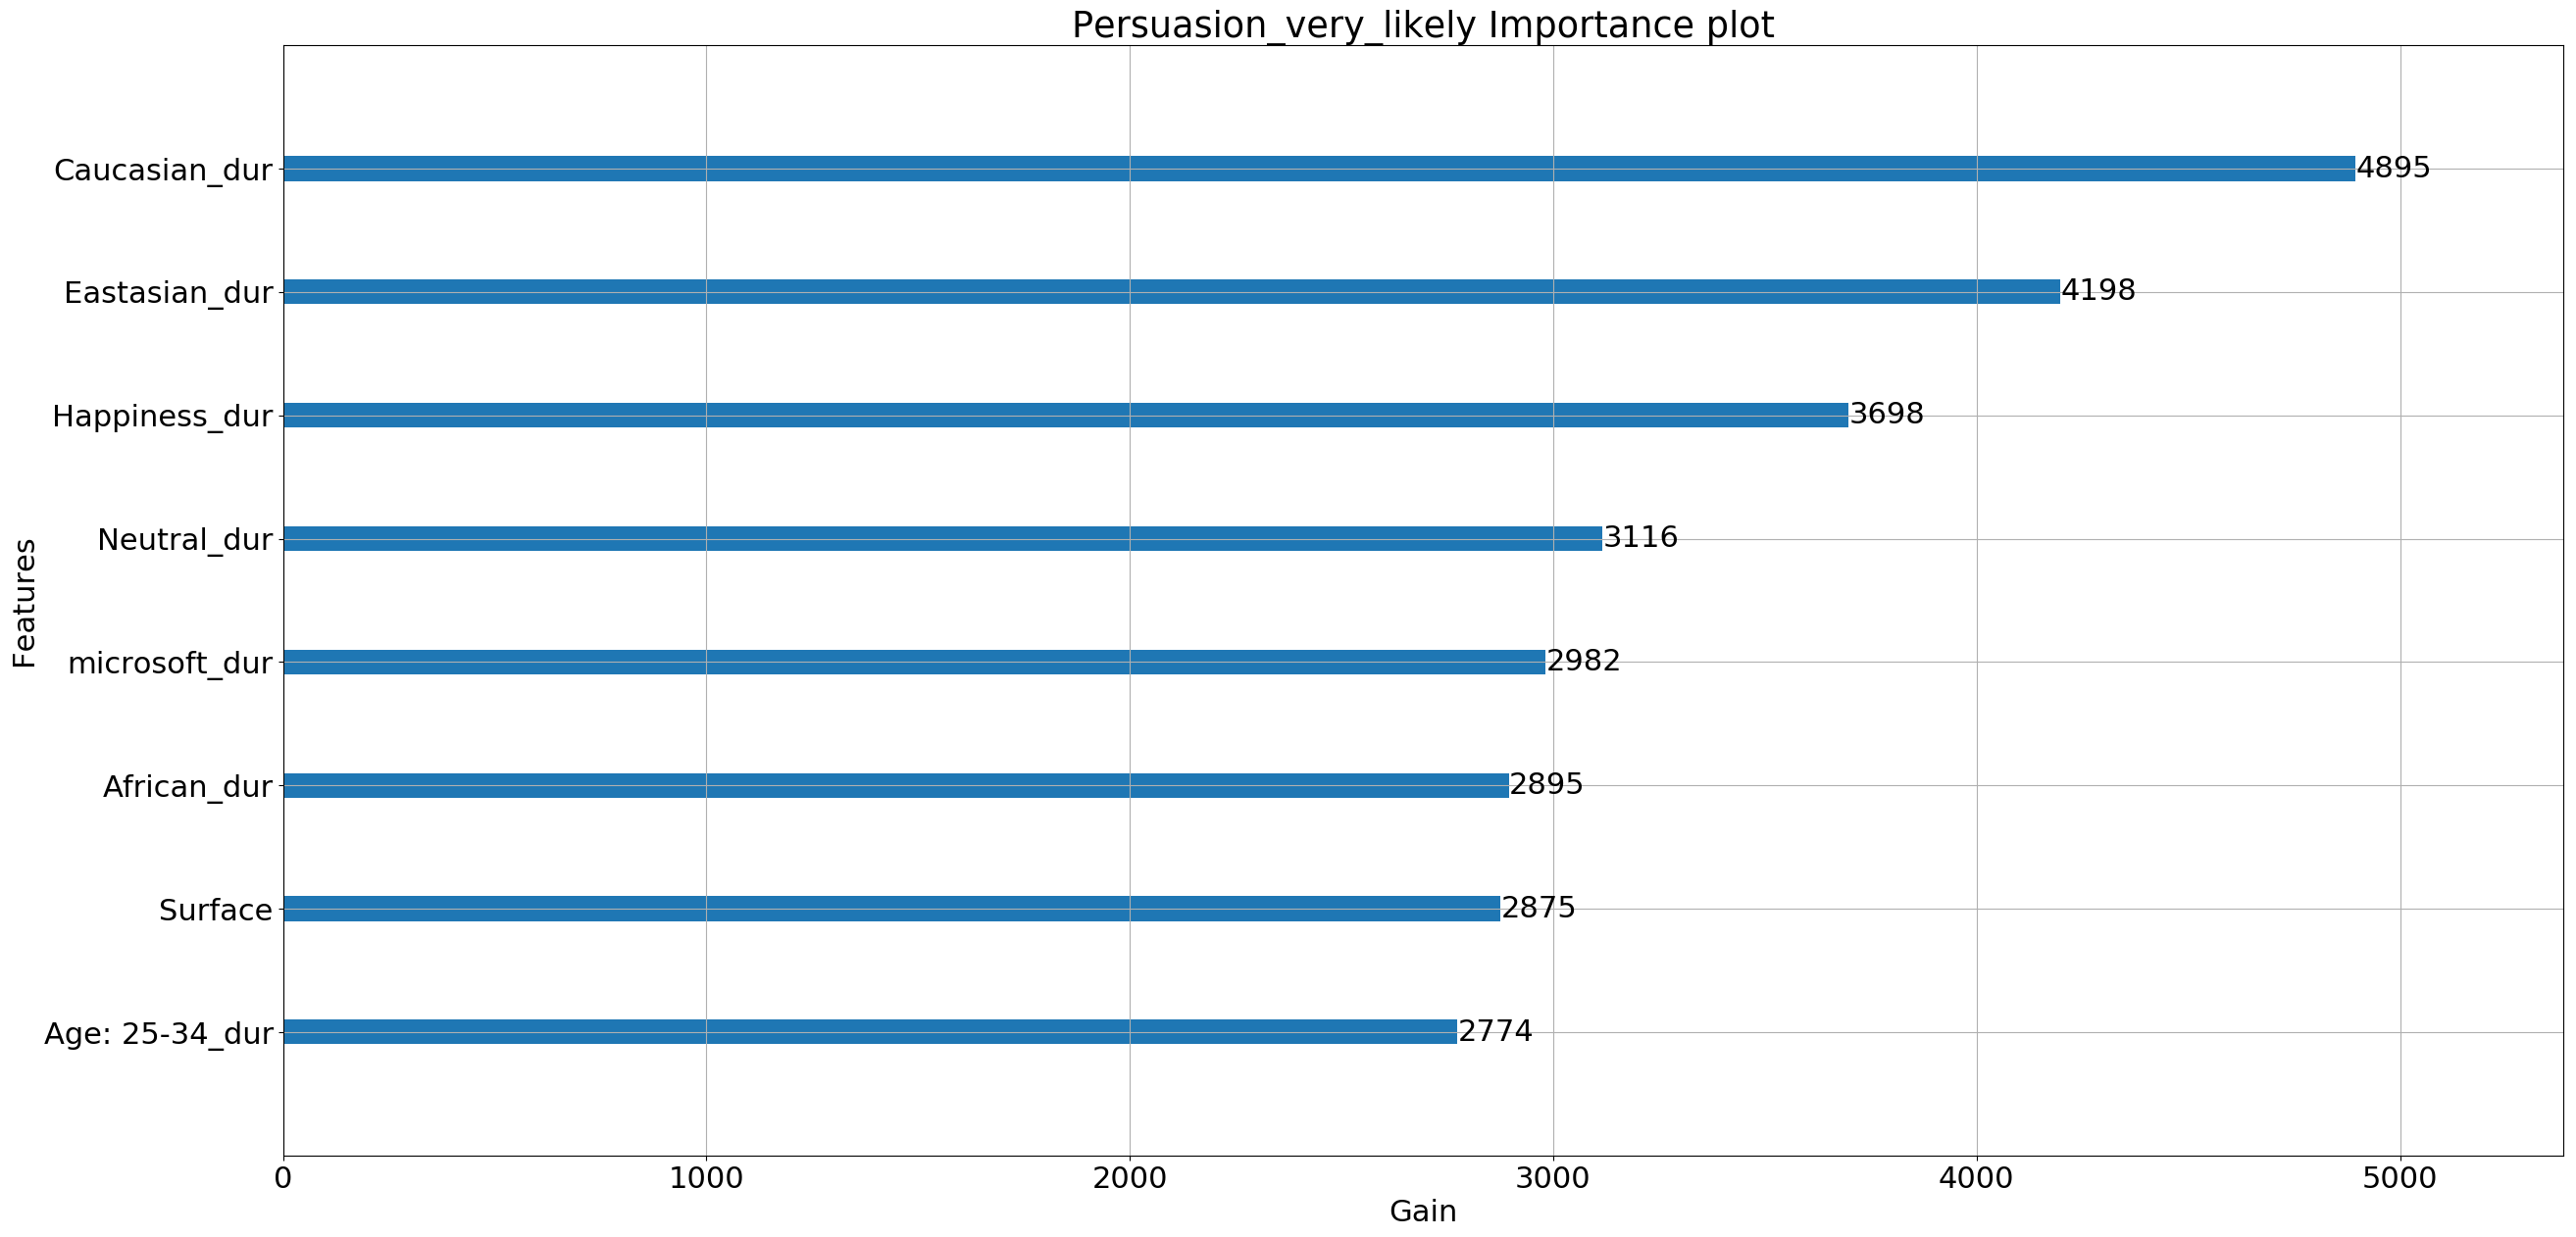

Interest_peak_frames
length_of_ad_15
Surface
Tablet_last_ocr
microsoft_first_ocr
Laptop_total_ocr
Happiness_length_of_ad_impact
Tablet_total_ocr
Neutral_dur
Tablet_dur
Age: 25-34_Eastasian_dur
Laptop_last_ocr
microsoft_last_ocr
Happiness_Female_dur
Sadness_dur
microsoft_total_ocr
Age: 25-34_dur
Laptop_dur
Neutral_Male_dur
Tablet_first_ocr
Laptop_first_ocr
Age: 35-44_Eastasian_dur
Female_dur
Male_dur
microsoft_dur
Happiness_Eastasian_dur
Neutral_Age: 25-34_dur
Macbook_dur
Happiness_dur
Age: 25-34_Caucasian_dur
Eastasian_dur
Age: 35-44_dur
African_dur
Caucasian_dur
ASUS T102_dur
Dell_dur
HP_dur
Lenovo_dur
Windows_dur
Yoga_dur
Surface_first_ocr
Surface_last_ocr
Surface_total_ocr
Surface_dur


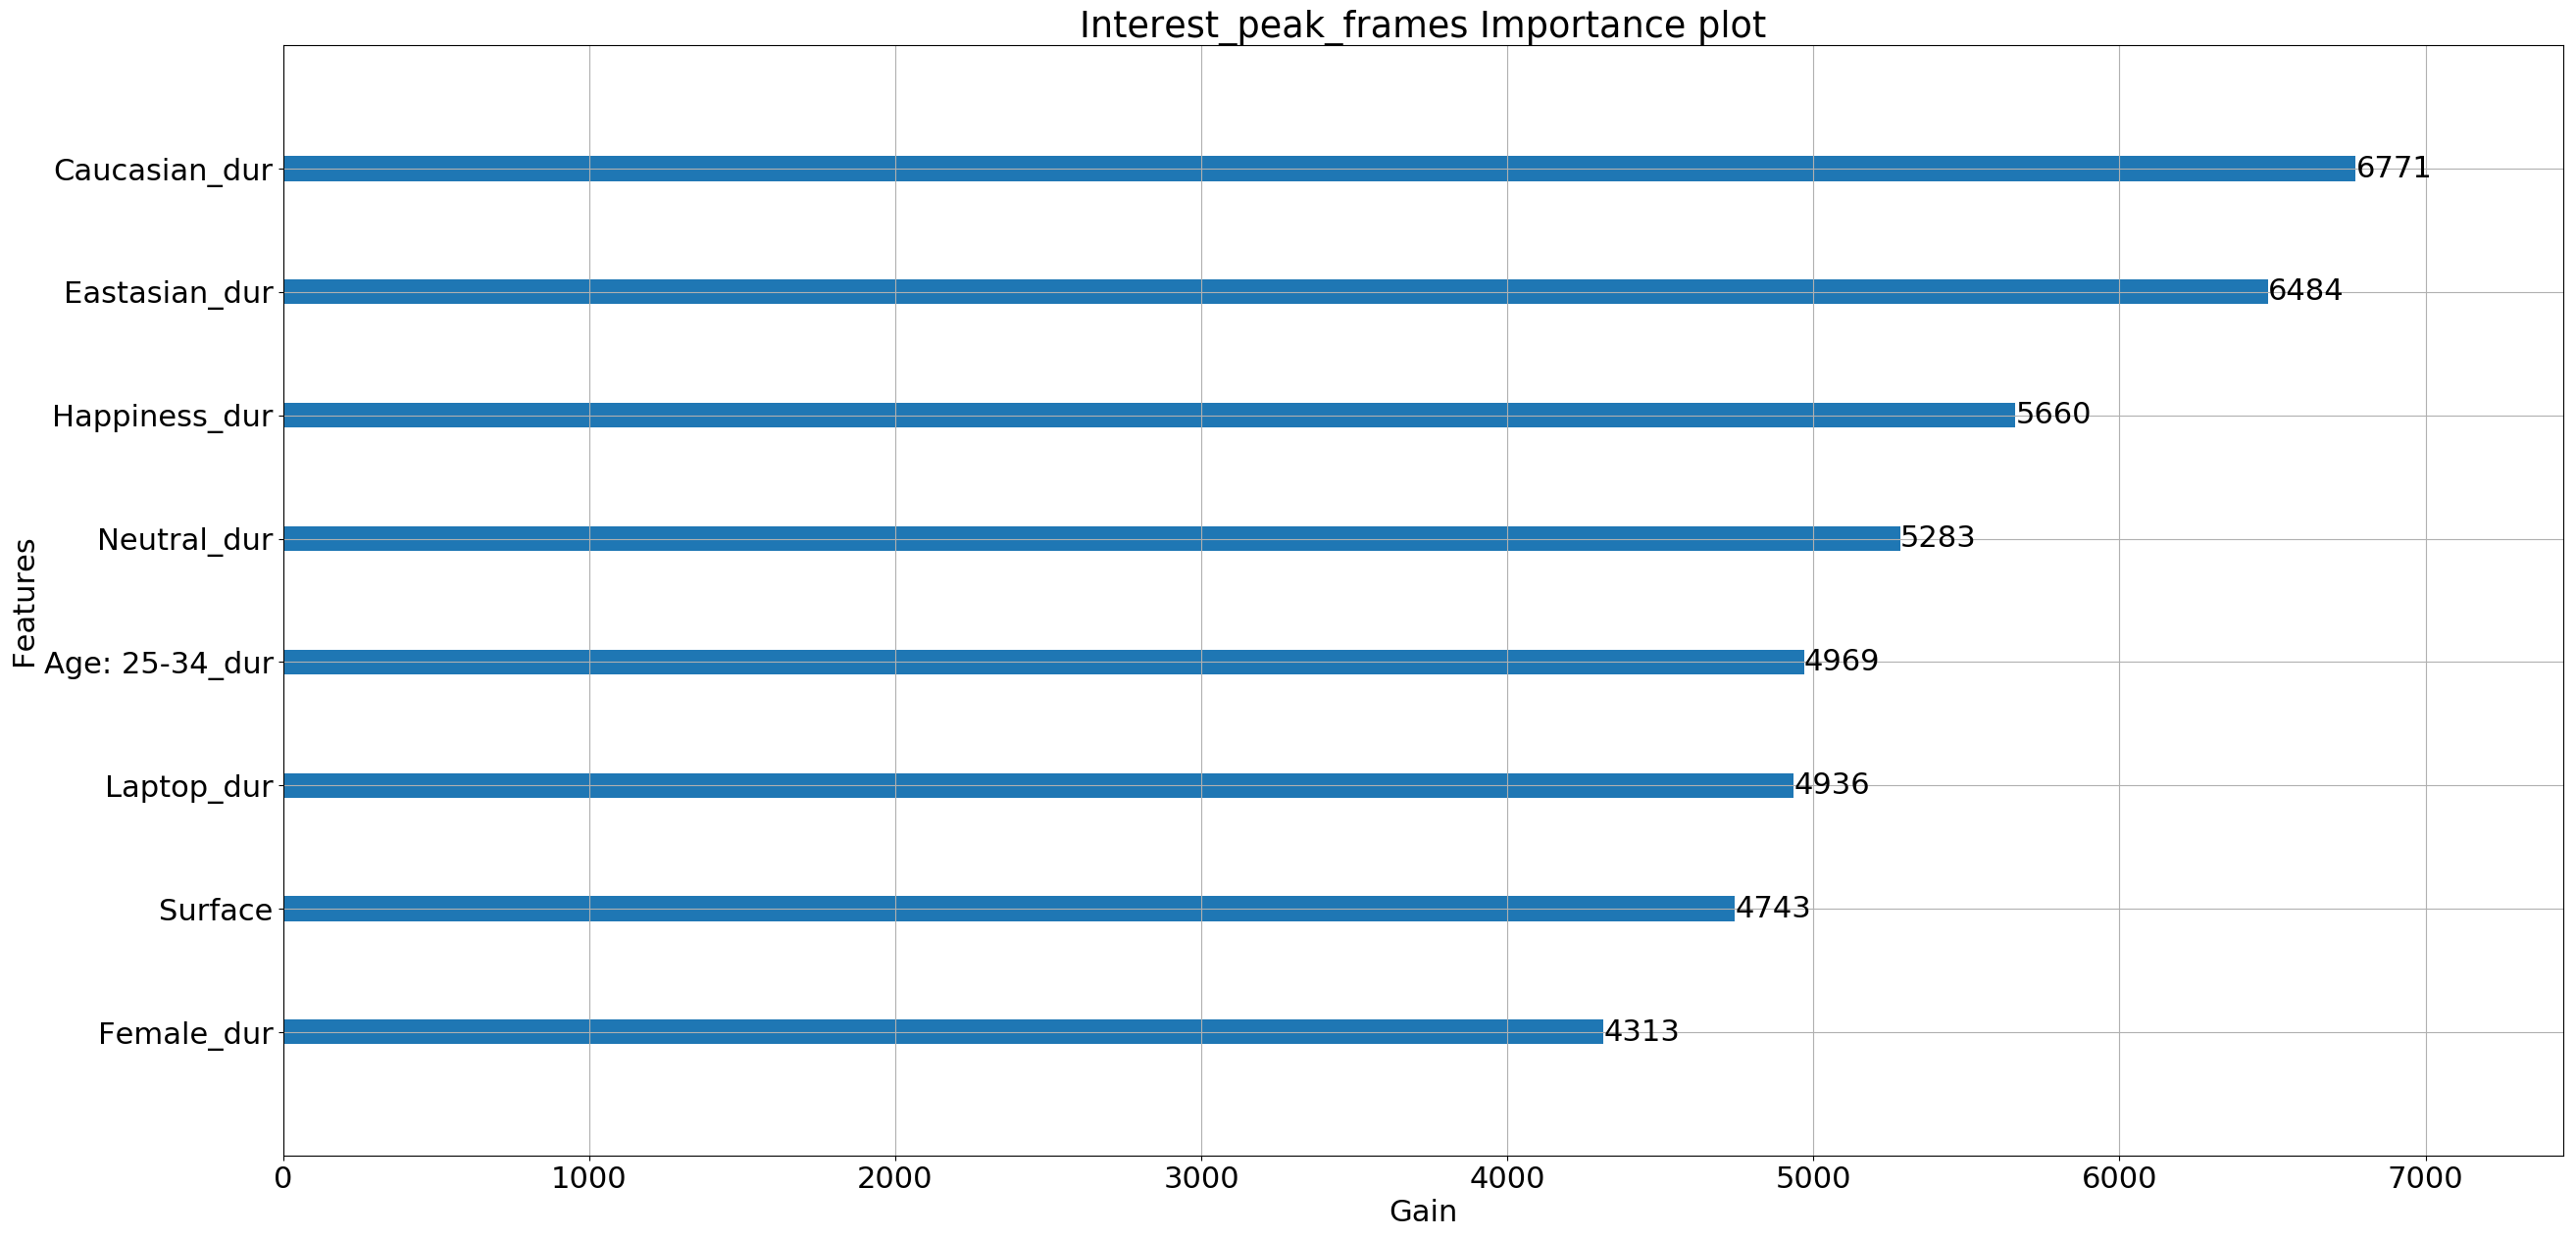

In [45]:
model_xgb.plot_feature_importance(models_xgb_17,10,y_train_17.columns,X_train_17.columns,savefig=False)

In [46]:
explainer_xgb=[]
shap_values_xgb=[]
for i in tqdm(range(17)):
    explainer_xgb.append(shap.TreeExplainer(models_xgb_17[i]))
    shap_values_xgb.append(explainer_xgb[-1].shap_values(X_train_17))
    print(i)

  6%|▌         | 1/17 [00:27<07:19, 27.48s/it]

0


 12%|█▏        | 2/17 [00:36<05:29, 21.98s/it]

1


 18%|█▊        | 3/17 [00:47<04:19, 18.56s/it]

2


 24%|██▎       | 4/17 [00:58<03:32, 16.36s/it]

3


 29%|██▉       | 5/17 [01:08<02:53, 14.48s/it]

4


 35%|███▌      | 6/17 [01:20<02:30, 13.72s/it]

5


 41%|████      | 7/17 [01:30<02:06, 12.64s/it]

6


 47%|████▋     | 8/17 [01:40<01:45, 11.71s/it]

7


 53%|█████▎    | 9/17 [01:49<01:27, 10.89s/it]

8


 59%|█████▉    | 10/17 [01:58<01:12, 10.38s/it]

9


 65%|██████▍   | 11/17 [02:04<00:54,  9.12s/it]

10


 71%|███████   | 12/17 [02:21<00:56, 11.39s/it]

11


 76%|███████▋  | 13/17 [02:32<00:45, 11.41s/it]

12


 82%|████████▏ | 14/17 [02:48<00:38, 12.80s/it]

13


 88%|████████▊ | 15/17 [02:59<00:24, 12.27s/it]

14


 94%|█████████▍| 16/17 [03:12<00:12, 12.49s/it]

15


100%|██████████| 17/17 [03:33<00:00, 15.05s/it]

16


In [ ]:
expla

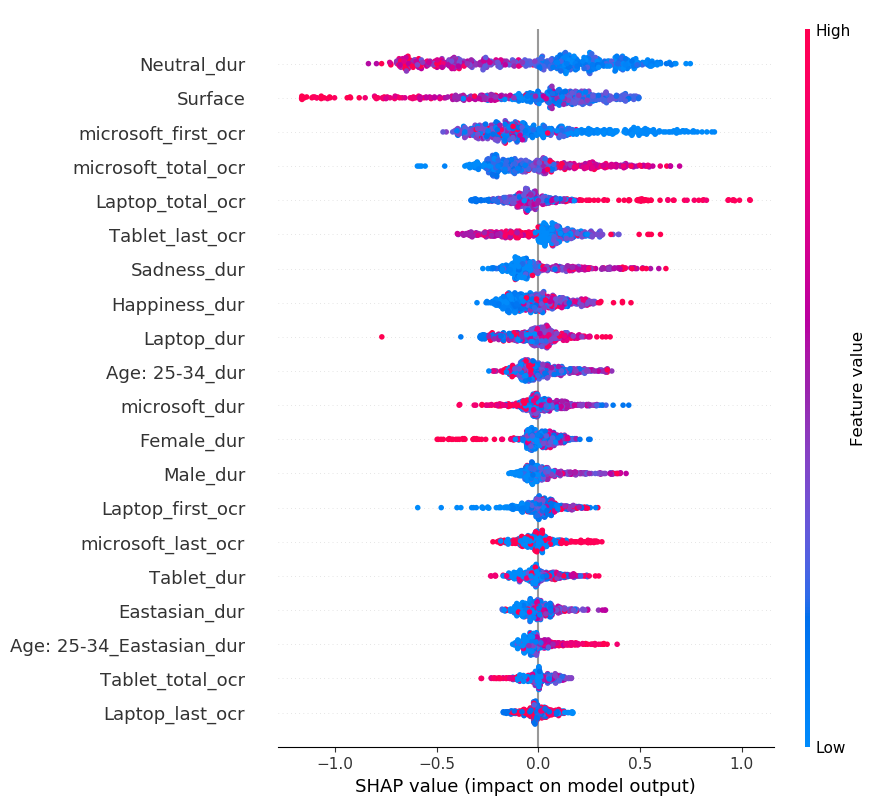

In [64]:
shap.summary_plot(shap_values_xgb[16],X_train_17)

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')